In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

# from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
# from get_draws.api import get_draws

import vivarium_helpers as vh
# import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Thu Feb  5 17:41:03 PST 2026
ndbs
/Users/ndbs/repos/vivarium_research_alzheimers/verification_and_validation


# Record versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                  3.6.6
vivarium_build_utils      2.2.2
vivarium_dependencies     1.0.5
vivarium_helpers          0.5.0.dev251111   /Users/ndbs/repos/vivarium_helpers


In [4]:
!pip freeze | grep vivarium

vivarium==3.6.6
vivarium_build_utils==2.2.2
vivarium_dependencies==1.0.5
-e git+https://github.com/ihmeuw/vivarium_helpers.git@14726994615ddaac5513f19155799d6debf4ecb7#egg=vivarium_helpers


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model12.1/model_spec/2026_02_04_10_16_58/
```

Artifact:

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0
```

In [5]:
# Project directory on the cluster
project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

if os.sys.platform == 'darwin':
    # Notebook is running on Nathaniel's MacBook
    local_project_dir = "/Users/ndbs/project_data/vivarium_csu_alzheimers/"
else:
    # Assume we're running on the cluster
    local_project_dir = project_dir

In [6]:
# Project directory
%cd $local_project_dir

/Users/ndbs/project_data/vivarium_csu_alzheimers


In [7]:
# Results directory containing model 11.1 results for two locations
model_run_subdir = 'results/model12.1/model_spec/2026_02_04_10_16_58/'
!ls -halt $model_run_subdir/results

total 0
drwx------  11 ndbs  staff   352B Feb  5 09:57 ..
drwx------   3 ndbs  staff    96B Feb  5 09:57 counts_newly_eligible_for_bbbm_testing
drwx------   3 ndbs  staff    96B Feb  5 09:56 person_time_treatment
drwx------   3 ndbs  staff    96B Feb  5 09:56 ylds
drwx------   3 ndbs  staff    96B Feb  5 09:56 transition_count_treatment
drwx------   3 ndbs  staff    96B Feb  5 09:55 counts_baseline_tests_among_eligible
drwx------   3 ndbs  staff    96B Feb  5 09:55 deaths
drwx------   3 ndbs  staff    96B Feb  5 09:55 transition_count_alzheimers_disease_and_other_dementias
drwx------   3 ndbs  staff    96B Feb  5 09:54 person_time_ever_eligible_for_bbbm_testing
drwx------   3 ndbs  staff    96B Feb  5 09:53 counts_new_simulants
drwx------   3 ndbs  staff    96B Feb  5 09:53 person_time_alzheimers_disease_and_other_dementias
drwx------   3 ndbs  staff    96B Feb  5 09:52 treatment_duration
drwx------   3 ndbs  staff    96B Feb  5 09:51 counts_bbbm_tests
drwx------   3 ndbs  staff    96B

In [8]:
!ls $model_run_subdir

__pycache__               keyspace.yaml             requirements.txt
branches.yaml             logs                      results
finished_sim_metadata.csv model_specification.yaml  settings.py


In [9]:
!cat $model_run_subdir/model_specification.yaml | grep -e artifact -e results

      controller: vivarium.framework.artifact.ArtifactManager
      builder_interface: vivarium.framework.artifact.ArtifactInterface
    results:
      controller: vivarium.framework.results.ResultsManager
      builder_interface: vivarium.framework.results.ResultsInterface
    results:
      - bbbm_test_results
    results_directory: /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model12.1/model_spec/2026_02_04_10_16_58


In [10]:
locations = [
    'United States of America',
    'Brazil',
    'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

# project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '10.0' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
# Where results are stored locally
run_dirs = [local_project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
# Map locations to where artifacts are stored locally (for reading artifact data)
location_to_local_artifact_path = {
    loc: local_project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
# Map locations to where artifacts are stored on the cluster (for adding locations to sim results)
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf',
 'Brazil': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf',
 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'}

In [11]:
location_to_results_dir

{'all': '/Users/ndbs/project_data/vivarium_csu_alzheimers/results/model12.1/model_spec/2026_02_04_10_16_58/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [12]:
# # Instead of creating this dtype here, create an appropriate dtype in
# # the load_sim_output function.
# # Order locations lexicographically
# all_locations = [
#     'United States of America',
#     'Brazil',
#     'China',
#     'Germany',
#     'Israel',
#     'Japan',
#     'Spain',
#     'Sweden',
#     'Taiwan (Province of China)',
#     'United Kingdom',
# ]
# location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    # 'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [13]:
artifact_path = location_to_local_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [14]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [15]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5    draw_6  \
0  0.527516  0.495529  0.464333  0.576056  0.478925  0.458396  0.541982   

     draw_7   draw_8    draw_9  ...  draw_490  draw_491  draw_492  draw_493  \
0  0.520483  0.53923  0.514836  ...  0.485136  0.498684  0.503797  0.432717   

   draw_494  draw_495  draw_496  draw_497  draw_498  draw_499  
0  0.462276  0.481699  0.569136  0.502568    0.4362  0.512734  

[1 rows x 500 columns]

# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [16]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [17]:
# Create an operator object - treat each random seed as a separate draw,
# and add location to the index
ops = VPHOperator(location_col=True)
# ops.index_cols.extend(['location', 'random_seed'])

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    # Override optional transformations if raw=True
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are concatenated" \
            " in the simulation outputs."
        )

    dfs = []
    for location, directory in results_dict.items():

        # NOTE: New Vivarium version stores each measure in a folder
        # instead of a single .parquet file
        parquet_file_path = Path(directory) / measure #f'{measure}.parquet'
        # The ParquetDataset object has a .schema attribute we can use
        # to get its column names and data types 
        parquet_dataset = pa.parquet.ParquetDataset(parquet_file_path)
        # # NOTE: This code no longer works with datasets stored in
        # # directories instead of single parquet files:
        # # Read the Parquet file's schema to get column names and data types
        # parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_dataset.schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Use logging not printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_dataset.schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)
        # df = parquet_dataset.read(**kwargs).to_pandas()

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # NOTE: location_to_artifact_path is guaranteed not to
                # be None because assign_location and
                # all_locations_together are both True

                # Create a Categorical dtype with all locations
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_artifact_path.keys()), ordered=True)
                # Invert the dictionary so we can map artifact paths to
                # locations
                artifact_path_to_location = {
                    path: loc for loc, path
                    in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                # NOTE: location_to_results_dir contains actual
                # locations as keys (not 'all') since
                # all_locations_together is False

                # Create a Categorical dtype with all locations to avoid
                # converting back to object dtype.
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_results_dir.keys()), ordered=True)
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    # TODO: Maybe if assign_location is False and all_locations_together
    # is also False (and there is more than one location?), we should
    # return a dict mapping locations to dataframes (or just a list of
    # dataframes?) instead of concatenating, since it won't be possible
    # to filter the resulting concatenated dataframe by location...
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=(pd.api.types.is_numeric_dtype,
                        # TODO: For some reason,
                        # pd.api.types.is_categorical_dtype is deprecated, and
                        # they recommend using isinstance instead. So I don't
                        # know if there's a simpler way to make checking for a
                        # categorical dtype more parallel with checking for a
                        # numeric dtype.
                        lambda dtype: isinstance(dtype, pd.CategoricalDtype)),
        inplace=False
    ):
    """Convert all columns except numerical columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols
                and not any(excluded_dtype(df[col].dtype)
                            for excluded_dtype in exclude_dtypes))
                # and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Filter seeds by monkey-patching the above data loading function

In [18]:
# # Model 10.0 was run with 100 seeds instead of 5, so let's just filter
# # everything to 5 seeds to make it all run faster
# # seeds = [338, 6520, 3585, 7745, 539]
# seeds = [7179, 2599, 1534, 386, 1935]
# seed_filter = ('random_seed', 'in', seeds)

# def add_filter(load_func, new_filter):
#     """Return load_func, but with `new_filter` added to its list of
#     parquet filters in the 'filters' key of kwargs.
#     """
#     def new_load_func(*args, **kwargs):
#         user_filters = kwargs.get('filters') # Defaults to None
#         kwargs['filters'] = add_parquet_AND_filter(
#             new_filter, user_filters)
#         return load_func(*args, **kwargs)
#     return new_load_func

# # Monkey-patch!
# load_sim_output = add_filter(load_sim_output, seed_filter)

# Test code for loading sim output

In [19]:
dataset_path = Path(location_to_results_dir['all']) / 'counts_new_simulants'
dataset_path

PosixPath('/Users/ndbs/project_data/vivarium_csu_alzheimers/results/model12.1/model_spec/2026_02_04_10_16_58/results/counts_new_simulants')

In [20]:
!ls $dataset_path

0000.parquet


In [21]:
dataset = pa.parquet.ParquetDataset(dataset_path)
dataset.schema

age_group: dictionary<values=string, indices=int8, ordered=0>
event_year: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ordered=0>
artifact_path: string
scenario: string
input_draw: int64
random_seed: int64
value: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1311

In [22]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
    # aggregate_seeds=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


age_group  event_year     sex  \
0        25_to_29        2022  Female   
1        25_to_29        2022    Male   
2        25_to_29        2023  Female   
3        25_to_29        2023    Male   
4        25_to_29        2024  Female   
...           ...         ...     ...   
2666245   95_plus        2098    Male   
2666246   95_plus        2099  Female   
2666247   95_plus        2099    Male   
2666248   95_plus        2100  Female   
2666249   95_plus        2100    Male   

                                             artifact_path  scenario  \
0        /mnt/team/simulation_science/pub/models/vivari...  baseline   
1        /mnt/team/simulation_science/pub/models/vivari...  baseline   
2        /mnt/team/simulation_science/pub/models/vivari...  baseline   
3        /mnt/team/simulation_science/pub/models/vivari...  baseline   
4        /mnt/team/simulation_science/pub/models/vivari...  baseline   
...                                                    ...       ...   
2666245  /mnt/team/simulation_science/pub/models/vivari...  baseline   
2666246  /mnt/team/simulation_science/pub/models/vivari...  baseline   
2666247  /mnt/team/simulation_science/pub/models/vivari...  baseline   
2666248  /mnt/team/simulation_science/pub/models/vivari...  baseline   
2666249  /mnt/team/simulation_science/pub/models/vivari...  baseline   

         input_draw  random_seed  value  
0               236         2284    0.0  
1               236         2284    0.0  
2               236         2284    0.0  
3               236         2284    0.0  
4               236         2284    0.0  
...             ...          ...    ...  
2666245         236         2787    0.0  
2666246         236         2787    0.0  
2666247         236         2787    0.0  
2666248         236         2787    0.0  
2666249         236         2787    0.0  

[2666250 rows x 8 columns]

In [23]:
new_sims.random_seed.nunique()

5

In [24]:
print(
    new_sims.artifact_path.unique(),
    new_sims.input_draw.unique(),
    # new_sims.random_seed.nunique(),
    new_sims.scenario.unique(),
    new_sims.event_year.unique(),
    sep='\n'
)
if 'location' in new_sims:
    print(new_sims.location.unique())

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf'
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf']
[236 161  41   1 187 199  69 219  63 103 249 183   6  35 123 122 248 245
 204 172 211  24  50   7 235]
['baseline', 'bbbm_testing_and_treatment', 'bbbm_testing']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']
[2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100]


In [25]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666250 entries, 0 to 2666249
Data columns (total 8 columns):
 #   Column         Dtype   
---  ------         -----   
 0   age_group      category
 1   event_year     int16   
 2   sex            category
 3   artifact_path  object  
 4   scenario       category
 5   input_draw     int64   
 6   random_seed    int64   
 7   value          float64 
dtypes: category(3), float64(1), int16(1), int64(2), object(1)
memory usage: 94.1+ MB


In [26]:
new_sims['scenario'].unique()

['baseline', 'bbbm_testing_and_treatment', 'bbbm_testing']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [27]:
new_sims['input_draw'].dtype

dtype('int64')

In [28]:
print(new_sims.input_draw.dtype == 'int') # int64 counts as int
print(new_sims.event_year.dtype == 'int') # int16 does NOT count as int
pd.api.types.is_numeric_dtype(new_sims.event_year)

True
False


True

# Define plotting functions

In [ ]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # TODO: Add a warning if there are unexpected stratifications still present,
    # like scenario (e.g., warn if scenario column is present and contains more
    # than one value, because then we'll be aggregating over scenarios, which is
    # probably not what we want).

    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [30]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
86.390767 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw      measure  \
0        treatment       cause        2022           1  person_time   
1        treatment       cause        2022           1  person_time   
2        treatment       cause        2022           1  person_time   
3        treatment       cause        2022           1  person_time   
4        treatment       cause        2022           1  person_time   
...            ...         ...         ...         ...          ...   
3199495  treatment       cause        2100         249  person_time   
3199496  treatment       cause        2100         249  person_time   
3199497  treatment       cause        2100         249  person_time   
3199498  treatment       cause        2100         249  person_time   
3199499  treatment       cause        2100         249  person_time   

                           scenario     sex                 sub_entity  \
0                          baseline  Female  no_effect_after_treatment   
1                          baseline  Female    no_effect_never_treated   
2                          baseline  Female   susceptible_to_treatment   
3                          baseline  Female           treatment_effect   
4                          baseline  Female      waiting_for_treatment   
...                             ...     ...                        ...   
3199495  bbbm_testing_and_treatment    Male    no_effect_never_treated   
3199496  bbbm_testing_and_treatment    Male   susceptible_to_treatment   
3199497  bbbm_testing_and_treatment    Male           treatment_effect   
3199498  bbbm_testing_and_treatment    Male      waiting_for_treatment   
3199499  bbbm_testing_and_treatment    Male              waning_effect   

                value                  location  
0            0.000000  United States of America  
1            0.000000  United States of America  
2            0.000000  United States of America  
3            0.000000  United States of America  
4            0.000000  United States of America  
...               ...                       ...  
3199495    185.363450                    Brazil  
3199496  13787.154004                    Brazil  
3199497      0.000000                    Brazil  
3199498      0.000000                    Brazil  
3199499     39.863107                    Brazil  

[3199500 rows x 12 columns]

In [31]:
person_time_treatment.event_year.unique()

array([2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054,
       2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
       2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076,
       2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100], dtype=int16)

In [32]:
person_time_treatment.sub_entity.unique()

['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [33]:
person_time_treatment.query("sub_entity == 'waiting_for_treatment'")

age_group                                      artifact_path  \
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
10       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
16       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
22       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
28       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199474   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199480   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199486   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199492   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw      measure  \
4        treatment       cause        2022           1  person_time   
10       treatment       cause        2022           1  person_time   
16       treatment       cause        2022           1  person_time   
22       treatment       cause        2022           1  person_time   
28       treatment       cause        2022           1  person_time   
...            ...         ...         ...         ...          ...   
3199474  treatment       cause        2100         249  person_time   
3199480  treatment       cause        2100         249  person_time   
3199486  treatment       cause        2100         249  person_time   
3199492  treatment       cause        2100         249  person_time   
3199498  treatment       cause        2100         249  person_time   

                           scenario     sex             sub_entity  value  \
4                          baseline  Female  waiting_for_treatment    0.0   
10                         baseline    Male  waiting_for_treatment    0.0   
16                     bbbm_testing  Female  waiting_for_treatment    0.0   
22                     bbbm_testing    Male  waiting_for_treatment    0.0   
28       bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
...                             ...     ...                    ...    ...   
3199474                    baseline    Male  waiting_for_treatment    0.0   
3199480                bbbm_testing  Female  waiting_for_treatment    0.0   
3199486                bbbm_testing    Male  waiting_for_treatment    0.0   
3199492  bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
3199498  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   

                         location  
4        United States of America  
10       United States of America  
16       United States of America  
22       United States of America  
28       United States of America  
...                           ...  
3199474                    Brazil  
3199480                    Brazil  
3199486                    Brazil  
3199492                    Brazil  
3199498                    Brazil  

[533250 rows x 12 columns]

In [34]:
person_time_treatment.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
measure          category
scenario         category
sex              category
sub_entity       category
value             float64
location         category
dtype: object

# Load treatment transition counts

In [35]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
71.993059 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2666245   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2666246   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2666247   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2666248   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2666249   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw           measure  \
0        treatment       cause        2022           1  transition_count   
1        treatment       cause        2022           1  transition_count   
2        treatment       cause        2022           1  transition_count   
3        treatment       cause        2022           1  transition_count   
4        treatment       cause        2022           1  transition_count   
...            ...         ...         ...         ...               ...   
2666245  treatment       cause        2100         249  transition_count   
2666246  treatment       cause        2100         249  transition_count   
2666247  treatment       cause        2100         249  transition_count   
2666248  treatment       cause        2100         249  transition_count   
2666249  treatment       cause        2100         249  transition_count   

                           scenario     sex  \
0                          baseline  Female   
1                          baseline  Female   
2                          baseline  Female   
3                          baseline  Female   
4                          baseline  Female   
...                             ...     ...   
2666245  bbbm_testing_and_treatment    Male   
2666246  bbbm_testing_and_treatment    Male   
2666247  bbbm_testing_and_treatment    Male   
2666248  bbbm_testing_and_treatment    Male   
2666249  bbbm_testing_and_treatment    Male   

                                                sub_entity  value  \
0        susceptible_to_treatment_to_no_effect_never_tr...    0.0   
1        susceptible_to_treatment_to_waiting_for_treatment    0.0   
2                        treatment_effect_to_waning_effect    0.0   
3                waiting_for_treatment_to_treatment_effect    0.0   
4               waning_effect_to_no_effect_after_treatment    0.0   
...                                                    ...    ...   
2666245  susceptible_to_treatment_to_no_effect_never_tr...    0.0   
2666246  susceptible_to_treatment_to_waiting_for_treatment    0.0   
2666247                  treatment_effect_to_waning_effect    0.0   
2666248          waiting_for_treatment_to_treatment_effect    0.0   
2666249         waning_effect_to_no_effect_after_treatment   25.0   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
2666245                    Brazil  
2666246                    Brazil  
2666247                    Brazil  
2666248                    Brazil  
2666249                    Brazil  

[2666250 rows x 12 columns]

In [36]:
transition_count_treatment.sub_entity.unique()

['susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'treatment_effect_to_waning_effect', 'waiting_for_treatment_to_treatment_effect', 'waning_effect_to_no_effect_after_treatment']
Categories (5, object): ['susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'treatment_effect_to_waning_effect', 'waiting_for_treatment_to_treatment_effect', 'waning_effect_to_no_effect_after_treatment']

In [37]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

age_group                                      artifact_path  \
1425760  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1425765  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1425790  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1425795  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1425820  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1955175  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
1955200  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
1955205  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
1955230  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
1955235  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw           measure  \
1425760  treatment       cause        2027           1  transition_count   
1425765  treatment       cause        2027           1  transition_count   
1425790  treatment       cause        2027           6  transition_count   
1425795  treatment       cause        2027           6  transition_count   
1425820  treatment       cause        2027           7  transition_count   
...            ...         ...         ...         ...               ...   
1955175  treatment       cause        2100         245  transition_count   
1955200  treatment       cause        2100         248  transition_count   
1955205  treatment       cause        2100         248  transition_count   
1955230  treatment       cause        2100         249  transition_count   
1955235  treatment       cause        2100         249  transition_count   

             scenario     sex  \
1425760  bbbm_testing  Female   
1425765  bbbm_testing    Male   
1425790  bbbm_testing  Female   
1425795  bbbm_testing    Male   
1425820  bbbm_testing  Female   
...               ...     ...   
1955175  bbbm_testing    Male   
1955200  bbbm_testing  Female   
1955205  bbbm_testing    Male   
1955230  bbbm_testing  Female   
1955235  bbbm_testing    Male   

                                                sub_entity   value  \
1425760  susceptible_to_treatment_to_no_effect_never_tr...    28.0   
1425765  susceptible_to_treatment_to_no_effect_never_tr...    12.0   
1425790  susceptible_to_treatment_to_no_effect_never_tr...    36.0   
1425795  susceptible_to_treatment_to_no_effect_never_tr...    11.0   
1425820  susceptible_to_treatment_to_no_effect_never_tr...    24.0   
...                                                    ...     ...   
1955175  susceptible_to_treatment_to_no_effect_never_tr...   673.0   
1955200  susceptible_to_treatment_to_no_effect_never_tr...  1013.0   
1955205  susceptible_to_treatment_to_no_effect_never_tr...   455.0   
1955230  susceptible_to_treatment_to_no_effect_never_tr...  1153.0   
1955235  susceptible_to_treatment_to_no_effect_never_tr...   550.0   

                         location  
1425760  United States of America  
1425765  United States of America  
1425790  United States of America  
1425795  United States of America  
1425820  United States of America  
...                           ...  
1955175                    Brazil  
1955200                    Brazil  
1955205                    Brazil  
1955230                    Brazil  
1955235                    Brazil  

[33300 rows x 12 columns]

In [38]:
non_treatment_transitions.scenario.unique()

['bbbm_testing']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [39]:
list(non_treatment_transitions.sub_entity.unique())

['susceptible_to_treatment_to_no_effect_never_treated']

In [40]:
transition_count_treatment.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
measure          category
scenario         category
sex              category
sub_entity       category
value             float64
location         category
dtype: object

In [41]:
df = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # .pipe(convert_to_categorical)
)
df .dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
location         category
measure          category
scenario         category
sex              category
sub_entity       category
value             float64
from_state         object
to_state           object
dtype: object

In [42]:
df.event_year.dtype == 'int16'

True

# Transform treatment transition counts into more useful form

In [43]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

25.779088 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
888745   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888746   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888747   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888748   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888749   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type  event_year  input_draw  \
0       treatment       cause        2022           1   
1       treatment       cause        2022           1   
2       treatment       cause        2022           1   
3       treatment       cause        2022           1   
4       treatment       cause        2022           1   
...           ...         ...         ...         ...   
888745  treatment       cause        2100         249   
888746  treatment       cause        2100         249   
888747  treatment       cause        2100         249   
888748  treatment       cause        2100         249   
888749  treatment       cause        2100         249   

                        location           measure  \
0       United States of America  transition_count   
1       United States of America  transition_count   
2       United States of America  transition_count   
3       United States of America  transition_count   
4       United States of America  transition_count   
...                          ...               ...   
888745                    Brazil  transition_count   
888746                    Brazil  transition_count   
888747                    Brazil  transition_count   
888748                    Brazil  transition_count   
888749                    Brazil  transition_count   

                          scenario     sex  \
0       bbbm_testing_and_treatment  Female   
1       bbbm_testing_and_treatment  Female   
2       bbbm_testing_and_treatment  Female   
3       bbbm_testing_and_treatment  Female   
4       bbbm_testing_and_treatment  Female   
...                            ...     ...   
888745  bbbm_testing_and_treatment    Male   
888746  bbbm_testing_and_treatment    Male   
888747  bbbm_testing_and_treatment    Male   
888748  bbbm_testing_and_treatment    Male   
888749  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0       susceptible_to_treatment_to_no_effect_never_tr...    0.0   
1       susceptible_to_treatment_to_waiting_for_treatment    0.0   
2                       treatment_effect_to_waning_effect    0.0   
3               waiting_for_treatment_to_treatment_effect    0.0   
4              waning_effect_to_no_effect_after_treatment    0.0   
...                                                   ...    ...   
888745  susceptible_to_treatment_to_no_effect_never_tr...    0.0   
888746  susceptible_to_treatment_to_waiting_for_treatment    0.0   
888747                  treatment_effect_to_waning_effect    0.0   
888748          waiting_for_treatment_to_treatment_effect    0.0   
888749         waning_effect_to_no_effect_after_treatment   25.0   

                      from_state                   to_state  
0       susceptible_to_treatment    no_effect_never_treated  
1       susceptible_to_treatment      waiting_for_treatment  
2               treatment_effect              waning_effect  
3          waiting_for_treatment           treatment_effect  
4                  waning_effect  no_effect_after_treatment  
...                          ...                        ...  
888745  suscepti

In [44]:
treatment_transitions.to_state

0           no_effect_never_treated
1             waiting_for_treatment
2                     waning_effect
3                  treatment_effect
4         no_effect_after_treatment
                    ...            
888745      no_effect_never_treated
888746        waiting_for_treatment
888747                waning_effect
888748             treatment_effect
888749    no_effect_after_treatment
Name: to_state, Length: 888750, dtype: category
Categories (5, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> We will use a piecewise linear ramp-up with knots at the following (year, level) values: (2022.0, 0), (2027.0, 0), (2035.5, 30), (2100.0, 80), (2101.0, 80).
>
> This captures the CSU client’s specification that
> “30% of eligible patients initiate by 2035, with a steady increase to 80% by 2100, for all countries,” and that treatment should first be available in 2027, slowly ramping up to 30% in 2035.

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'waiting_for_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'waiting_for_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks like treatment still starts in 2030, not 2027

But maybe the piecewise linear function is actually correct, and it's
just getting cut off for some reason?



In [45]:
treatment_transitions.to_state.unique()

['no_effect_never_treated', 'waiting_for_treatment', 'waning_effect', 'treatment_effect', 'no_effect_after_treatment']
Categories (5, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [46]:
testing_eligible_age_groups = age_groups[7:11]
testing_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79']

In [47]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Note that these are the ages when people should enter one of
# the 'full_effect' states, not the 'waiting_for_treatment' state
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [48]:
# Verify that no one outside the testing-eligible age groups starts
#  waiting for treatment
assert set(treatment_transitions.query( \
        "to_state == 'waiting_for_treatment'" \
        " and age_group not in @testing_eligible_age_groups" \
    ).value.unique()) == {0.0}, \
        "Nonzero waiting for treatment counts outside eligible age groups"

In [50]:
treatment_transitions.query( \
        "to_state == 'waiting_for_treatment' and value > 0" \
    ).age_group.unique()

['65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [51]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the testing-eligible age groups
assert set(treatment_transitions.query( \
        "to_state == 'waiting_for_treatment' and value > 0" \
    ).age_group.unique()) \
        == {'65_to_69', '70_to_74', '75_to_79'}, \
            "Waiting for treatment occurring in wrong age groups"

In [52]:
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

event_year                                                          \
               count         mean        std     min     25%     50%     75%   
age_group                                                                      
65_to_69     10977.0  2063.903070  21.136054  2027.0  2046.0  2064.0  2082.0   
70_to_74     11012.0  2063.788231  21.200331  2027.0  2045.0  2064.0  2082.0   
75_to_79     11045.0  2063.680579  21.259834  2027.0  2045.0  2064.0  2082.0   

                  input_draw              ...                  value  \
              max      count        mean  ...    75%    max    count   
age_group                                 ...                          
65_to_69   2100.0    10977.0  135.572014  ...  211.0  249.0  10977.0   
70_to_74   2100.0    11012.0  135.799491  ...  211.0  249.0  11012.0   
75_to_79   2100.0    11045.0  135.722227  ...  211.0  249.0  11045.0   

                                                                     
                 mean         std  min    25%    50%    75%     max  
age_group                                                            
65_to_69   242.441651  192.467367  1.0   99.0  190.0  332.0   806.0  
70_to_74   296.700236  218.464630  1.0  130.0  254.0  428.0  1027.0  
75_to_79   348.028610  209.437528  1.0  205.0  337.0  480.0  1019.0  

[3 rows x 24 columns]

In [53]:
ops.index_cols

['input_draw', 'scenario', 'location']

In [54]:
# Check that treatment starts in 2027
(
    treatment_transitions
    .astype({'event_year': 'int'})
    .query("from_state == 'susceptible_to_treatment' and value > 0")
    .groupby('location', observed=True)
    .event_year
    .min()
)

location
Brazil                      2027
China                       2027
United States of America    2027
Name: event_year, dtype: int64

In [55]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    # dropna=True,
)
initiate_vs_not

event_year                 to_state  input_draw  \
0            2022  no_effect_never_treated           1   
1            2022    waiting_for_treatment           1   
2            2022  no_effect_never_treated           1   
3            2022    waiting_for_treatment           1   
4            2022  no_effect_never_treated           1   
...           ...                      ...         ...   
11845        2100    waiting_for_treatment         249   
11846        2100  no_effect_never_treated         249   
11847        2100    waiting_for_treatment         249   
11848        2100  no_effect_never_treated         249   
11849        2100    waiting_for_treatment         249   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                    Brazil       NaN   
1      bbbm_testing_and_treatment                    Brazil       NaN   
2      bbbm_testing_and_treatment                     China       NaN   
3      bbbm_testing_and_treatment                     China       NaN   
4      bbbm_testing_and_treatment  United States of America       NaN   
...                           ...                       ...       ...   
11845  bbbm_testing_and_treatment                    Brazil  0.784625   
11846  bbbm_testing_and_treatment                     China  0.215528   
11847  bbbm_testing_and_treatment                     China  0.784472   
11848  bbbm_testing_and_treatment  United States of America  0.218559   
11849  bbbm_testing_and_treatment  United States of America  0.781441   

      numerator_measure denominator_measure  multiplier  
0      transition_count    transition_count           1  
1      transition_count    transition_count           1  
2      transition_count    transition_count           1  
3      transition_count    transition_count           1  
4      transition_count    transition_count           1  
...                 ...                 ...         ...  
11845  transition_count    transition_count           1  
11846  transition_count    transition_count           1  
11847  transition_count    transition_count           1  
11848  transition_count    transition_count           1  
11849  transition_count    transition_count           1  

[11850 rows x 9 columns]

In [56]:
initiate_vs_not.query("value >0").event_year.unique()

array([2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048,
       2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
       2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070,
       2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
       2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100], dtype=int16)

In [57]:
initiate_vs_not.to_state.unique()

['no_effect_never_treated', 'waiting_for_treatment']
Categories (5, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

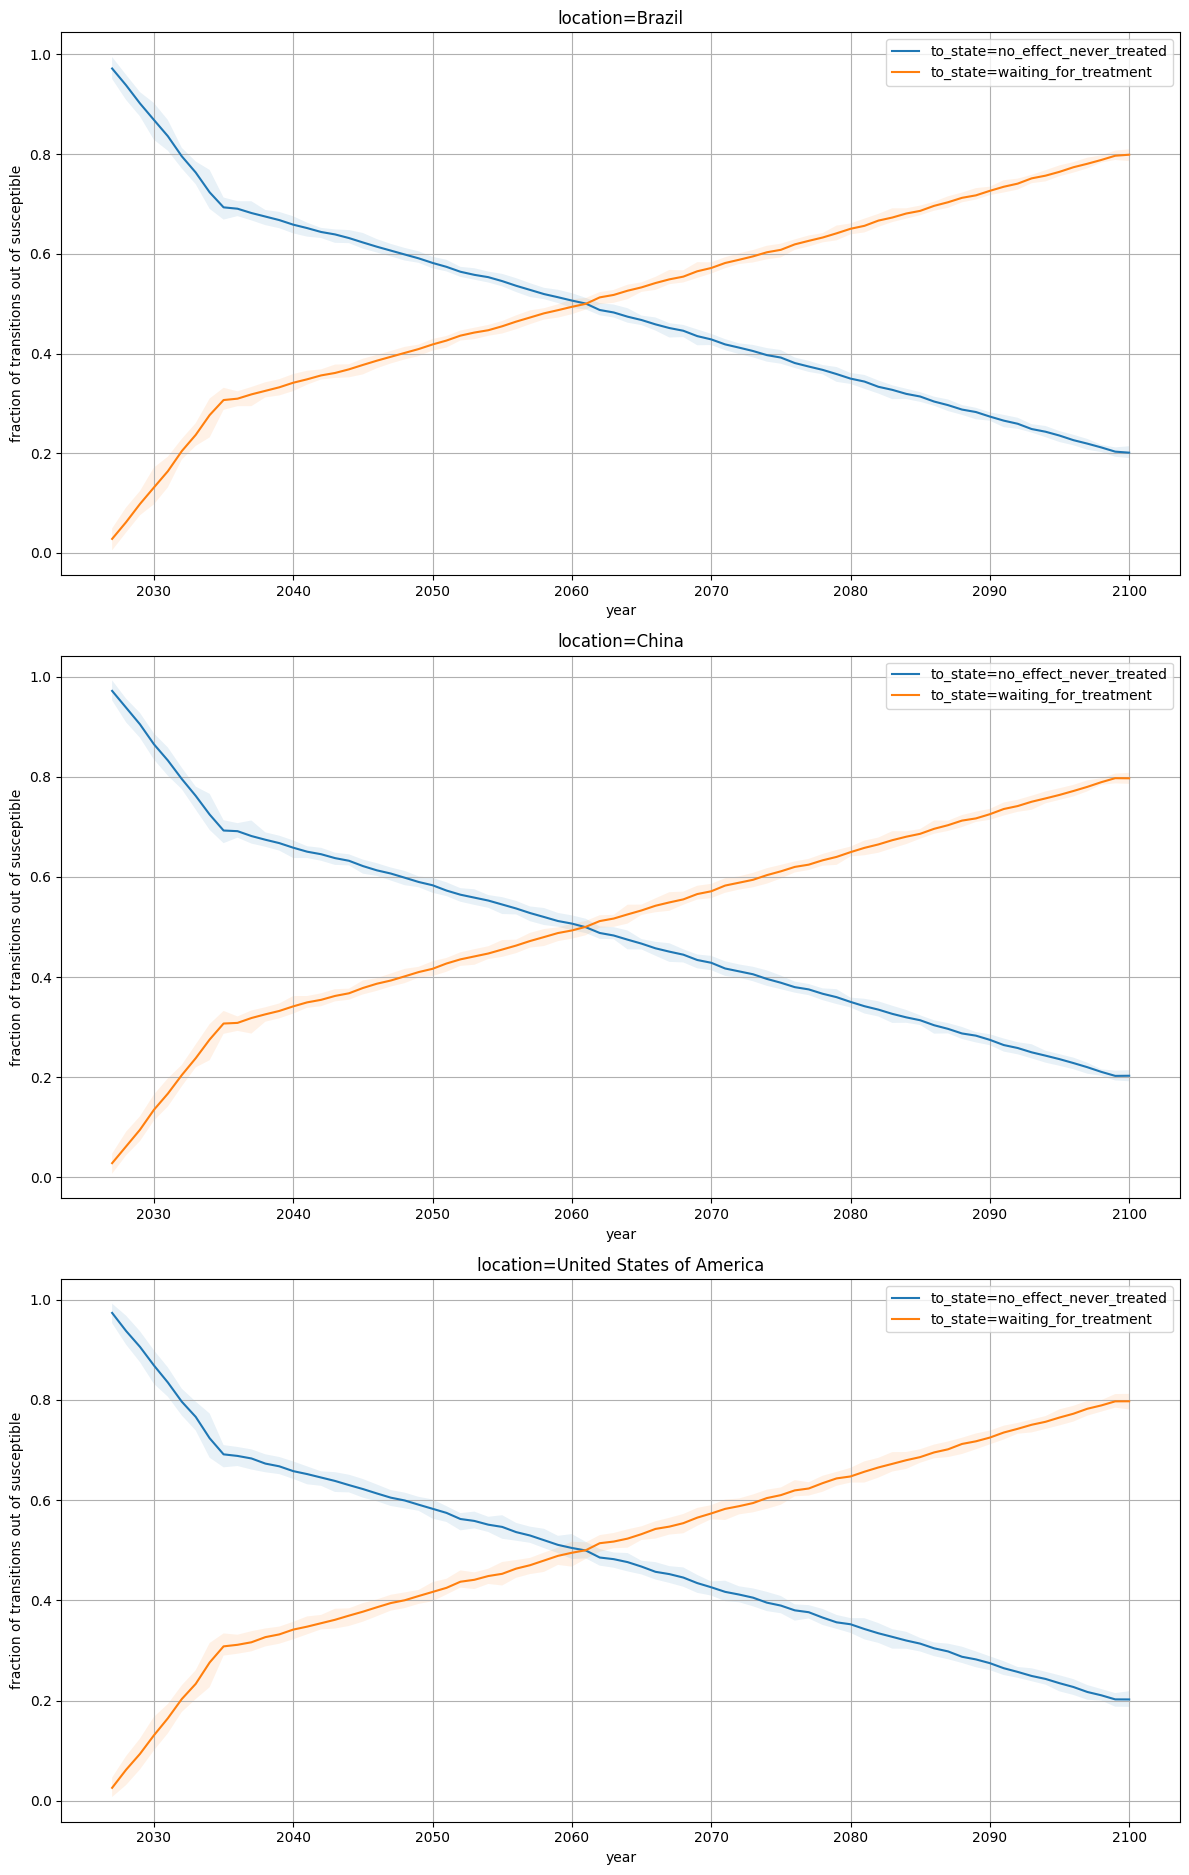

In [58]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Strategy using new `treatment_duration` dataframe

For each year, compute the fraction of simulants who complete 9 months
of treatment among those who complete more than 0 months of treatment.
This should be 90%. Moreover, in this same group, for each $k\in \{1, \dotsc, 8\}$, the
fraction of those who complete $k$ months of treatment should be 10/8 =
1.25%.

Out of the total, the fraction of simulants who complete more than 0
months of treatment should (maybe) be the treatment rate for the year.

## Looks good

In [59]:
colname_to_dtype

{'event_year': 'int16',
 'age_group': CategoricalDtype(categories=['25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49',
                   '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74',
                   '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus'],
 , ordered=True, categories_dtype=object),
 'scenario': CategoricalDtype(categories=['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], ordered=True, categories_dtype=object)}

In [60]:
treatment_duration = load_sim_output(
    'treatment_duration',
    colname_to_dtype = colname_to_dtype | {'sub_entity': 'int8'},
    )
treatment_duration

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
5332495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw  \
0        treatment       cause        2022           1   
1        treatment       cause        2022           1   
2        treatment       cause        2022           1   
3        treatment       cause        2022           1   
4        treatment       cause        2022           1   
...            ...         ...         ...         ...   
5332495  treatment       cause        2100         249   
5332496  treatment       cause        2100         249   
5332497  treatment       cause        2100         249   
5332498  treatment       cause        2100         249   
5332499  treatment       cause        2100         249   

                          measure                    scenario     sex  \
0        treatment_duration_count                    baseline  Female   
1        treatment_duration_count                    baseline  Female   
2        treatment_duration_count                    baseline  Female   
3        treatment_duration_count                    baseline  Female   
4        treatment_duration_count                    baseline  Female   
...                           ...                         ...     ...   
5332495  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332496  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332497  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332498  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332499  treatment_duration_count  bbbm_testing_and_treatment    Male   

         sub_entity  value                  location  
0                 0    0.0  United States of America  
1                 1    0.0  United States of America  
2                 2    0.0  United States of America  
3                 3    0.0  United States of America  
4                 4    0.0  United States of America  
...             ...    ...                       ...  
5332495           5    0.0                    Brazil  
5332496           6    0.0                    Brazil  
5332497           7    0.0                    Brazil  
5332498           8    0.0                    Brazil  
5332499           9    0.0                    Brazil  

[5332500 rows x 12 columns]

In [61]:
treatment_duration.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
measure          category
scenario         category
sex              category
sub_entity           int8
value             float64
location         category
dtype: object

In [62]:
treatment_duration.scenario.unique()

['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [63]:
assert set(treatment_duration.query("value > 0").scenario.unique()) == {'bbbm_testing_and_treatment'}, \
    "Treatments occurring in wrong scenarios"

In [65]:
assert set(treatment_duration.query("value > 0").age_group.unique()) \
    == {'65_to_69', '70_to_74', '75_to_79'}, \
        "Treatments occurring in wrong age groups"

In [66]:
# Compute fraction of treatments discontinued after k months, where k =
# 1, 2, 3, ..., 9
fraction_among_treated = ops.ratio(
    treatment_duration,
    treatment_duration,
    # Stratify by year so we can plot over time
    strata=['event_year'],
    # Stratify numerator by months of treatment; denominator will be the
    # sum of all those with more than 0 months
    numerator_broadcast=['sub_entity'],
    # Filter to those who got treatment
    prefilter_query="sub_entity > 0",
).rename(columns={'sub_entity': 'months_of_treatment'})
fraction_among_treated

event_year  months_of_treatment  input_draw  \
0             2022                    1           1   
1             2022                    2           1   
2             2022                    3           1   
3             2022                    4           1   
4             2022                    5           1   
...            ...                  ...         ...   
159970        2100                    5         249   
159971        2100                    6         249   
159972        2100                    7         249   
159973        2100                    8         249   
159974        2100                    9         249   

                          scenario                  location     value  \
0                         baseline                    Brazil       NaN   
1                         baseline                    Brazil       NaN   
2                         baseline                    Brazil       NaN   
3                         baseline                    Brazil       NaN   
4                         baseline                    Brazil       NaN   
...                            ...                       ...       ...   
159970  bbbm_testing_and_treatment  United States of America  0.012579   
159971  bbbm_testing_and_treatment  United States of America  0.012095   
159972  bbbm_testing_and_treatment  United States of America  0.011127   
159973  bbbm_testing_and_treatment  United States of America  0.011127   
159974  bbbm_testing_and_treatment  United States of America  0.909047   

               numerator_measure       denominator_measure  multiplier  
0       treatment_duration_count  treatment_duration_count           1  
1       treatment_duration_count  treatment_duration_count           1  
2       treatment_duration_count  treatment_duration_count           1  
3       treatment_duration_count  treatment_duration_count           1  
4       treatment_duration_count  treatment_duration_count           1  
...                          ...                       ...         ...  
159970  treatment_duration_count  treatment_duration_count           1  
159971  treatment_duration_count  treatment_duration_count           1  
159972  treatment_duration_count  treatment_duration_count           1  
159973  treatment_duration_count  treatment_duration_count           1  
159974  treatment_duration_count  treatment_duration_count           1  

[159975 rows x 9 columns]

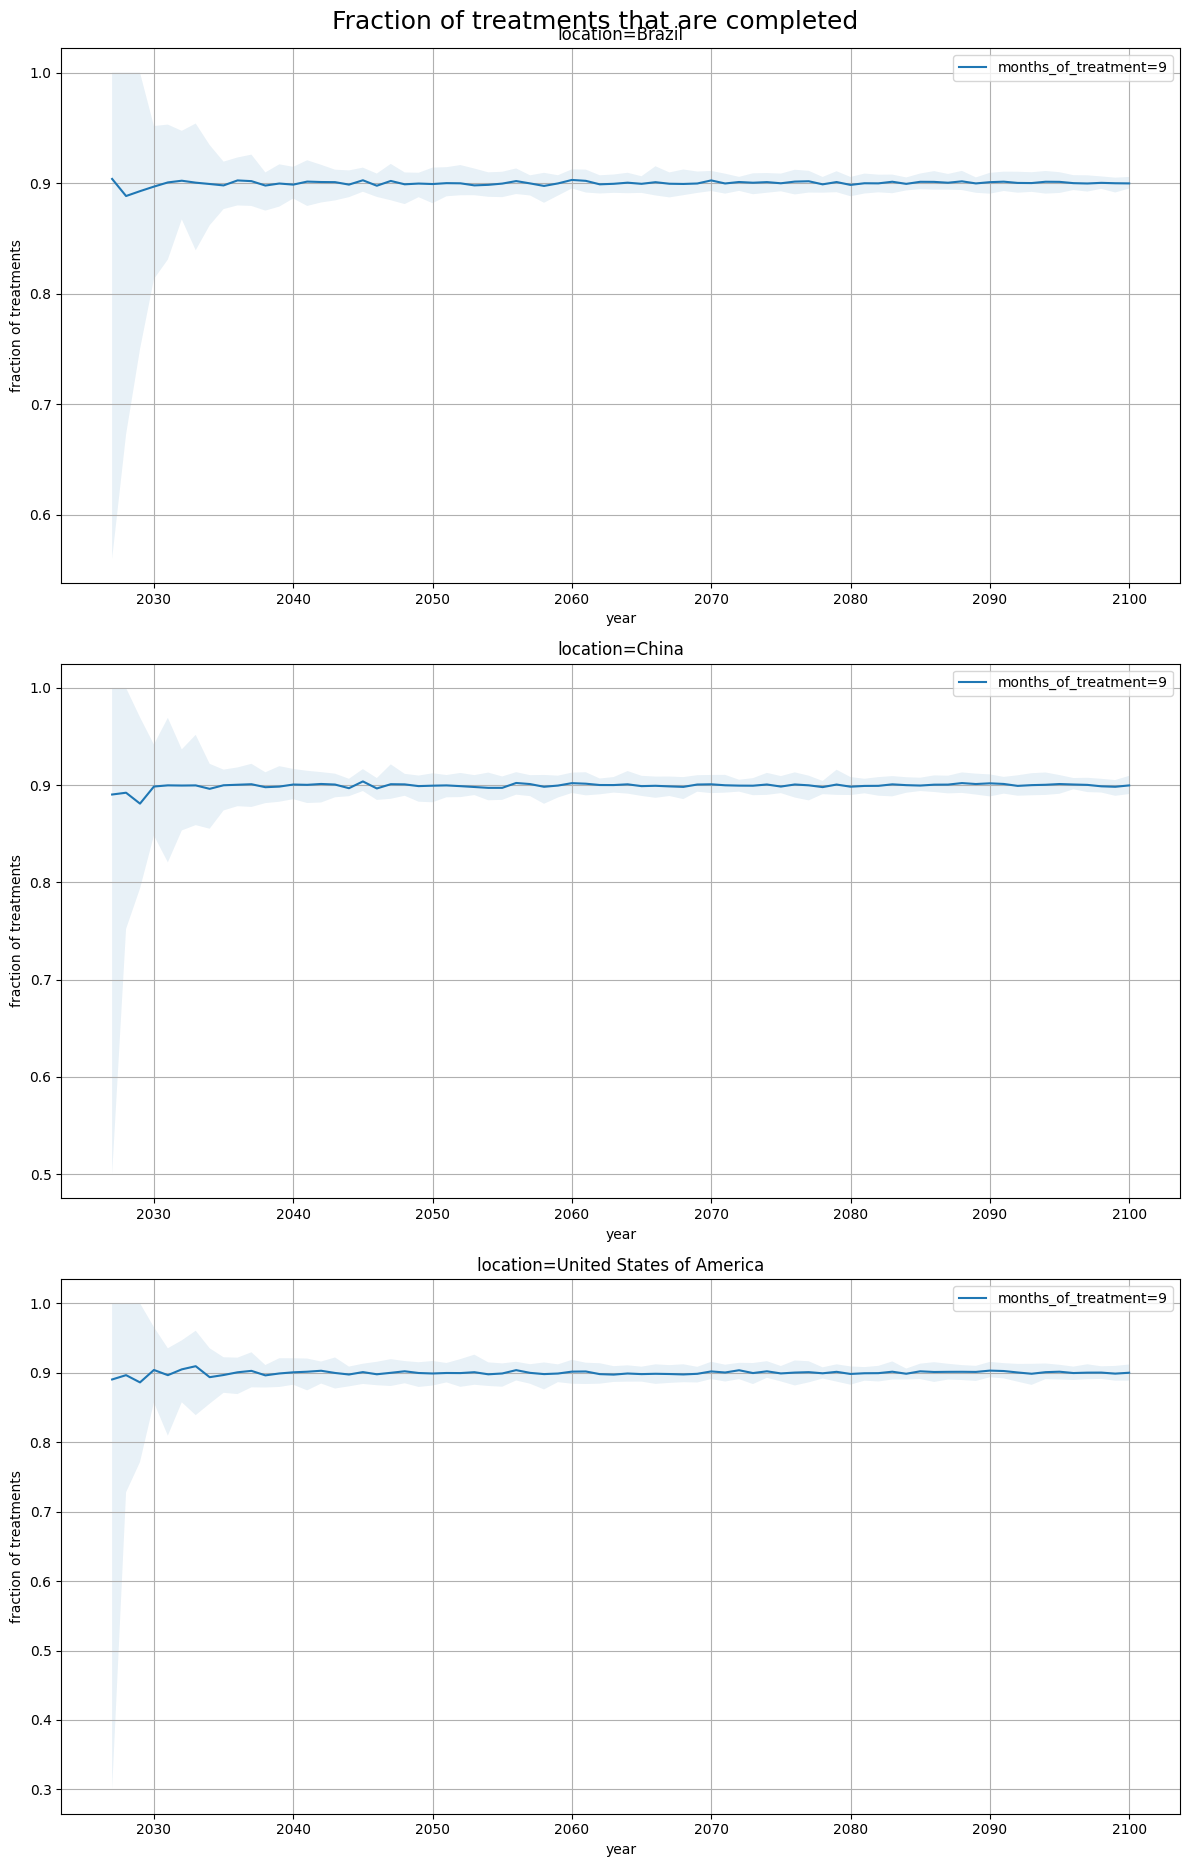

In [67]:
fig = plot_over_time_by_column_for_row_x_1(
    # Sub-entity is the number of months of treatment received
    fraction_among_treated.query("months_of_treatment == 9"),
    'months_of_treatment',
    'location',
    ylabel='fraction of treatments',
    suptitle='Fraction of treatments that are completed',
)
for ax in fig.axes:
    ax.grid(True)

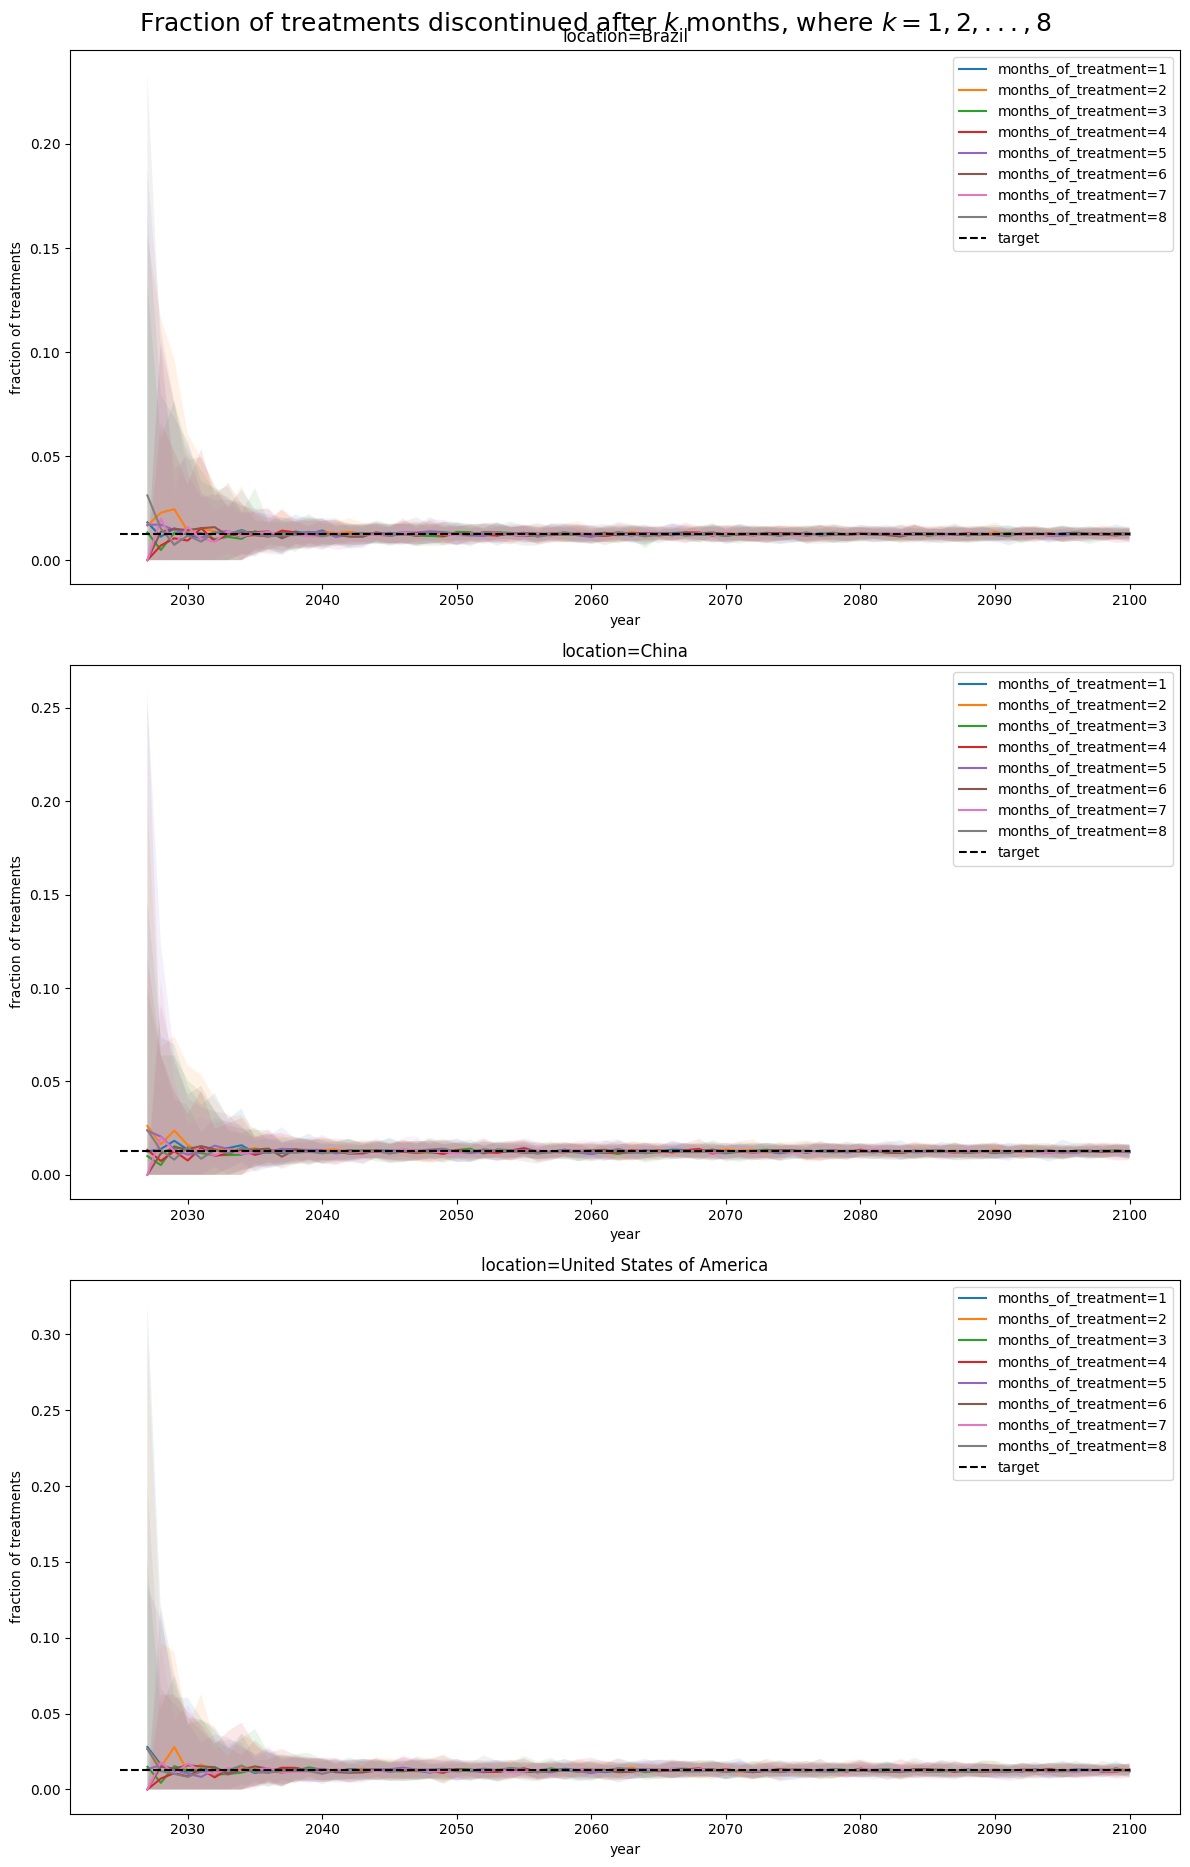

In [68]:
fig = plot_over_time_by_column_for_row_x_1(
    fraction_among_treated.query("months_of_treatment != 9"),
    'months_of_treatment',
    'location',
    ylabel='fraction of treatments',
    suptitle='Fraction of treatments discontinued after $k$ months, where $k=1, 2, ..., 8$',
)
for ax in fig.axes:
    ax.hlines(0.1/8, 2025, 2100, 'black', '--', label='target')
    ax.legend()

## Check fraction of people treated

In [69]:
treated_vs_not = ops.aggregate_categories(
    treatment_duration,
    'sub_entity',
    {'treated': range(1, 10), 'not_treated': 0},
)
treated_vs_not

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1066495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw  \
0        treatment       cause        2022           1   
1        treatment       cause        2022           1   
2        treatment       cause        2022           1   
3        treatment       cause        2022           1   
4        treatment       cause        2022           1   
...            ...         ...         ...         ...   
1066495  treatment       cause        2100         249   
1066496  treatment       cause        2100         249   
1066497  treatment       cause        2100         249   
1066498  treatment       cause        2100         249   
1066499  treatment       cause        2100         249   

                         location                   measure  \
0        United States of America  treatment_duration_count   
1        United States of America  treatment_duration_count   
2        United States of America  treatment_duration_count   
3        United States of America  treatment_duration_count   
4        United States of America  treatment_duration_count   
...                           ...                       ...   
1066495                    Brazil  treatment_duration_count   
1066496                    Brazil  treatment_duration_count   
1066497                    Brazil  treatment_duration_count   
1066498                    Brazil  treatment_duration_count   
1066499                    Brazil  treatment_duration_count   

                           scenario     sex   sub_entity  value  
0                          baseline  Female  not_treated    0.0  
1                          baseline  Female      treated    0.0  
2                          baseline    Male  not_treated    0.0  
3                          baseline    Male      treated    0.0  
4                      bbbm_testing  Female  not_treated    0.0  
...                             ...     ...          ...    ...  
1066495                bbbm_testing    Male      treated    0.0  
1066496  bbbm_testing_and_treatment  Female  not_treated    0.0  
1066497  bbbm_testing_and_treatment  Female      treated    0.0  
1066498  bbbm_testing_and_treatment    Male  not_treated    0.0  
1066499  bbbm_testing_and_treatment    Male      treated    0.0  

[1066500 rows x 12 columns]

In [70]:
fraction_treated = ops.ratio(
    treated_vs_not,
    treated_vs_not,
    strata=['event_year'],
    numerator_broadcast='sub_entity',
    prefilter_query=f"age_group in {testing_eligible_age_groups}",
)
fraction_treated


event_year   sub_entity  input_draw                    scenario  \
0            2022  not_treated           1                    baseline   
1            2022      treated           1                    baseline   
2            2022  not_treated           1                    baseline   
3            2022      treated           1                    baseline   
4            2022  not_treated           1                    baseline   
...           ...          ...         ...                         ...   
35545        2100      treated         249  bbbm_testing_and_treatment   
35546        2100  not_treated         249  bbbm_testing_and_treatment   
35547        2100      treated         249  bbbm_testing_and_treatment   
35548        2100  not_treated         249  bbbm_testing_and_treatment   
35549        2100      treated         249  bbbm_testing_and_treatment   

                       location  value         numerator_measure  \
0                        Brazil    NaN  treatment_duration_count   
1                        Brazil    NaN  treatment_duration_count   
2                         China    NaN  treatment_duration_count   
3                         China    NaN  treatment_duration_count   
4      United States of America    NaN  treatment_duration_count   
...                         ...    ...                       ...   
35545                    Brazil    1.0  treatment_duration_count   
35546                     China    0.0  treatment_duration_count   
35547                     China    1.0  treatment_duration_count   
35548  United States of America    0.0  treatment_duration_count   
35549  United States of America    1.0  treatment_duration_count   

            denominator_measure  multiplier  
0      treatment_duration_count           1  
1      treatment_duration_count           1  
2      treatment_duration_count           1  
3      treatment_duration_count           1  
4      treatment_duration_count           1  
...                         ...         ...  
35545  treatment_duration_count           1  
35546  treatment_duration_count           1  
35547  treatment_duration_count           1  
35548  treatment_duration_count           1  
35549  treatment_duration_count           1  

[35550 rows x 9 columns]

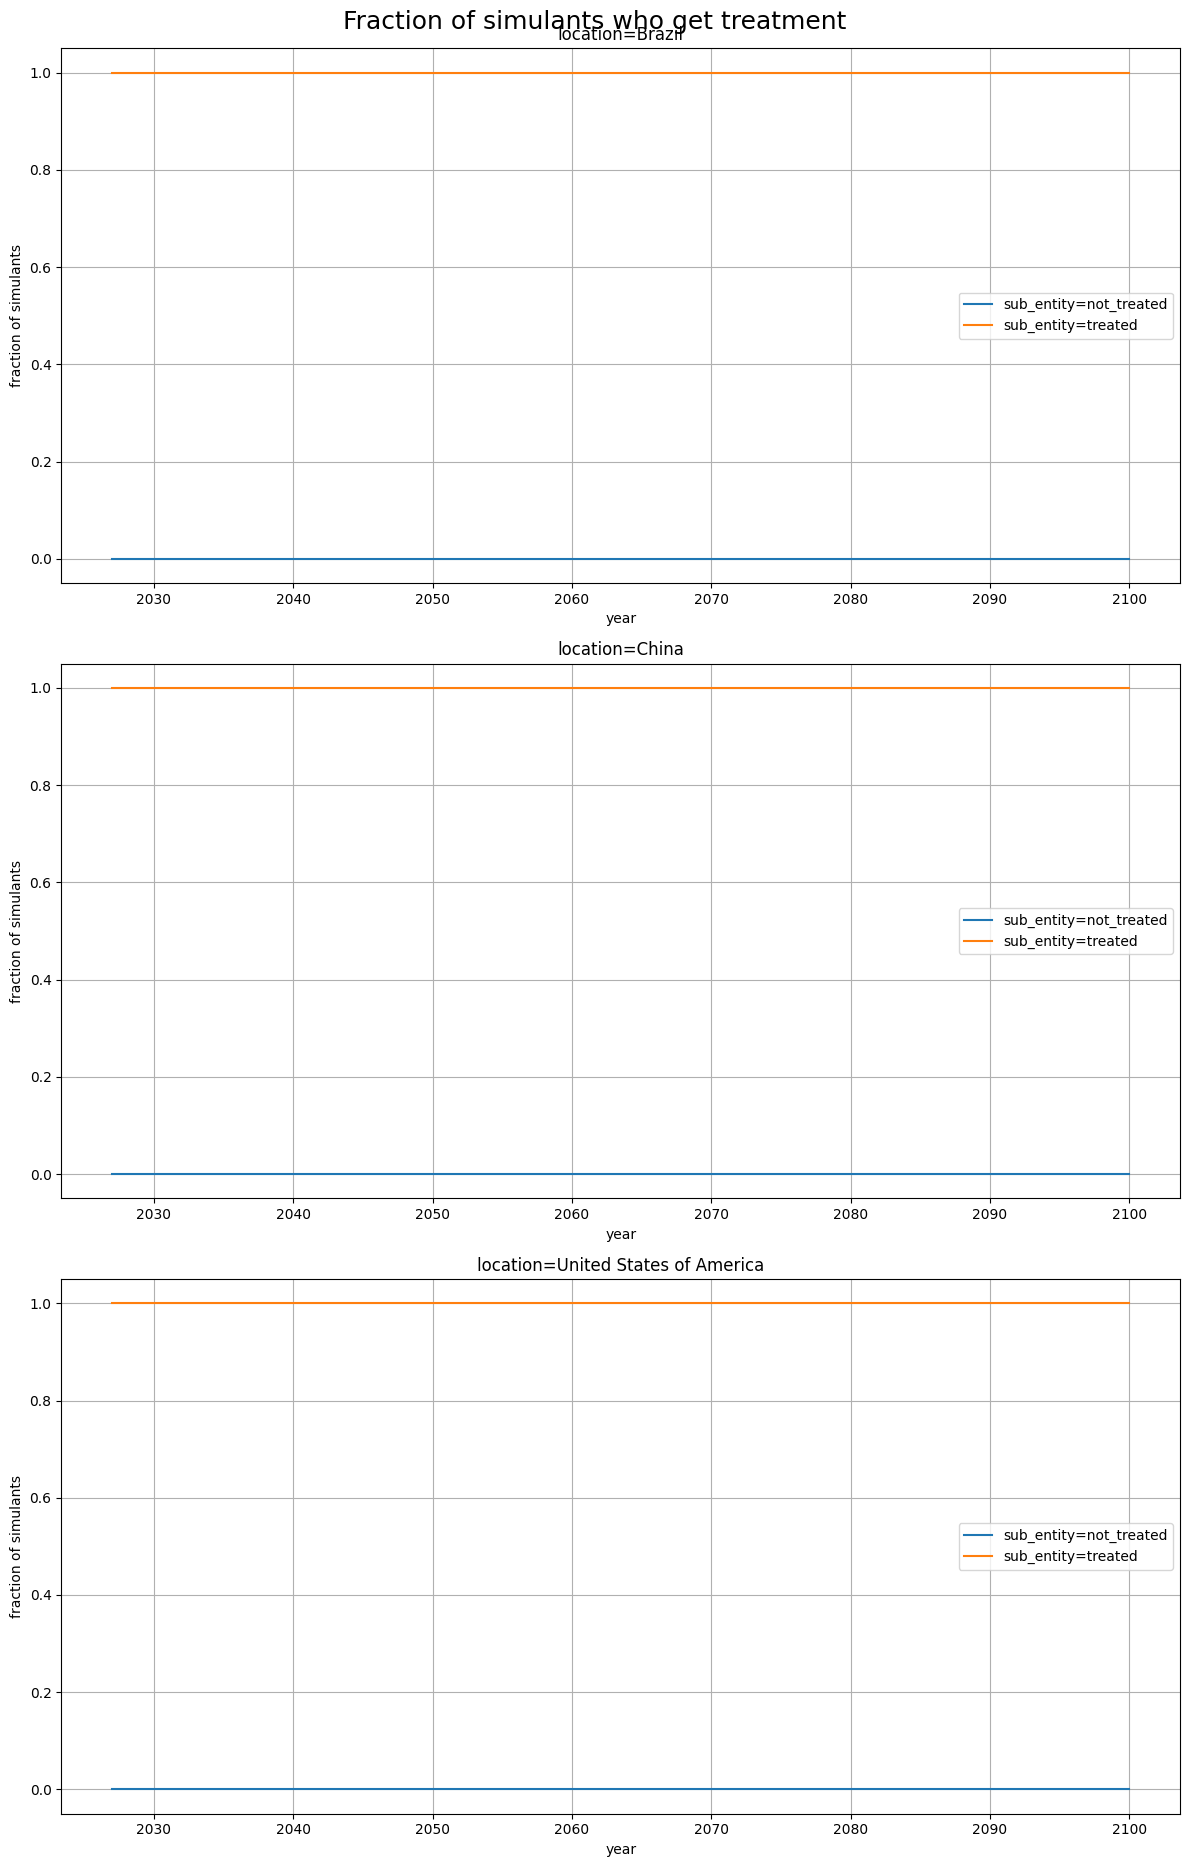

In [71]:
fig = plot_over_time_by_column_for_row_x_1(
    fraction_treated,
    'sub_entity',
    'location',
    ylabel='fraction of simulants',
    suptitle='Fraction of simulants who get treatment',
)
for ax in fig.axes:
    ax.grid(True)

In [72]:
treatment_duration.query("event_year>=2050").groupby('sub_entity')['value'].sum()

sub_entity
0          0.0
1     116493.0
2     117492.0
3     116335.0
4     116627.0
5     115618.0
6     116586.0
7     116618.0
8     115791.0
9    8395406.0
Name: value, dtype: float64

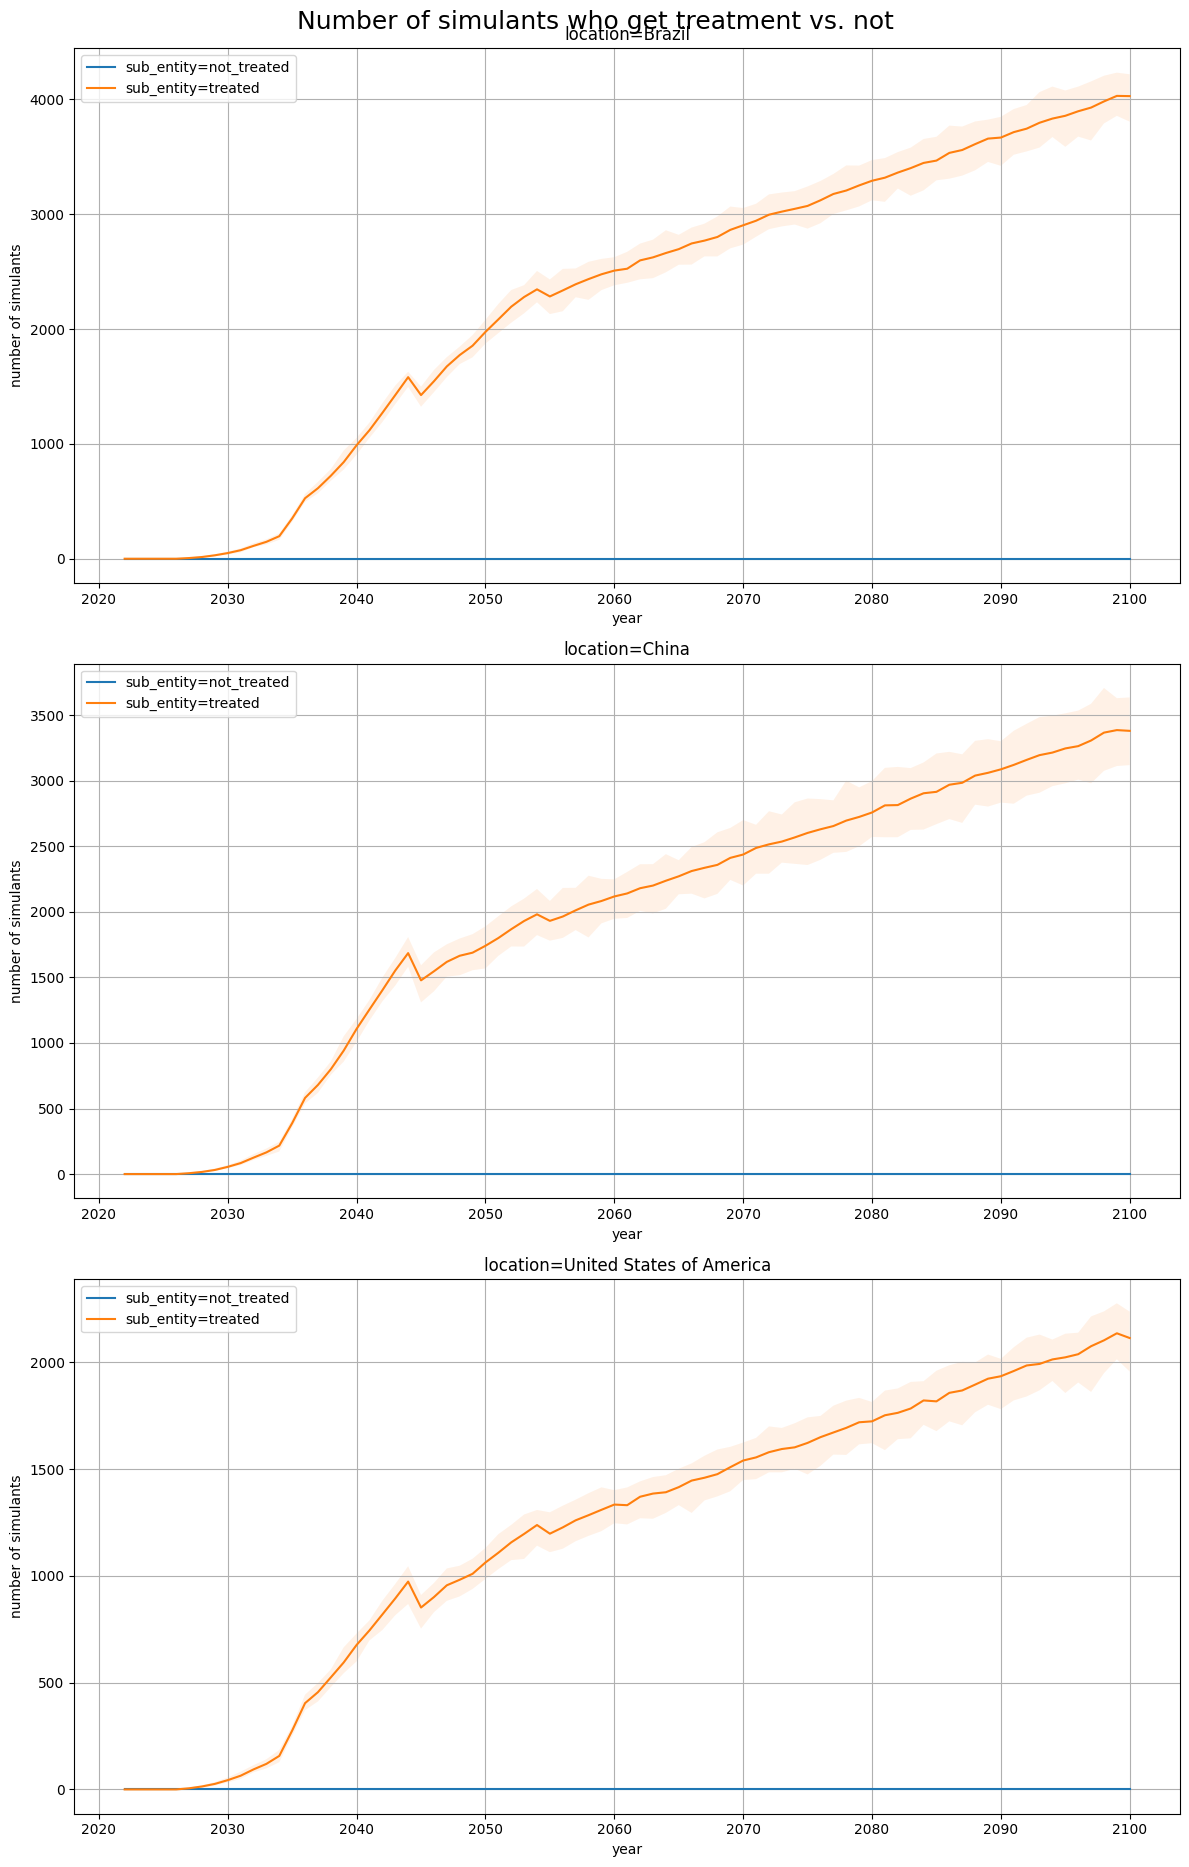

In [180]:
fig = plot_over_time_by_column_for_row_x_1(
    ops.stratify(treated_vs_not.query("scenario == 'bbbm_testing_and_treatment'"), ['sub_entity', 'event_year']),
    # ops.stratify(treatment_duration,)
    'sub_entity',
    'location',
    uncertainty=True,
    ylabel='number of simulants',
    suptitle='Number of simulants who get treatment vs. not',
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()

In [170]:
treatment_duration

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
5332495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
5332499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw  \
0        treatment       cause        2022           1   
1        treatment       cause        2022           1   
2        treatment       cause        2022           1   
3        treatment       cause        2022           1   
4        treatment       cause        2022           1   
...            ...         ...         ...         ...   
5332495  treatment       cause        2100         249   
5332496  treatment       cause        2100         249   
5332497  treatment       cause        2100         249   
5332498  treatment       cause        2100         249   
5332499  treatment       cause        2100         249   

                          measure                    scenario     sex  \
0        treatment_duration_count                    baseline  Female   
1        treatment_duration_count                    baseline  Female   
2        treatment_duration_count                    baseline  Female   
3        treatment_duration_count                    baseline  Female   
4        treatment_duration_count                    baseline  Female   
...                           ...                         ...     ...   
5332495  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332496  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332497  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332498  treatment_duration_count  bbbm_testing_and_treatment    Male   
5332499  treatment_duration_count  bbbm_testing_and_treatment    Male   

         sub_entity  value                  location  
0                 0    0.0  United States of America  
1                 1    0.0  United States of America  
2                 2    0.0  United States of America  
3                 3    0.0  United States of America  
4                 4    0.0  United States of America  
...             ...    ...                       ...  
5332495           5    0.0                    Brazil  
5332496           6    0.0                    Brazil  
5332497           7    0.0                    Brazil  
5332498           8    0.0                    Brazil  
5332499           9    0.0                    Brazil  

[5332500 rows x 12 columns]

In [176]:
ops.stratify(treated_vs_not, ['sub_entity', 'event_year'])

sub_entity  event_year  input_draw                    scenario  \
0      not_treated        2022           1                    baseline   
1      not_treated        2022           1                    baseline   
2      not_treated        2022           1                    baseline   
3      not_treated        2022           1                bbbm_testing   
4      not_treated        2022           1                bbbm_testing   
...            ...         ...         ...                         ...   
35545      treated        2100         249                bbbm_testing   
35546      treated        2100         249                bbbm_testing   
35547      treated        2100         249  bbbm_testing_and_treatment   
35548      treated        2100         249  bbbm_testing_and_treatment   
35549      treated        2100         249  bbbm_testing_and_treatment   

                       location   value  
0                        Brazil     0.0  
1                         China     0.0  
2      United States of America     0.0  
3                        Brazil     0.0  
4                         China     0.0  
...                         ...     ...  
35545                     China     0.0  
35546  United States of America     0.0  
35547                    Brazil  4038.0  
35548                     China  3397.0  
35549  United States of America  2067.0  

[35550 rows x 6 columns]

In [169]:
ops.stratify(treatment_duration, ['event_year'])

event_year  input_draw                    scenario  \
0            2022           1                    baseline   
1            2022           1                    baseline   
2            2022           1                    baseline   
3            2022           1                bbbm_testing   
4            2022           1                bbbm_testing   
...           ...         ...                         ...   
17770        2100         249                bbbm_testing   
17771        2100         249                bbbm_testing   
17772        2100         249  bbbm_testing_and_treatment   
17773        2100         249  bbbm_testing_and_treatment   
17774        2100         249  bbbm_testing_and_treatment   

                       location   value  
0                        Brazil     0.0  
1                         China     0.0  
2      United States of America     0.0  
3                        Brazil     0.0  
4                         China     0.0  
...                         ...     ...  
17770                     China     0.0  
17771  United States of America     0.0  
17772                    Brazil  4038.0  
17773                     China  3397.0  
17774  United States of America  2067.0  

[17775 rows x 5 columns]

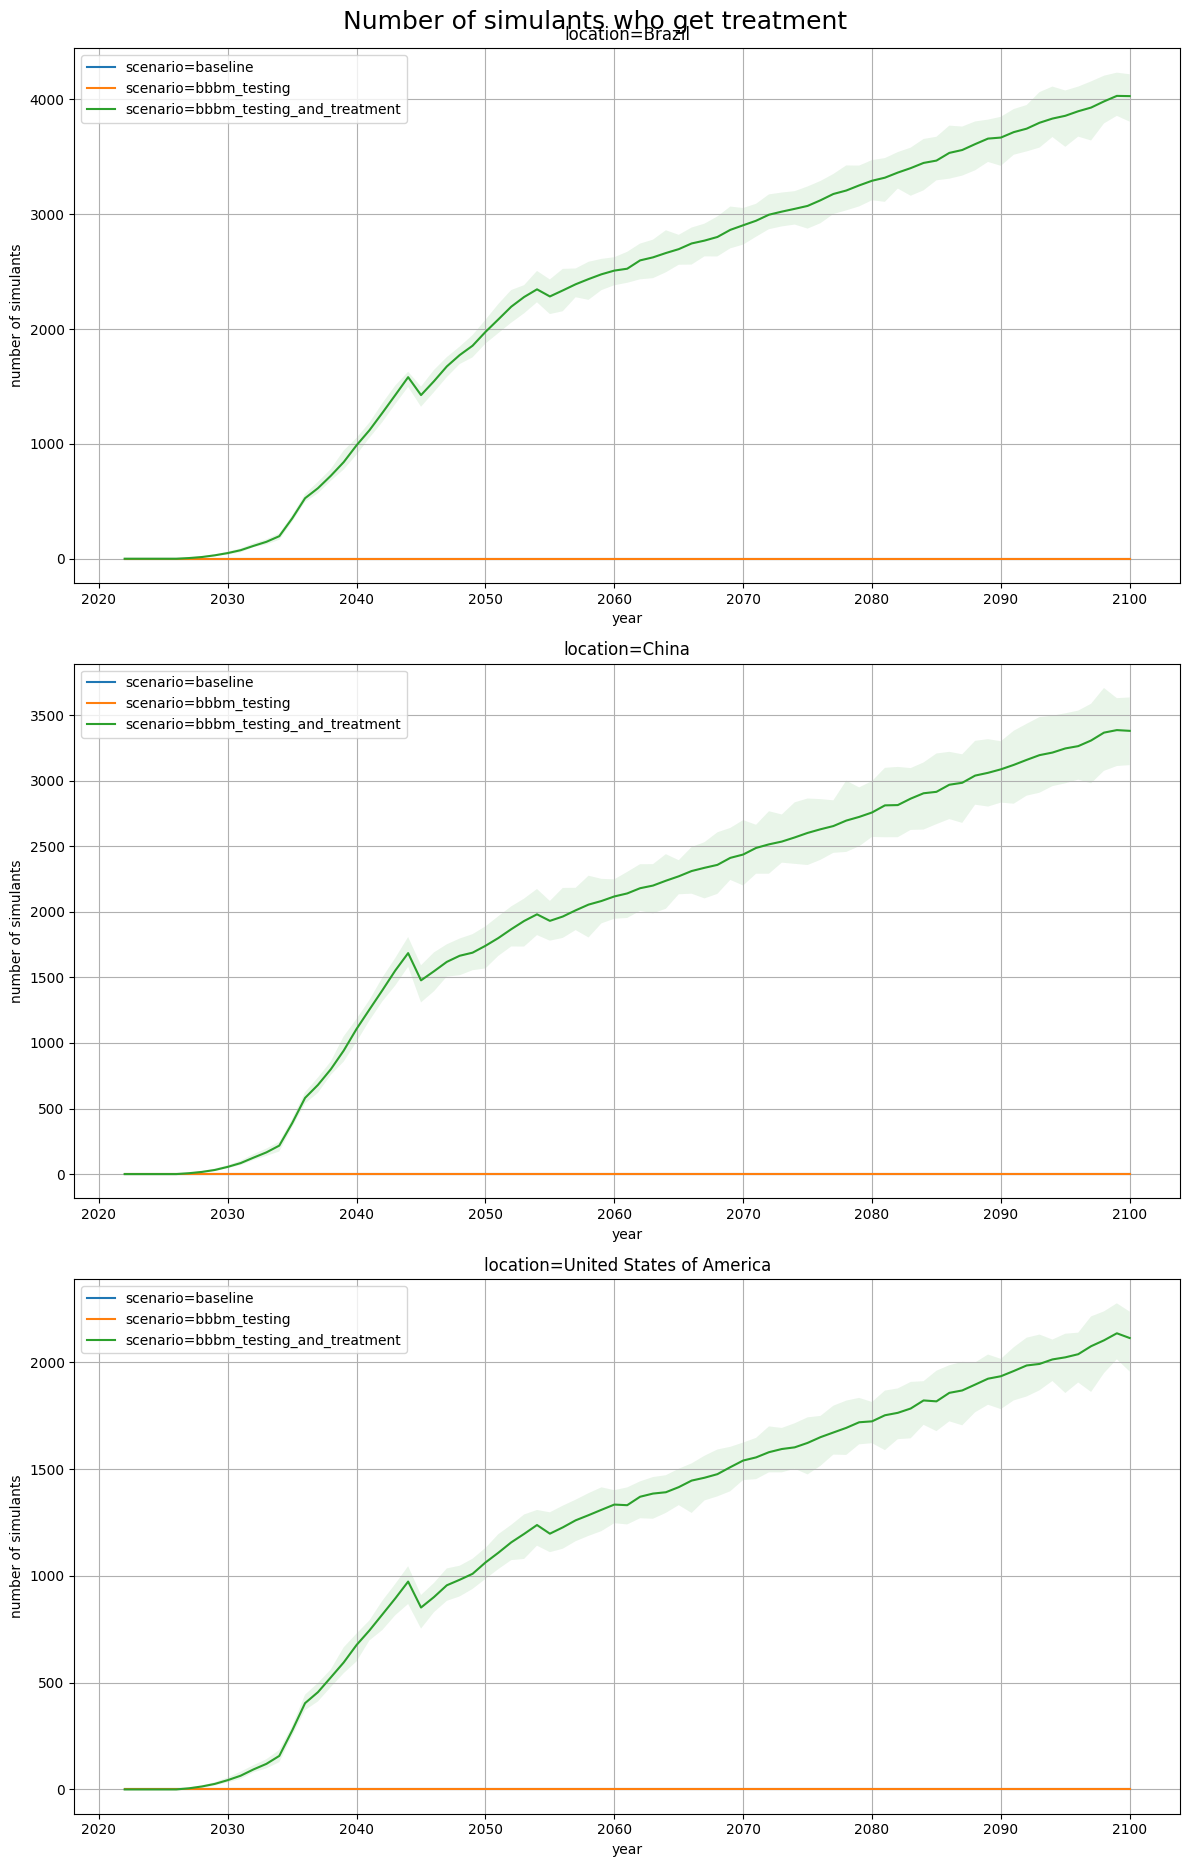

In [183]:
fig = plot_over_time_by_column_for_row_x_1(
    # ops.stratify(treated_vs_not, ['sub_entity', 'event_year']),
    ops.stratify(treatment_duration.query("sub_entity != 0"), ['event_year']).assign(treated='treated'),#.query(
        # "scenario == 'bbbm_testing_and_treatment'"),
    'scenario',
    'location',
    uncertainty=True,
    ylabel='number of simulants',
    suptitle='Number of simulants who get treatment',
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()

In [74]:
treatment_transitions.sub_entity.unique()

['susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'treatment_effect_to_waning_effect', 'waiting_for_treatment_to_treatment_effect', 'waning_effect_to_no_effect_after_treatment']
Categories (5, object): ['susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'treatment_effect_to_waning_effect', 'waiting_for_treatment_to_treatment_effect', 'waning_effect_to_no_effect_after_treatment']

In [75]:
treatment_transitions.value_counts(['from_state', 'to_state'])

from_state                to_state                 
susceptible_to_treatment  no_effect_never_treated      177750
                          waiting_for_treatment        177750
treatment_effect          waning_effect                177750
waiting_for_treatment     treatment_effect             177750
waning_effect             no_effect_after_treatment    177750
Name: count, dtype: int64

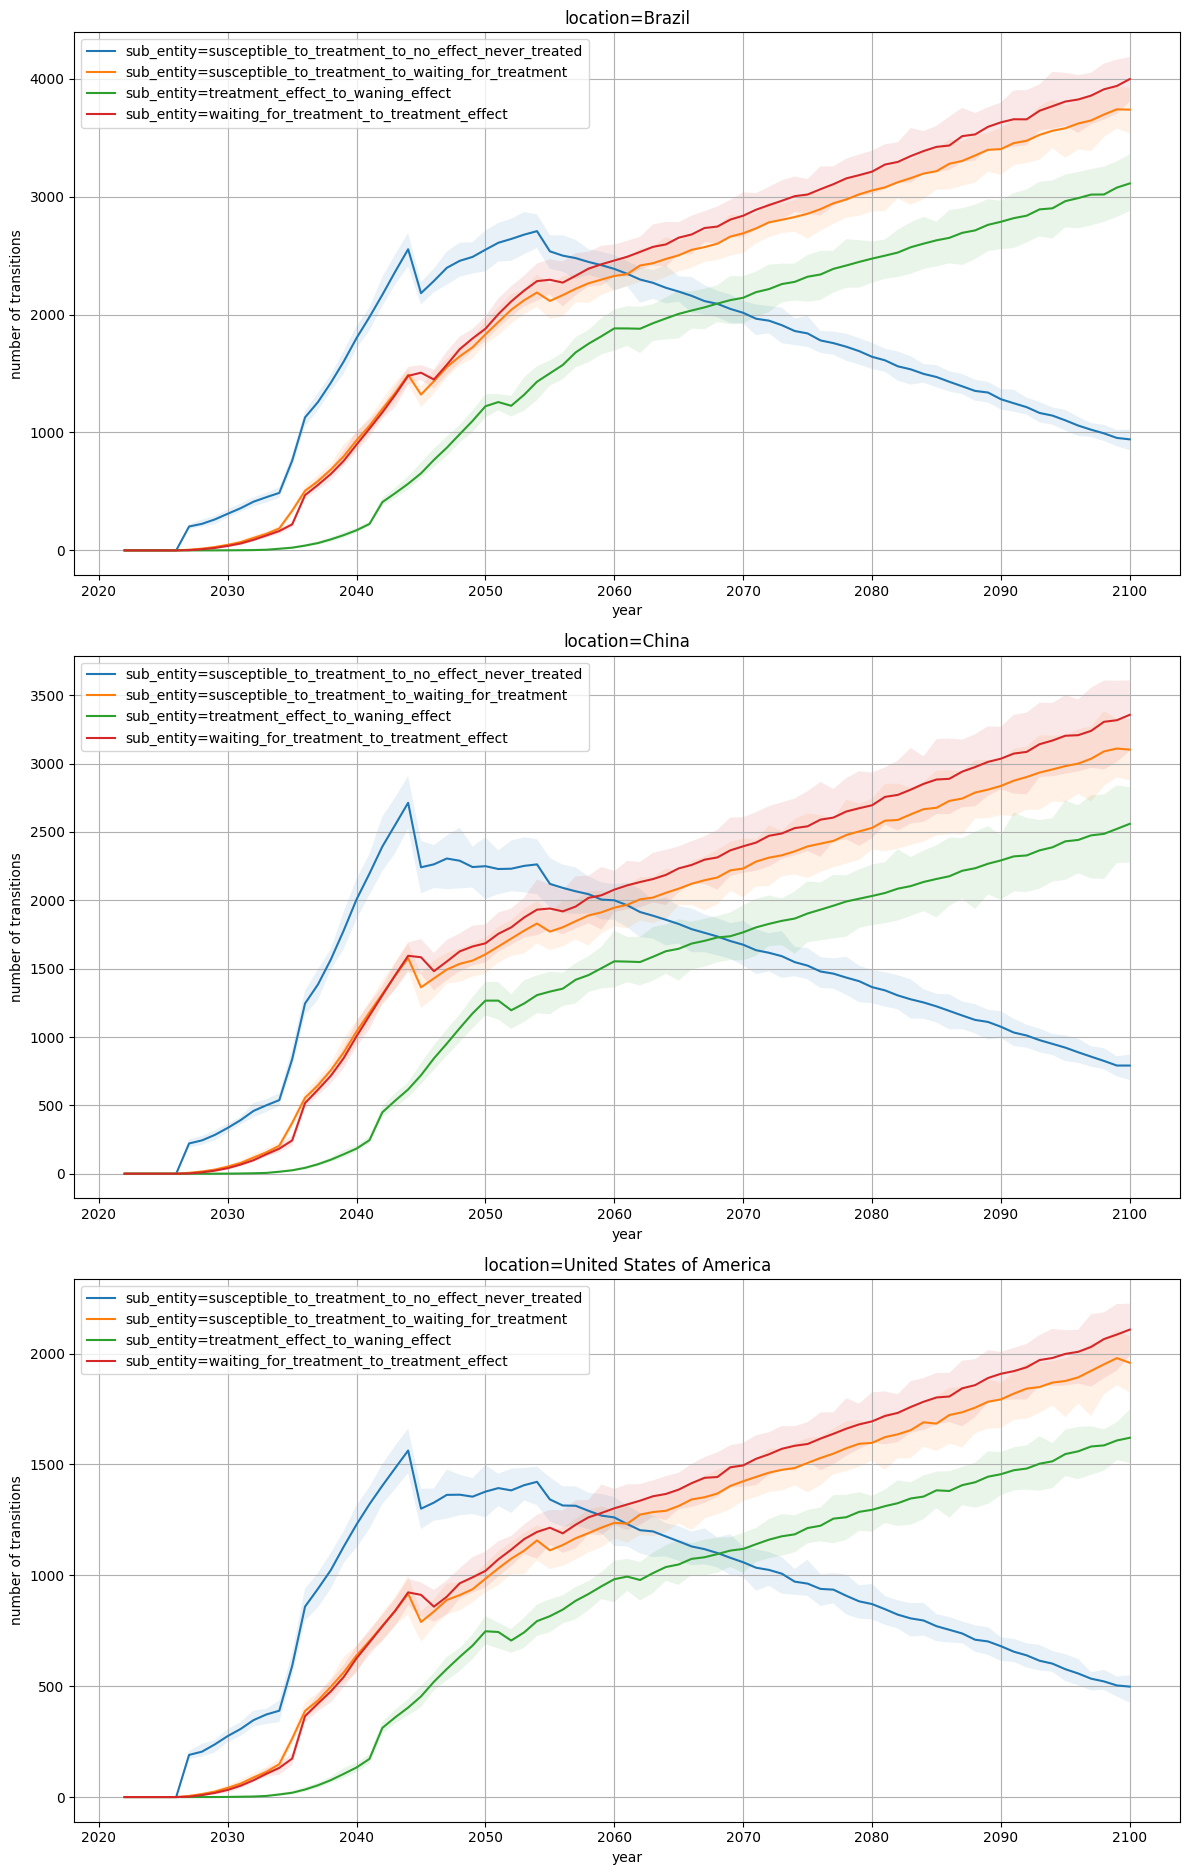

In [76]:
fig = plot_over_time_by_column_for_row_x_1(
    (
        treatment_transitions
        .query(
        # "sub_entity == 'susceptible_to_treatment_to_waiting_for_treatment'"
        "from_state in ['susceptible_to_treatment', 'waiting_for_treatment', 'treatment_effect']")
        .pipe(ops.stratify, ['sub_entity', 'event_year'])
    ),
    'sub_entity',
    'location',
    uncertainty=True,
    ylabel='number of transitions',
    # suptitle='Number of simulants who get treatment vs. not',
)
for ax in fig.axes:
    # ax.semilogy()
    ax.grid(True)

## Old version of Check #2

In [77]:
treatment_transitions.from_state.unique()

['susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']
Categories (4, object): ['susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [78]:
# This gives the fraction of the total transitions out of
# 'waiting_for_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

to_state  input_draw                    scenario  \
0   treatment_effect           1  bbbm_testing_and_treatment   
1   treatment_effect           1  bbbm_testing_and_treatment   
2   treatment_effect           1  bbbm_testing_and_treatment   
3   treatment_effect           6  bbbm_testing_and_treatment   
4   treatment_effect           6  bbbm_testing_and_treatment   
..               ...         ...                         ...   
70  treatment_effect         248  bbbm_testing_and_treatment   
71  treatment_effect         248  bbbm_testing_and_treatment   
72  treatment_effect         249  bbbm_testing_and_treatment   
73  treatment_effect         249  bbbm_testing_and_treatment   
74  treatment_effect         249  bbbm_testing_and_treatment   

                    location  value numerator_measure denominator_measure  \
0                     Brazil    1.0  transition_count    transition_count   
1                      China    1.0  transition_count    transition_count   
2   United States of America    1.0  transition_count    transition_count   
3                     Brazil    1.0  transition_count    transition_count   
4                      China    1.0  transition_count    transition_count   
..                       ...    ...               ...                 ...   
70                     China    1.0  transition_count    transition_count   
71  United States of America    1.0  transition_count    transition_count   
72                    Brazil    1.0  transition_count    transition_count   
73                     China    1.0  transition_count    transition_count   
74  United States of America    1.0  transition_count    transition_count   

    multiplier  
0            1  
1            1  
2            1  
3            1  
4            1  
..         ...  
70           1  
71           1  
72           1  
73           1  
74           1  

[75 rows x 8 columns]

In [79]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [80]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

Empty DataFrame
Columns: [input_draw, scenario, location, value, numerator_measure, denominator_measure, multiplier]
Index: []

In [81]:
# NOTE: ops.describe explicitly calculates uncertainty over
# ops.draw_col, so setting the draw column to 'random_seed' makes this
# work. Another option would be to allow passing in the "uncertainty"
# column instead of always assuming it's the input draw.
summarize_sim_data(complete_to_discontinue_ratio)

Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

In [82]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                  
transition_count    Brazil                   1          transition_count  bbbm_testing_and_treatment treatment_effect   25.0   
                    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect   25.0   

                                                                                                                       mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                 
transition_count    Brazil                   1          transition_count  bbbm_testing_and_treatment treatment_effect   1.0   
                    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect   1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect   1.0   

                                                                                                                       std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    Brazil                   1          transition_count  bbbm_testing_and_treatment treatment_effect  0.0   
                    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  0.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  0.0   

                                                                                                                       min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    Brazil                   1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       25%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    Brazil                   1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       50%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    Brazil                   1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       75%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    Brazil                   1          transition

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'waiting_for_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'waiting_for_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [83]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [84]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_treatment', 'no_effect_never_treated']

In [85]:
# Compute ratio of person-time in each state to the person-time in the
# "waiting_for_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'waiting_for_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

event_year             sub_entity  input_draw  \
0            2030       treatment_effect           1   
1            2030  waiting_for_treatment           1   
2            2030          waning_effect           1   
3            2030       treatment_effect           1   
4            2030  waiting_for_treatment           1   
...           ...                    ...         ...   
15970        2100  waiting_for_treatment         249   
15971        2100          waning_effect         249   
15972        2100       treatment_effect         249   
15973        2100  waiting_for_treatment         249   
15974        2100          waning_effect         249   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                    Brazil  1.600000   
1      bbbm_testing_and_treatment                    Brazil  1.000000   
2      bbbm_testing_and_treatment                    Brazil  0.000000   
3      bbbm_testing_and_treatment                     China  1.509091   
4      bbbm_testing_and_treatment                     China  1.000000   
...                           ...                       ...       ...   
15970  bbbm_testing_and_treatment                     China  1.000000   
15971  bbbm_testing_and_treatment                     China  9.759420   
15972  bbbm_testing_and_treatment  United States of America  9.432272   
15973  bbbm_testing_and_treatment  United States of America  1.000000   
15974  bbbm_testing_and_treatment  United States of America  9.907431   

      numerator_measure denominator_measure  multiplier  
0           person_time         person_time           1  
1           person_time         person_time           1  
2           person_time         person_time           1  
3           person_time         person_time           1  
4           person_time         person_time           1  
...                 ...                 ...         ...  
15970       person_time         person_time           1  
15971       person_time         person_time           1  
15972       person_time         person_time           1  
15973       person_time         person_time           1  
15974       person_time         person_time           1  

[15975 rows x 9 columns]

In [86]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['waiting_for_treatment', 'duration']
)
tx_state_durations


duration  population_fraction  target_person_time_ratio
sub_entity                                                                    
waiting_for_treatment       0.5                  1.0                       1.0
full_effect_long            5.0                  0.9                       9.0
full_effect_short           0.5                  0.1                       0.1
waning_effect_long          9.0                  0.9                      16.2
waning_effect_short         2.5                  0.1                       0.5

In [87]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                       duration  pop_frac  pt_ratio
sub_entity                                         
waiting_for_treatment       0.5       1.0       1.0
full_effect_long            5.0       0.9       9.0
full_effect_short           0.5       0.1       0.1
waning_effect_long          9.0       0.9      16.2
waning_effect_short         2.5       0.1       0.5


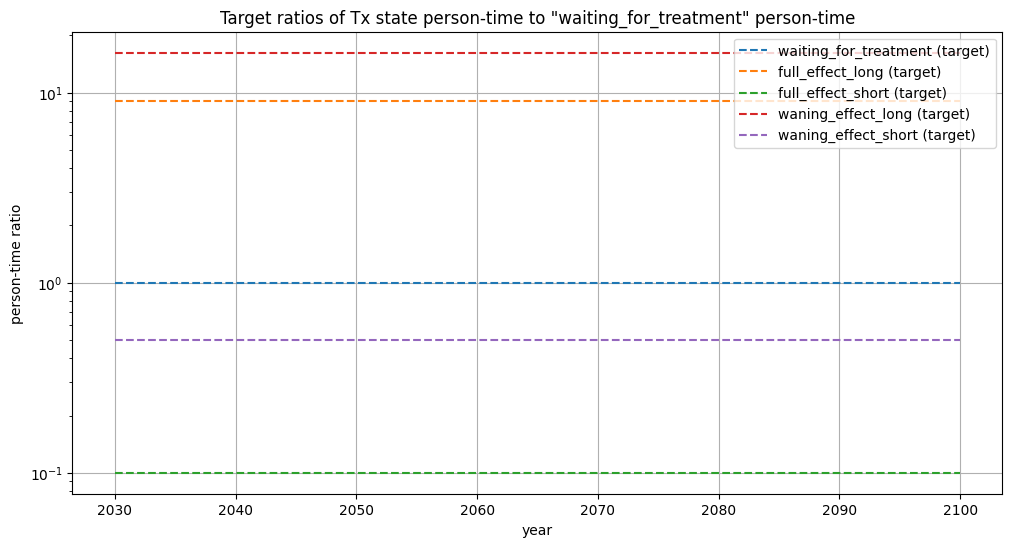

In [88]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "waiting_for_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

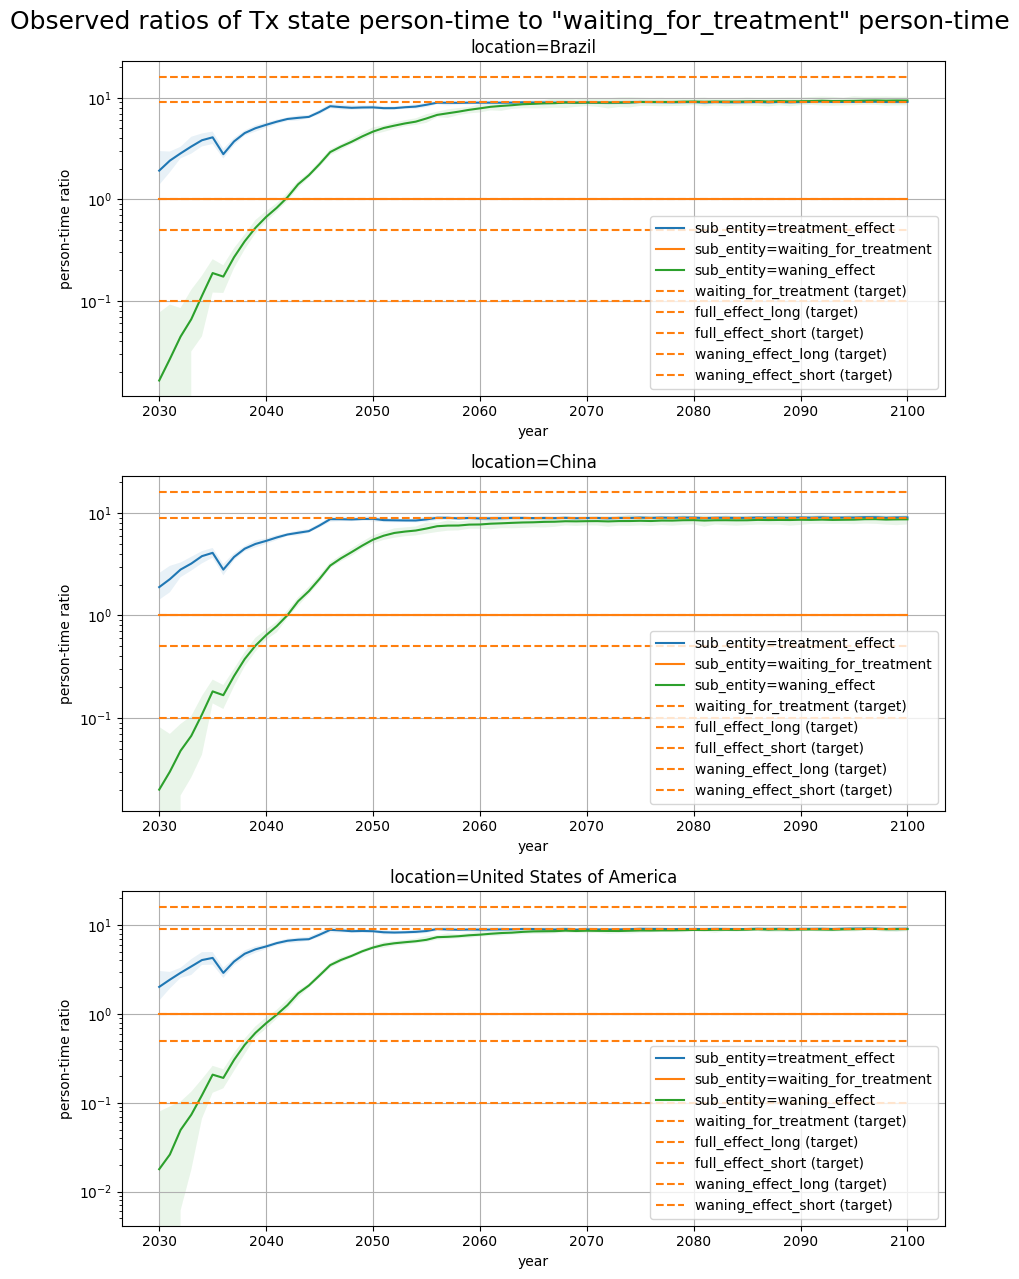

In [89]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "waiting_for_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

In [90]:
tx_person_time_ratios.groupby(['event_year', 'sub_entity'], observed=True)['value'].describe()

count      mean       std       min  \
event_year sub_entity                                                   
2030       treatment_effect        75.0  1.942054  0.460157  1.296296   
           waiting_for_treatment   75.0  1.000000  0.000000  1.000000   
           waning_effect           75.0  0.018107  0.026696  0.000000   
2031       treatment_effect        75.0  2.367846  0.331362  1.662651   
           waiting_for_treatment   75.0  1.000000  0.000000  1.000000   
...                                 ...       ...       ...       ...   
2099       waiting_for_treatment   75.0  1.000000  0.000000  1.000000   
           waning_effect           75.0  9.031587  0.550186  7.383425   
2100       treatment_effect        75.0  9.085395  0.184403  8.666094   
           waiting_for_treatment   75.0  1.000000  0.000000  1.000000   
           waning_effect           75.0  9.035236  0.566189  7.701837   

                                       25%       50%       75%        max  
event_year sub_entity                                                      
2030       treatment_effect       1.600000  1.830189  2.158318   3.700000  
           waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
           waning_effect          0.000000  0.000000  0.032796   0.097561  
2031       treatment_effect       2.121958  2.342466  2.585430   3.344828  
           waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
...                                    ...       ...       ...        ...  
2099       waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
           waning_effect          8.794495  9.044583  9.339317  10.262571  
2100       treatment_effect       8.954888  9.086159  9.210700   9.496332  
           waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
           waning_effect          8.748980  9.057802  9.319261  10.456071  

[213 rows x 8 columns]

## Check values

In [91]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [92]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [93]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

In [94]:
ops.index_cols

['input_draw', 'scenario', 'location']

## Look at actual person-time instead of the ratio

In [95]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'waiting_for_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2050"
            # " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

count  \
event_year location                 scenario                   sub_entity                     
2051       Brazil                   bbbm_testing_and_treatment waiting_for_treatment   25.0   
           China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
2052       Brazil                   bbbm_testing_and_treatment waiting_for_treatment   25.0   
           China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
...                                                                                     ...   
2099       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
2100       Brazil                   bbbm_testing_and_treatment waiting_for_treatment   25.0   
           China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   

                                                                                             mean  \
event_year location                 scenario                   sub_entity                           
2051       Brazil                   bbbm_testing_and_treatment waiting_for_treatment  1118.877700   
           China                    bbbm_testing_and_treatment waiting_for_treatment   980.333470   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   598.584422   
2052       Brazil                   bbbm_testing_and_treatment waiting_for_treatment  1181.462779   
           China                    bbbm_testing_and_treatment waiting_for_treatment  1009.473402   
...                                                                                           ...   
2099       China                    bbbm_testing_and_treatment waiting_for_treatment  1859.275127   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  1166.932676   
2100       Brazil                   bbbm_testing_and_treatment waiting_for_treatment  2234.745736   
           China                    bbbm_testing_and_treatment waiting_for_treatment  1876.954415   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  1176.180917   

                                                                                            std  \
event_year location                 scenario                   sub_entity                         
2051       Brazil                   bbbm_testing_and_treatment waiting_for_treatment  39.066205   
           China                    bbbm_testing_and_treatment waiting_for_treatment  45.731407   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  24.852294   
2052       Brazil                   bbbm_testing_and_treatment waiting_for_treatment  42.932069   
           China                    bbbm_testing_and_treatment waiting_for_treatment  47.400192   
...                                                                                         ...   
2099       China                    bbbm_testing_and_treatment waiting_for_treatment  85.591017   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  47.319367   
2100       Brazil                   bbbm_testing_and_treatment waiting_for_treatment  64.924901   
           China                    bbbm_testing_and_treatment waiting_for_treatment  86.455268   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  40.101955   

                                                                                              min  \
event_year location                 scenario                   sub_entity                           
2051       Brazil                   bbbm_testi

In [96]:
9721.296427 / 1129.481287

8.606868071998433

In [97]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [98]:
person_time_treatment

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw      measure  \
0        treatment       cause        2022           1  person_time   
1        treatment       cause        2022           1  person_time   
2        treatment       cause        2022           1  person_time   
3        treatment       cause        2022           1  person_time   
4        treatment       cause        2022           1  person_time   
...            ...         ...         ...         ...          ...   
3199495  treatment       cause        2100         249  person_time   
3199496  treatment       cause        2100         249  person_time   
3199497  treatment       cause        2100         249  person_time   
3199498  treatment       cause        2100         249  person_time   
3199499  treatment       cause        2100         249  person_time   

                           scenario     sex                 sub_entity  \
0                          baseline  Female  no_effect_after_treatment   
1                          baseline  Female    no_effect_never_treated   
2                          baseline  Female   susceptible_to_treatment   
3                          baseline  Female           treatment_effect   
4                          baseline  Female      waiting_for_treatment   
...                             ...     ...                        ...   
3199495  bbbm_testing_and_treatment    Male    no_effect_never_treated   
3199496  bbbm_testing_and_treatment    Male   susceptible_to_treatment   
3199497  bbbm_testing_and_treatment    Male           treatment_effect   
3199498  bbbm_testing_and_treatment    Male      waiting_for_treatment   
3199499  bbbm_testing_and_treatment    Male              waning_effect   

                value                  location  
0            0.000000  United States of America  
1            0.000000  United States of America  
2            0.000000  United States of America  
3            0.000000  United States of America  
4            0.000000  United States of America  
...               ...                       ...  
3199495    185.363450                    Brazil  
3199496  13787.154004                    Brazil  
3199497      0.000000                    Brazil  
3199498      0.000000                    Brazil  
3199499     39.863107                    Brazil  

[3199500 rows x 12 columns]

In [99]:
treatment_transitions.query("value>0")

age_group                                      artifact_path  \
475250  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
475251  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
475255  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
475256  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
475258  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
888729   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888734   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888739   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888744   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
888749   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type  event_year  input_draw  \
475250  treatment       cause        2027           1   
475251  treatment       cause        2027           1   
475255  treatment       cause        2027           1   
475256  treatment       cause        2027           1   
475258  treatment       cause        2027           1   
...           ...         ...         ...         ...   
888729  treatment       cause        2100         245   
888734  treatment       cause        2100         248   
888739  treatment       cause        2100         248   
888744  treatment       cause        2100         249   
888749  treatment       cause        2100         249   

                        location           measure  \
475250  United States of America  transition_count   
475251  United States of America  transition_count   
475255  United States of America  transition_count   
475256  United States of America  transition_count   
475258  United States of America  transition_count   
...                          ...               ...   
888729                    Brazil  transition_count   
888734                    Brazil  transition_count   
888739                    Brazil  transition_count   
888744                    Brazil  transition_count   
888749                    Brazil  transition_count   

                          scenario     sex  \
475250  bbbm_testing_and_treatment  Female   
475251  bbbm_testing_and_treatment  Female   
475255  bbbm_testing_and_treatment    Male   
475256  bbbm_testing_and_treatment    Male   
475258  bbbm_testing_and_treatment    Male   
...                            ...     ...   
888729  bbbm_testing_and_treatment    Male   
888734  bbbm_testing_and_treatment  Female   
888739  bbbm_testing_and_treatment    Male   
888744  bbbm_testing_and_treatment  Female   
888749  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
475250  susceptible_to_treatment_to_no_effect_never_tr...   27.0   
475251  susceptible_to_treatment_to_waiting_for_treatment    1.0   
475255  susceptible_to_treatment_to_no_effect_never_tr...   10.0   
475256  susceptible_to_treatment_to_waiting_for_treatment    2.0   
475258          waiting_for_treatment_to_treatment_effect    1.0   
...                                                   ...    ...   
888729         waning_effect_to_no_effect_after_treatment   12.0   
888734         waning_effect_to_no_effect_after_treatment   14.0   
888739         waning_effect_to_no_effect_after_treatment    3.0   
888744         waning_effect_to_no_effect_after_treatment   85.0   
888749         waning_effect_to_no_effect_after_treatment   25.0   

                      from_state                   to_state  
475250  susceptible_to_treatment    no_effect_never_treated  
475251  susceptible_to_treatment      waiting_for_treatment  
475255  susceptible_to_treatment    no_effect_never_treated  
475256  susceptible_to_treatment      waiting_for_treatment  
475258     waiting_for_treatment           treatment_effect  
...                          ...                        ...  
888729          

In [100]:
person_time_treatment.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
measure          category
scenario         category
sex              category
sub_entity       category
value             float64
location         category
dtype: object

In [101]:
treatment_transitions.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
location         category
measure          category
scenario         category
sex              category
sub_entity       category
value             float64
from_state       category
to_state         category
dtype: object

In [102]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

event_year                   to_state  input_draw  \
0            2030  no_effect_after_treatment           1   
1            2030  no_effect_after_treatment           1   
2            2030  no_effect_after_treatment           1   
3            2030  no_effect_after_treatment           6   
4            2030  no_effect_after_treatment           6   
...           ...                        ...         ...   
31945        2100              waning_effect         248   
31946        2100              waning_effect         248   
31947        2100              waning_effect         249   
31948        2100              waning_effect         249   
31949        2100              waning_effect         249   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                    Brazil       NaN   
1      bbbm_testing_and_treatment                     China       NaN   
2      bbbm_testing_and_treatment  United States of America       NaN   
3      bbbm_testing_and_treatment                    Brazil       NaN   
4      bbbm_testing_and_treatment                     China       NaN   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment                     China  5.999461   
31946  bbbm_testing_and_treatment  United States of America  6.154103   
31947  bbbm_testing_and_treatment                    Brazil  7.057999   
31948  bbbm_testing_and_treatment                     China  6.674548   
31949  bbbm_testing_and_treatment  United States of America  6.598227   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

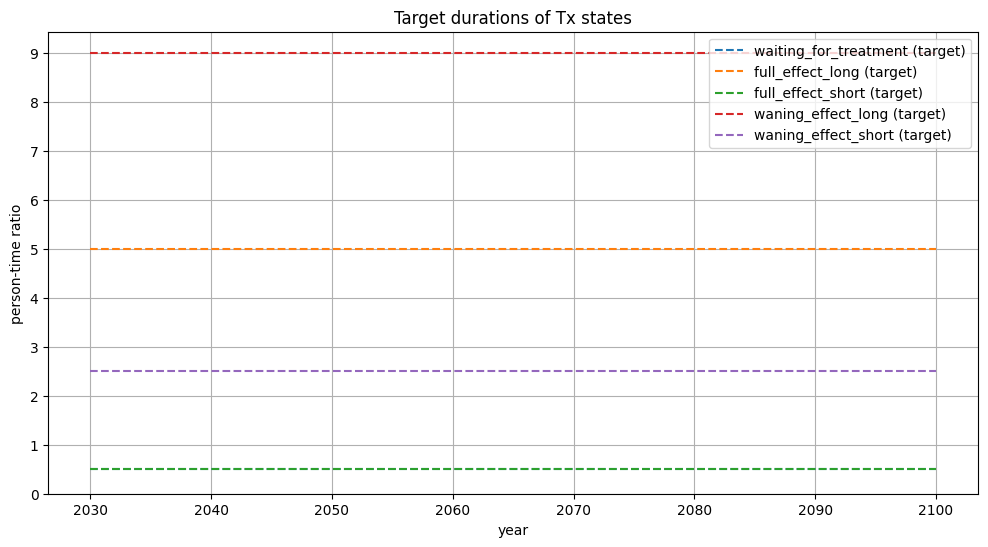

In [103]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

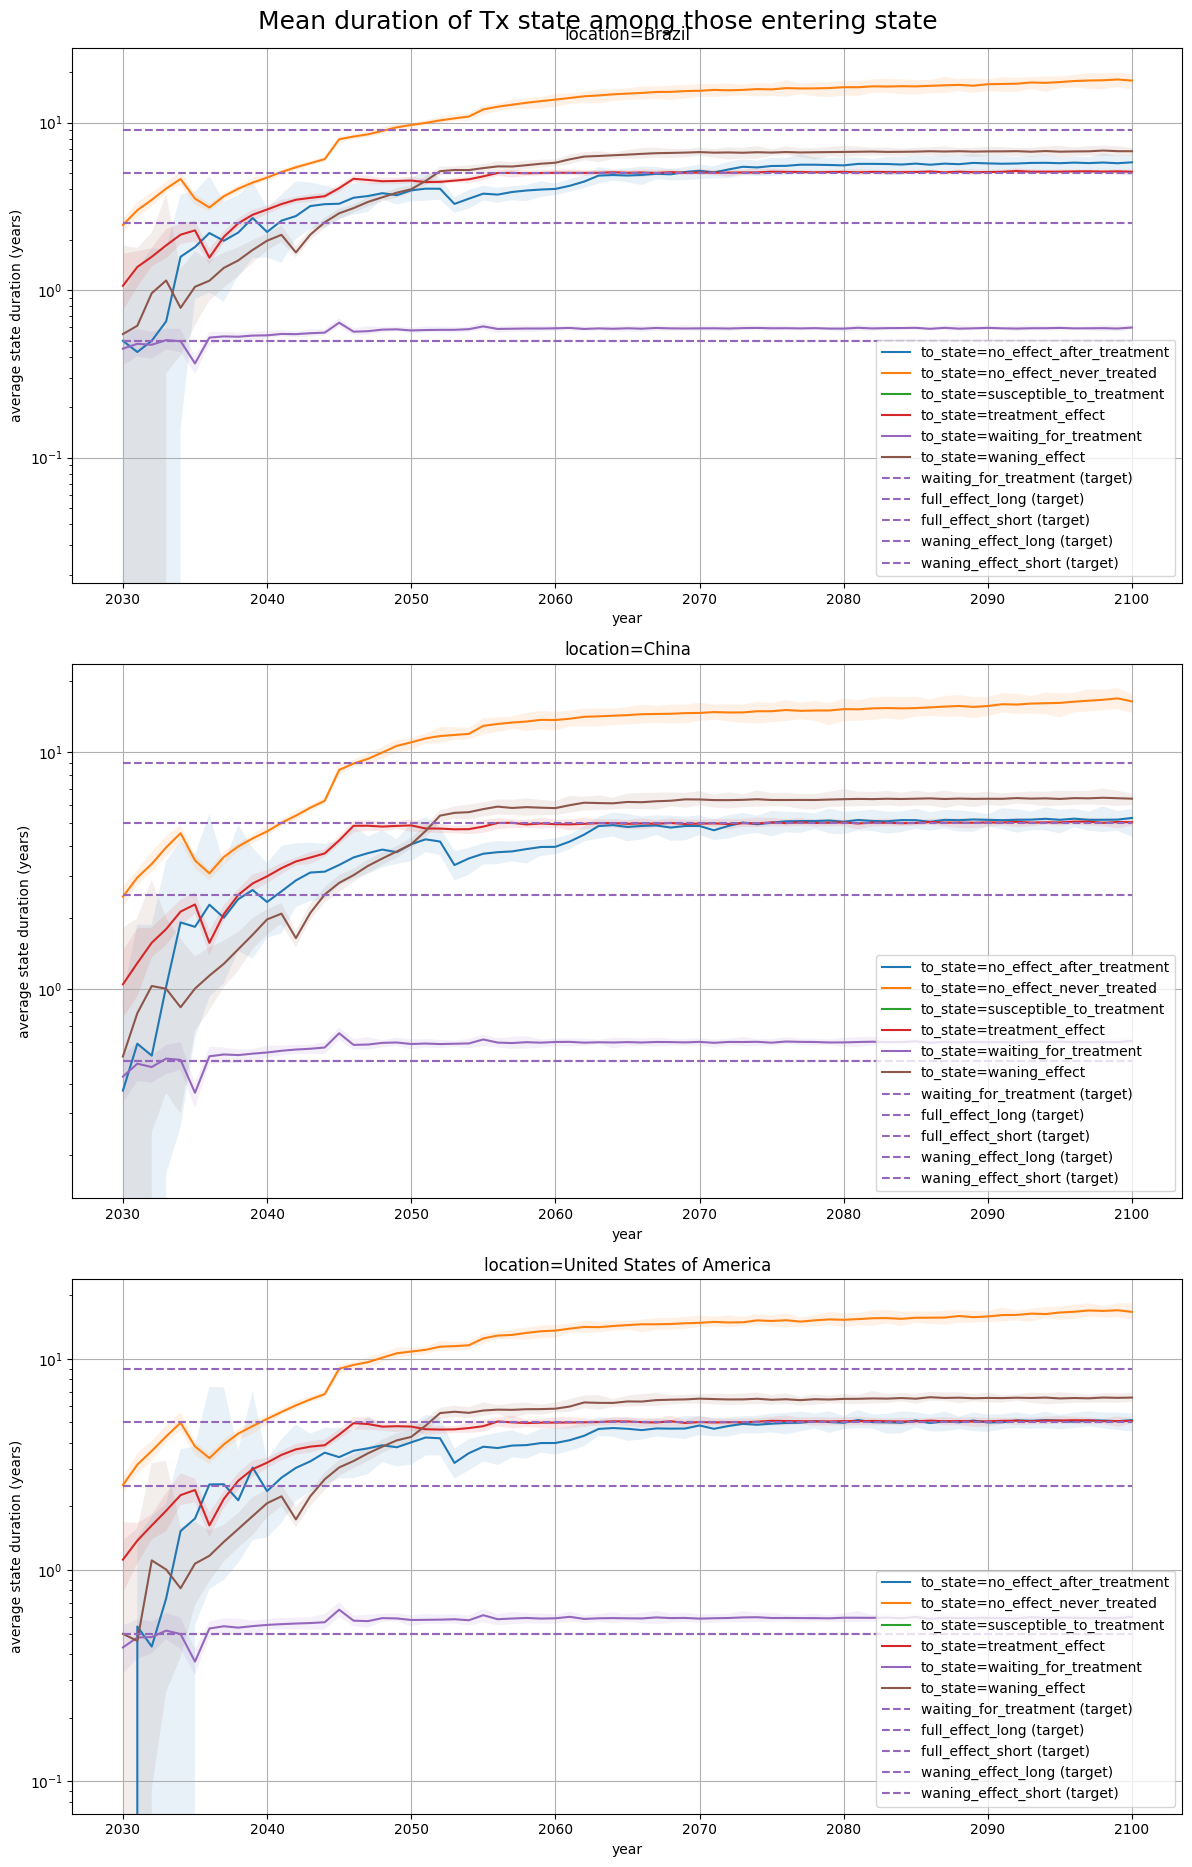

In [104]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [105]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

event_year                 from_state  input_draw  \
0            2030  no_effect_after_treatment           1   
1            2030  no_effect_after_treatment           1   
2            2030  no_effect_after_treatment           1   
3            2030  no_effect_after_treatment           6   
4            2030  no_effect_after_treatment           6   
...           ...                        ...         ...   
31945        2100              waning_effect         248   
31946        2100              waning_effect         248   
31947        2100              waning_effect         249   
31948        2100              waning_effect         249   
31949        2100              waning_effect         249   

                         scenario                  location      value  \
0      bbbm_testing_and_treatment                    Brazil        NaN   
1      bbbm_testing_and_treatment                     China        NaN   
2      bbbm_testing_and_treatment  United States of America        NaN   
3      bbbm_testing_and_treatment                    Brazil        NaN   
4      bbbm_testing_and_treatment                     China        NaN   
...                           ...                       ...        ...   
31945  bbbm_testing_and_treatment                     China  21.419352   
31946  bbbm_testing_and_treatment  United States of America  20.578541   
31947  bbbm_testing_and_treatment                    Brazil  17.265508   
31948  bbbm_testing_and_treatment                     China  18.755207   
31949  bbbm_testing_and_treatment  United States of America  20.079577   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

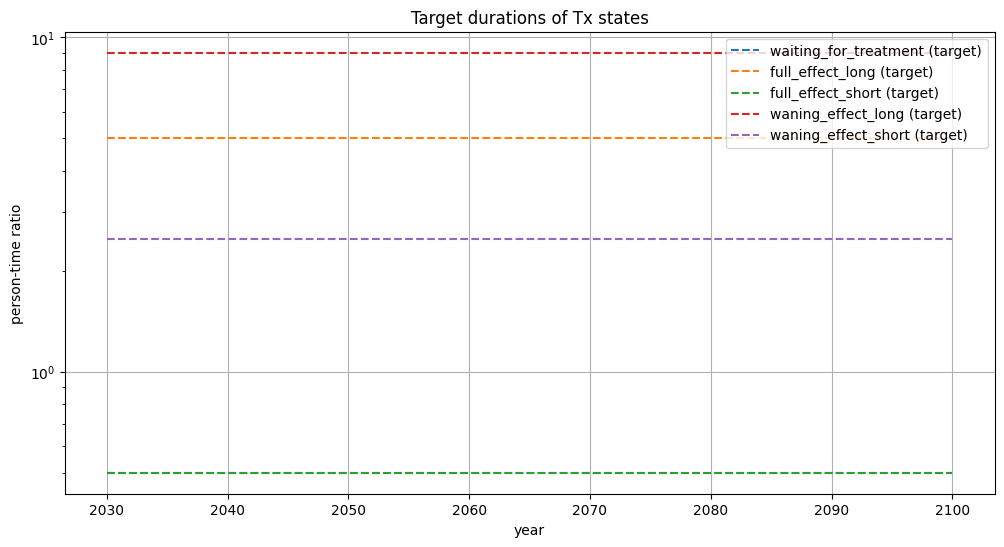

In [106]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

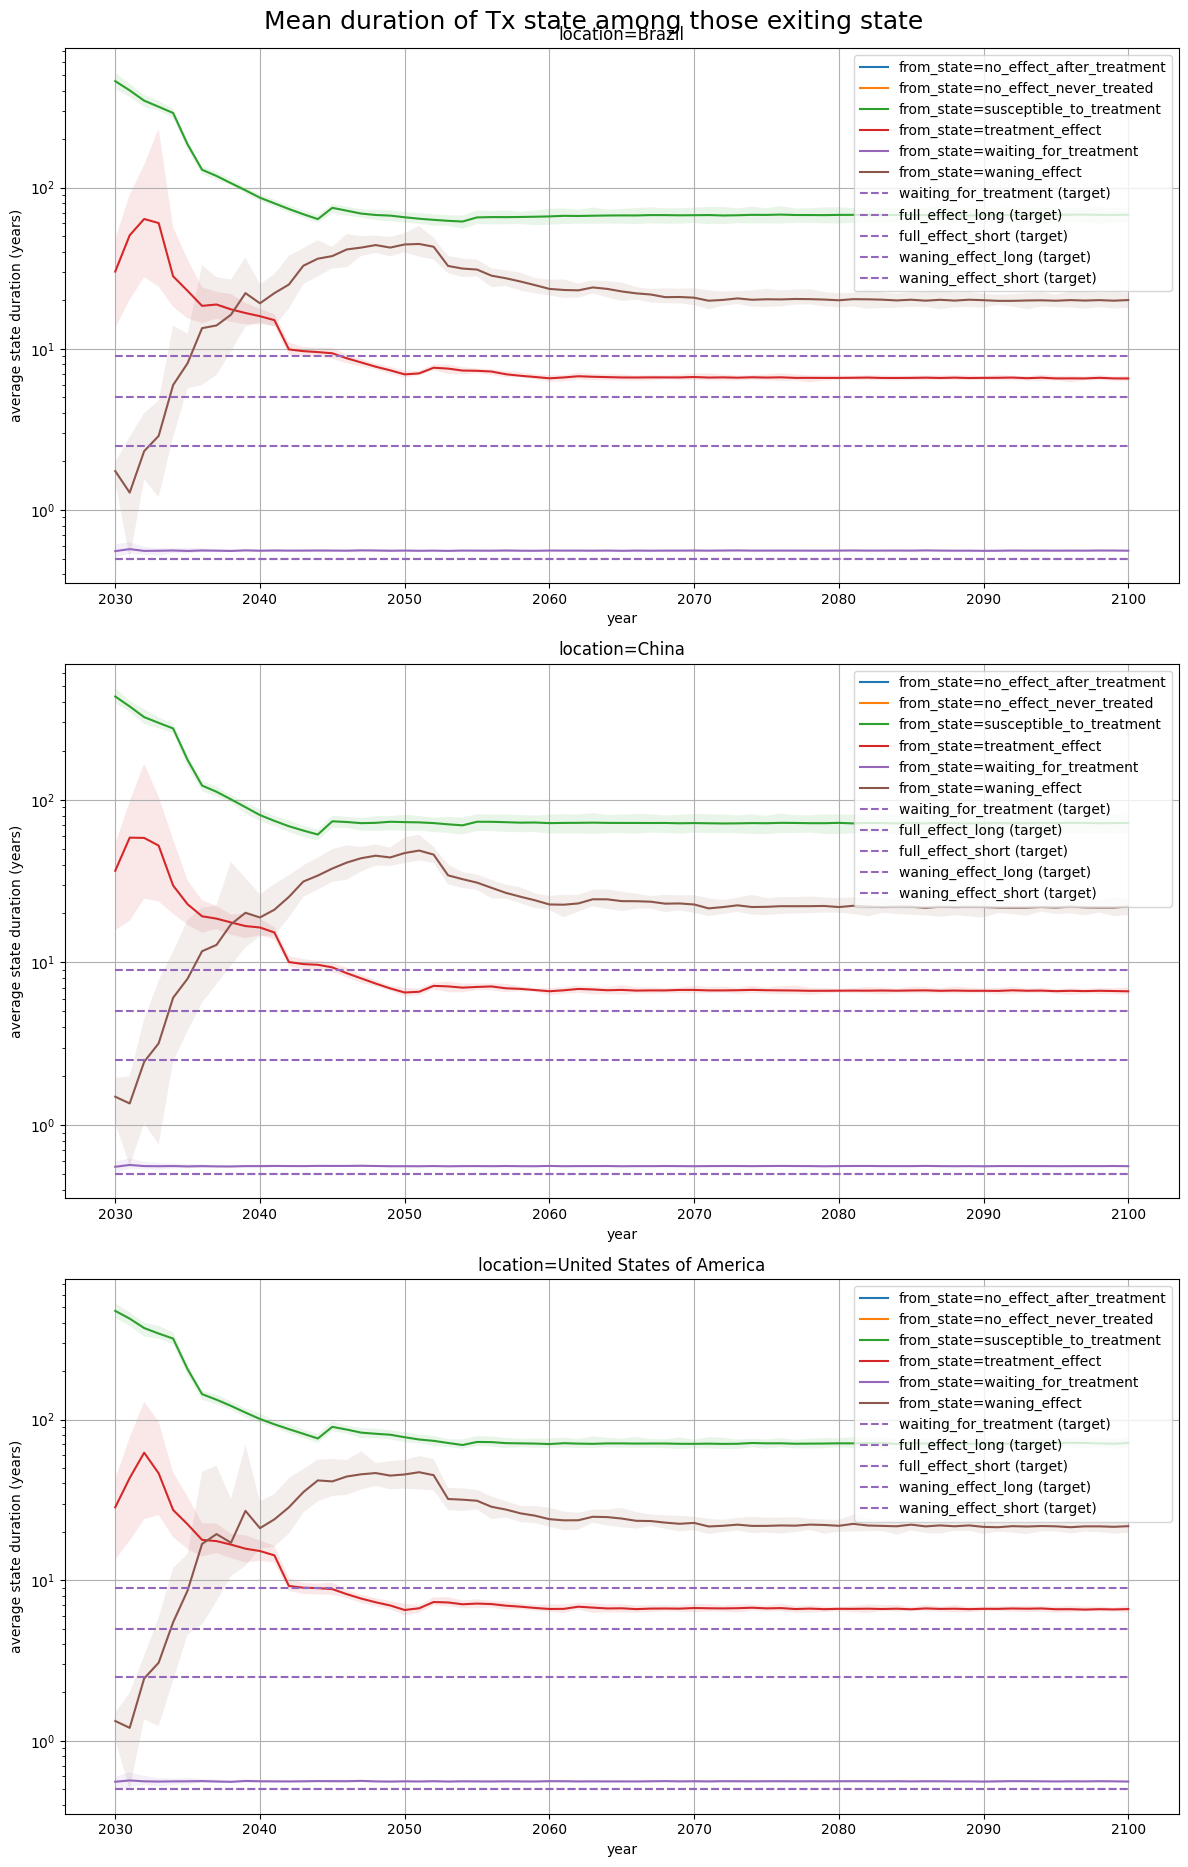

In [107]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [108]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [109]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [110]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [111]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [112]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias',
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
268.762679 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
9598495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
9598495  alzheimers_disease_and_other_dementias       cause        2100   
9598496  alzheimers_disease_and_other_dementias       cause        2100   
9598497  alzheimers_disease_and_other_dementias       cause        2100   
9598498  alzheimers_disease_and_other_dementias       cause        2100   
9598499  alzheimers_disease_and_other_dementias       cause        2100   

         input_draw      measure                    scenario     sex  \
0                 1  person_time                    baseline  Female   
1                 1  person_time                    baseline  Female   
2                 1  person_time                    baseline  Female   
3                 1  person_time                    baseline  Female   
4                 1  person_time                    baseline  Female   
...             ...          ...                         ...     ...   
9598495         249  person_time  bbbm_testing_and_treatment    Male   
9598496         249  person_time  bbbm_testing_and_treatment    Male   
9598497         249  person_time  bbbm_testing_and_treatment    Male   
9598498         249  person_time  bbbm_testing_and_treatment    Male   
9598499         249  person_time  bbbm_testing_and_treatment    Male   

                                         sub_entity  \
0            alzheimers_blood_based_biomarker_state   
1            alzheimers_blood_based_biomarker_state   
2            alzheimers_blood_based_biomarker_state   
3            alzheimers_blood_based_biomarker_state   
4            alzheimers_blood_based_biomarker_state   
...                                             ...   
9598495  alzheimers_mild_cognitive_impairment_state   
9598496  alzheimers_mild_cognitive_impairment_state   
9598497  alzheimers_mild_cognitive_impairment_state   
9598498  alzheimers_mild_cognitive_impairment_state   
9598499  alzheimers_mild_cognitive_impairment_state   

                         treatment        value                  location  
0        no_effect_after_treatment     0.000000  United States of America  
1          no_effect_never_treated     0.000000  United States of America  
2         susceptible_to_treatment     0.000000  United States of America  
3                 treatment_effect     0.000000  United States of America  
4            waiting_for_treatment     0.000000  United States of America  
...                            ...          ...                       ...  
9598495    no_effect_never_treated    26.409309                    Brazil  
9598496   susceptible_to_treatment  3614.587269                    Brazil  
9598497           treatment_effe

In [113]:
person_time_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
dtype: object

In [114]:
person_time_cause_states.treatment.unique()

['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [115]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [116]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias',
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
179.176677 MB
1375.789677 MB
191.975267 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
6398995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
6398995  alzheimers_disease_and_other_dementias       cause        2100   
6398996  alzheimers_disease_and_other_dementias       cause        2100   
6398997  alzheimers_disease_and_other_dementias       cause        2100   
6398998  alzheimers_disease_and_other_dementias       cause        2100   
6398999  alzheimers_disease_and_other_dementias       cause        2100   

         input_draw           measure                    scenario     sex  \
0                 1  transition_count                    baseline  Female   
1                 1  transition_count                    baseline  Female   
2                 1  transition_count                    baseline  Female   
3                 1  transition_count                    baseline  Female   
4                 1  transition_count                    baseline  Female   
...             ...               ...                         ...     ...   
6398995         249  transition_count  bbbm_testing_and_treatment    Male   
6398996         249  transition_count  bbbm_testing_and_treatment    Male   
6398997         249  transition_count  bbbm_testing_and_treatment    Male   
6398998         249  transition_count  bbbm_testing_and_treatment    Male   
6398999         249  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity  \
0        alzheimers_blood_based_biomarker_state_to_alzh...   
1        alzheimers_blood_based_biomarker_state_to_alzh...   
2        alzheimers_blood_based_biomarker_state_to_alzh...   
3        alzheimers_blood_based_biomarker_state_to_alzh...   
4        alzheimers_blood_based_biomarker_state_to_alzh...   
...                                                    ...   
6398995  alzheimers_mild_cognitive_impairment_state_to_...   
6398996  alzheimers_mild_cognitive_impairment_state_to_...   
6398997  alzheimers_mild_cognitive_impairment_state_to_...   
6398998  alzheimers_mild_cognitive_impairment_state_to_...   
6398999  alzheimers_mild_cognitive_impairment_state_to_...   

                         treatment  value                  location  \
0        no_effect_after_treatment    0.0  United States of America   
1          no_effect_never_treated    0.0  United States of America   
2         susceptible_to_treatment    0.0  United States of America   
3                 treatment_effect    0.0  United States of America   
4            waiting_for_treatment    0.0  United States of America   
...                            ...    ...                       ...   
6398995    no_effect_never_treated    9.0                    Brazil   
6398

In [117]:
transition_count_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw          int64
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
from_state       category
to_state         category
dtype: object

In [118]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [119]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # doesn't actually broadcast, just records it
    measure='transition_rate',
    dropna=True,
)
incidence_rates_by_treatment

event_year                                  from_state  \
0            2022      alzheimers_blood_based_biomarker_state   
1            2022      alzheimers_blood_based_biomarker_state   
2            2022      alzheimers_blood_based_biomarker_state   
3            2022      alzheimers_blood_based_biomarker_state   
4            2022      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
99646        2100  alzheimers_mild_cognitive_impairment_state   
99647        2100  alzheimers_mild_cognitive_impairment_state   
99648        2100  alzheimers_mild_cognitive_impairment_state   
99649        2100  alzheimers_mild_cognitive_impairment_state   
99650        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment                                    to_state  \
0      susceptible_to_treatment  alzheimers_mild_cognitive_impairment_state   
1      susceptible_to_treatment  alzheimers_mild_cognitive_impairment_state   
2      susceptible_to_treatment  alzheimers_mild_cognitive_impairment_state   
3      susceptible_to_treatment  alzheimers_mild_cognitive_impairment_state   
4      susceptible_to_treatment  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
99646             waning_effect                    alzheimers_disease_state   
99647             waning_effect                    alzheimers_disease_state   
99648             waning_effect                    alzheimers_disease_state   
99649             waning_effect                    alzheimers_disease_state   
99650             waning_effect                    alzheimers_disease_state   

       input_draw                    scenario                  location  \
0               1                    baseline                    Brazil   
1               1                    baseline                     China   
2               1                    baseline  United States of America   
3               1                bbbm_testing                    Brazil   
4               1                bbbm_testing                     China   
...           ...                         ...                       ...   
99646         248  bbbm_testing_and_treatment                     China   
99647         248  bbbm_testing_and_treatment  United States of America   
99648         249  bbbm_testing_and_treatment                    Brazil   
99649         249  bbbm_testing_and_treatment                     China   
99650         249  bbbm_testing_and_treatment  United States of America   

          value          measure numerator_measure denominator_measure  \
0      0.139972  transition_rate  transition_count         person_time   
1      0.140249  transition_rate  transition_count         person_time   
2      0.142225  transition_rate  transition_count         person_time   
3      0.139972  transition_rate  transition_count         person_time   
4      0.140249  transition_rate  transition_count         person_time   
...         ...              ...               ...                 ...   
99646  0.255734  transition_rate  transition_count         person_time   
99647  0.271674  transition_rate  transition_count         person_time   
99648  0.258894  transition_rate  transition_count         person_time   
99649  0.251420  transition_rate  transition_count         person_time   
99650  0.258385  transition_rate  transition_count         person_time   

       multiplier  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
99646           1  
99647           1  
99648           1  
99649           1  
99650           1  

[99651 rows x 12 columns]

## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [120]:
# 2026-02-05: Why do I have to explicitly put this in a context manager all of a sudden?
with np.errstate(invalid='ignore'):
    print(incidence_rates_by_treatment.value.describe())

count    9.965100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.451429e-01
50%      1.759460e-01
75%      2.522678e-01
max               inf
Name: value, dtype: float64


In [121]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(inf.sum(), "rows with infinite values")
incidence_rates_by_treatment.loc[inf]#.query("from_state=='alzheimers_blood_based_biomarker_state'")

33 rows with infinite values


event_year                                  from_state  \
2625         2027      alzheimers_blood_based_biomarker_state   
2626         2027      alzheimers_blood_based_biomarker_state   
2627         2027      alzheimers_blood_based_biomarker_state   
2628         2027      alzheimers_blood_based_biomarker_state   
2629         2027      alzheimers_blood_based_biomarker_state   
2630         2027      alzheimers_blood_based_biomarker_state   
2631         2027      alzheimers_blood_based_biomarker_state   
4846         2030      alzheimers_blood_based_biomarker_state   
5878         2031      alzheimers_blood_based_biomarker_state   
5879         2031      alzheimers_blood_based_biomarker_state   
5880         2031      alzheimers_blood_based_biomarker_state   
6465         2031  alzheimers_mild_cognitive_impairment_state   
6466         2031  alzheimers_mild_cognitive_impairment_state   
6467         2031  alzheimers_mild_cognitive_impairment_state   
6955         2031  alzheimers_mild_cognitive_impairment_state   
8089         2032  alzheimers_mild_cognitive_impairment_state   
8099         2032  alzheimers_mild_cognitive_impairment_state   
8100         2032  alzheimers_mild_cognitive_impairment_state   
8101         2032  alzheimers_mild_cognitive_impairment_state   
8130         2033      alzheimers_blood_based_biomarker_state   
8146         2033      alzheimers_blood_based_biomarker_state   
8148         2033      alzheimers_blood_based_biomarker_state   
8767         2033  alzheimers_mild_cognitive_impairment_state   
8778         2033  alzheimers_mild_cognitive_impairment_state   
9293         2033  alzheimers_mild_cognitive_impairment_state   
9294         2033  alzheimers_mild_cognitive_impairment_state   
9295         2033  alzheimers_mild_cognitive_impairment_state   
9310         2033  alzheimers_mild_cognitive_impairment_state   
9380         2034      alzheimers_blood_based_biomarker_state   
10031        2034  alzheimers_mild_cognitive_impairment_state   
10032        2034  alzheimers_mild_cognitive_impairment_state   
10033        2034  alzheimers_mild_cognitive_impairment_state   
11324        2035  alzheimers_mild_cognitive_impairment_state   

                       treatment                                    to_state  \
2625            treatment_effect  alzheimers_mild_cognitive_impairment_state   
2626            treatment_effect  alzheimers_mild_cognitive_impairment_state   
2627            treatment_effect  alzheimers_mild_cognitive_impairment_state   
2628            treatment_effect  alzheimers_mild_cognitive_impairment_state   
2629            treatment_effect  alzheimers_mild_cognitive_impairment_state   
2630            treatment_effect  alzheimers_mild_cognitive_impairment_state   
2631            treatment_effect  alzheimers_mild_cognitive_impairment_state   
4846   no_effect_after_treatment  alzheimers_mild_cognitive_impairment_state   
5878   no_effect_after_treatment  alzheimers_mild_cognitive_impairment_state   
5879   no_effect_after_treatment  alzheimers_mild_cognitive_impairment_state   
5880   no_effect_after_treatment  alzheimers_mild_cognitive_impairment_state   
6465   no_effect_after_treatment                    alzheimers_disease_state   
6466   no_effect_after_treatment                    alzheimers_disease_state   
6467   no_effect_after_treatment                    alzheimers_disease_state   
6955               waning_effect                    alzheimers_disease_state   
8089               waning_effect                    alzheimers_disease_state   
8099               waning_effect                    alzheimers_disease_state   
8100               waning_effect                    alzheimers_disease_state   
8101               waning_effect                    alzheimers_disease_state   
8130   no_effect_after_treatment  alzheimers_mild_cognitive_impairment_state   
8146   no_effect_after_treatment  alzheimers_mild_cognitive_impairment_state   
8148   no_effect_after_treatment  al

In [122]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, treatment, value, location, from_state, to_state]
Index: []

In [123]:
person_time_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2030 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==2 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, treatment, value, location]
Index: []

## Plot disease transition rates stratified by treatment status, filtering out $\infty$

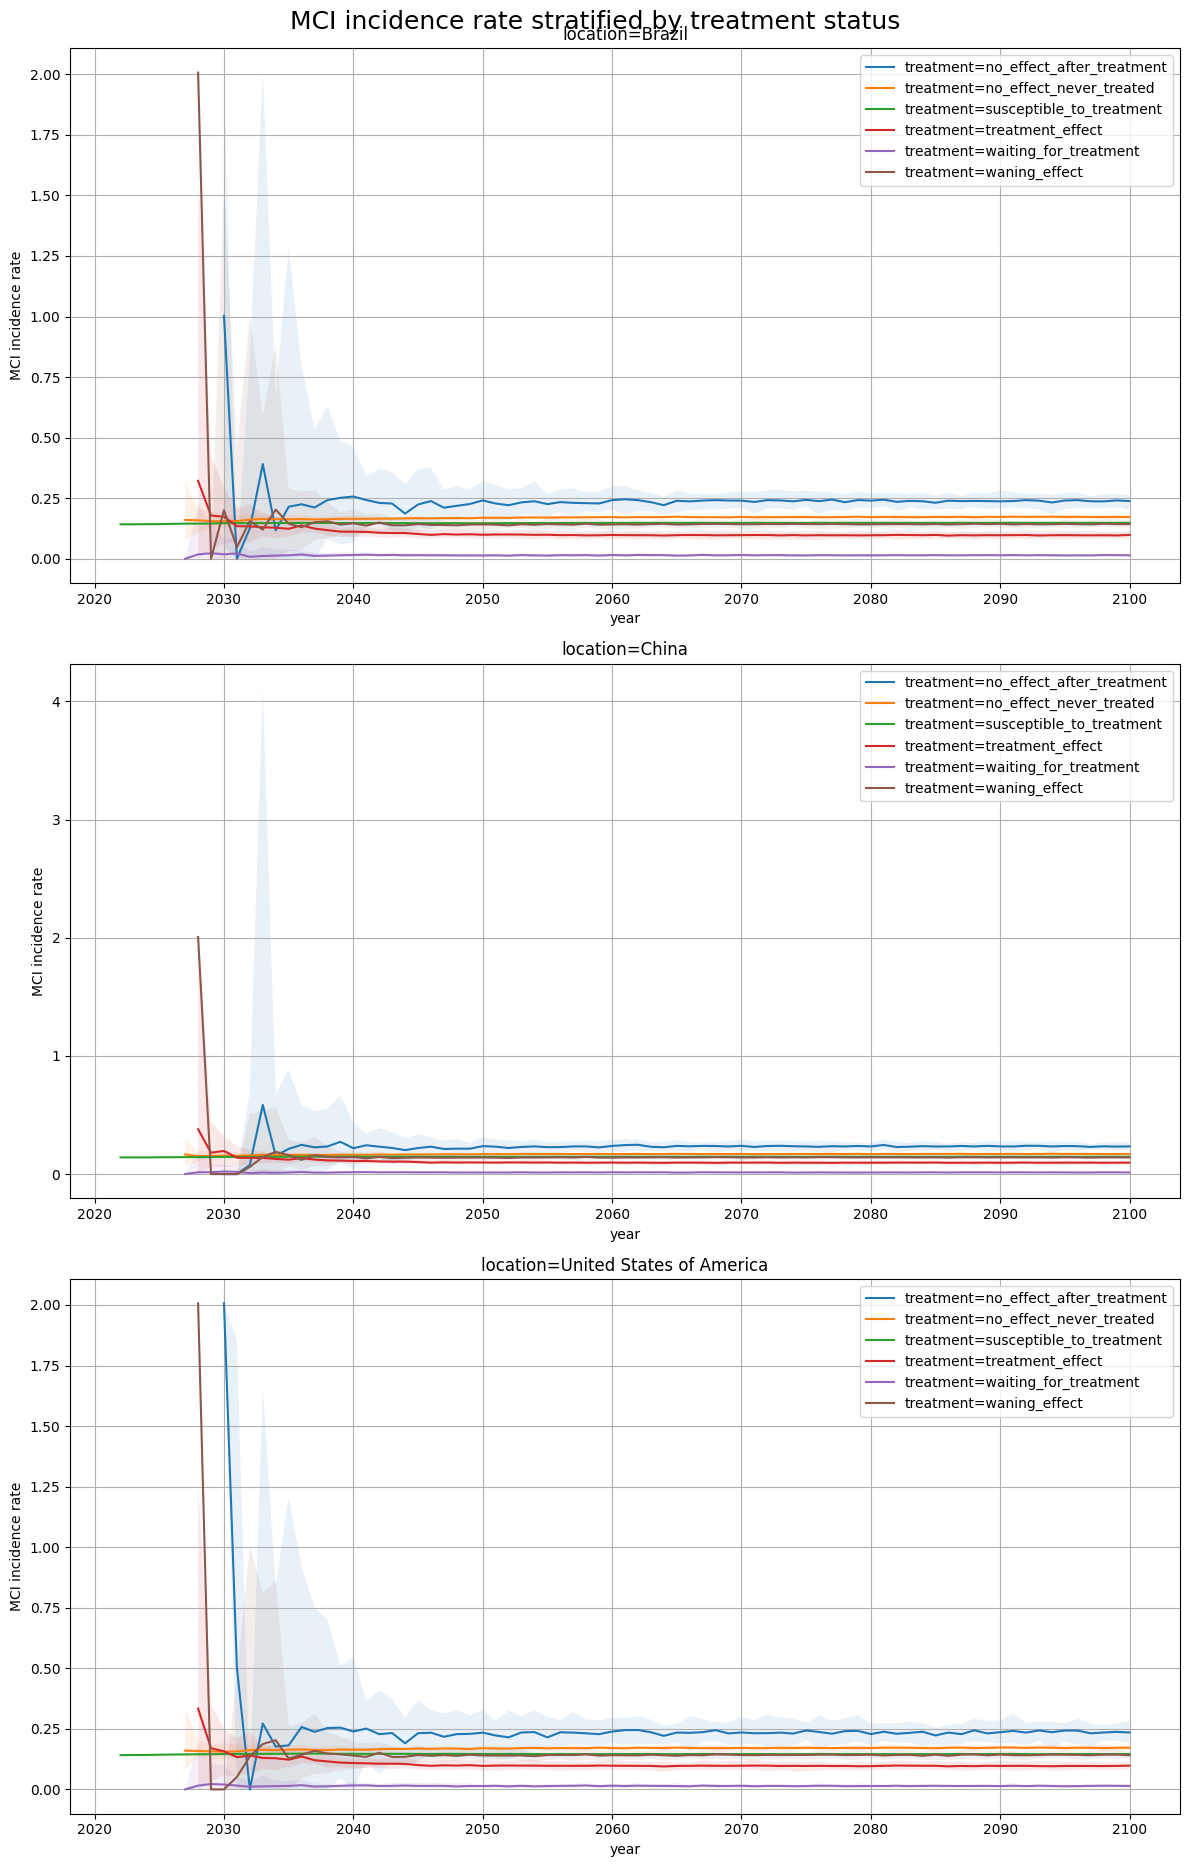

In [124]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

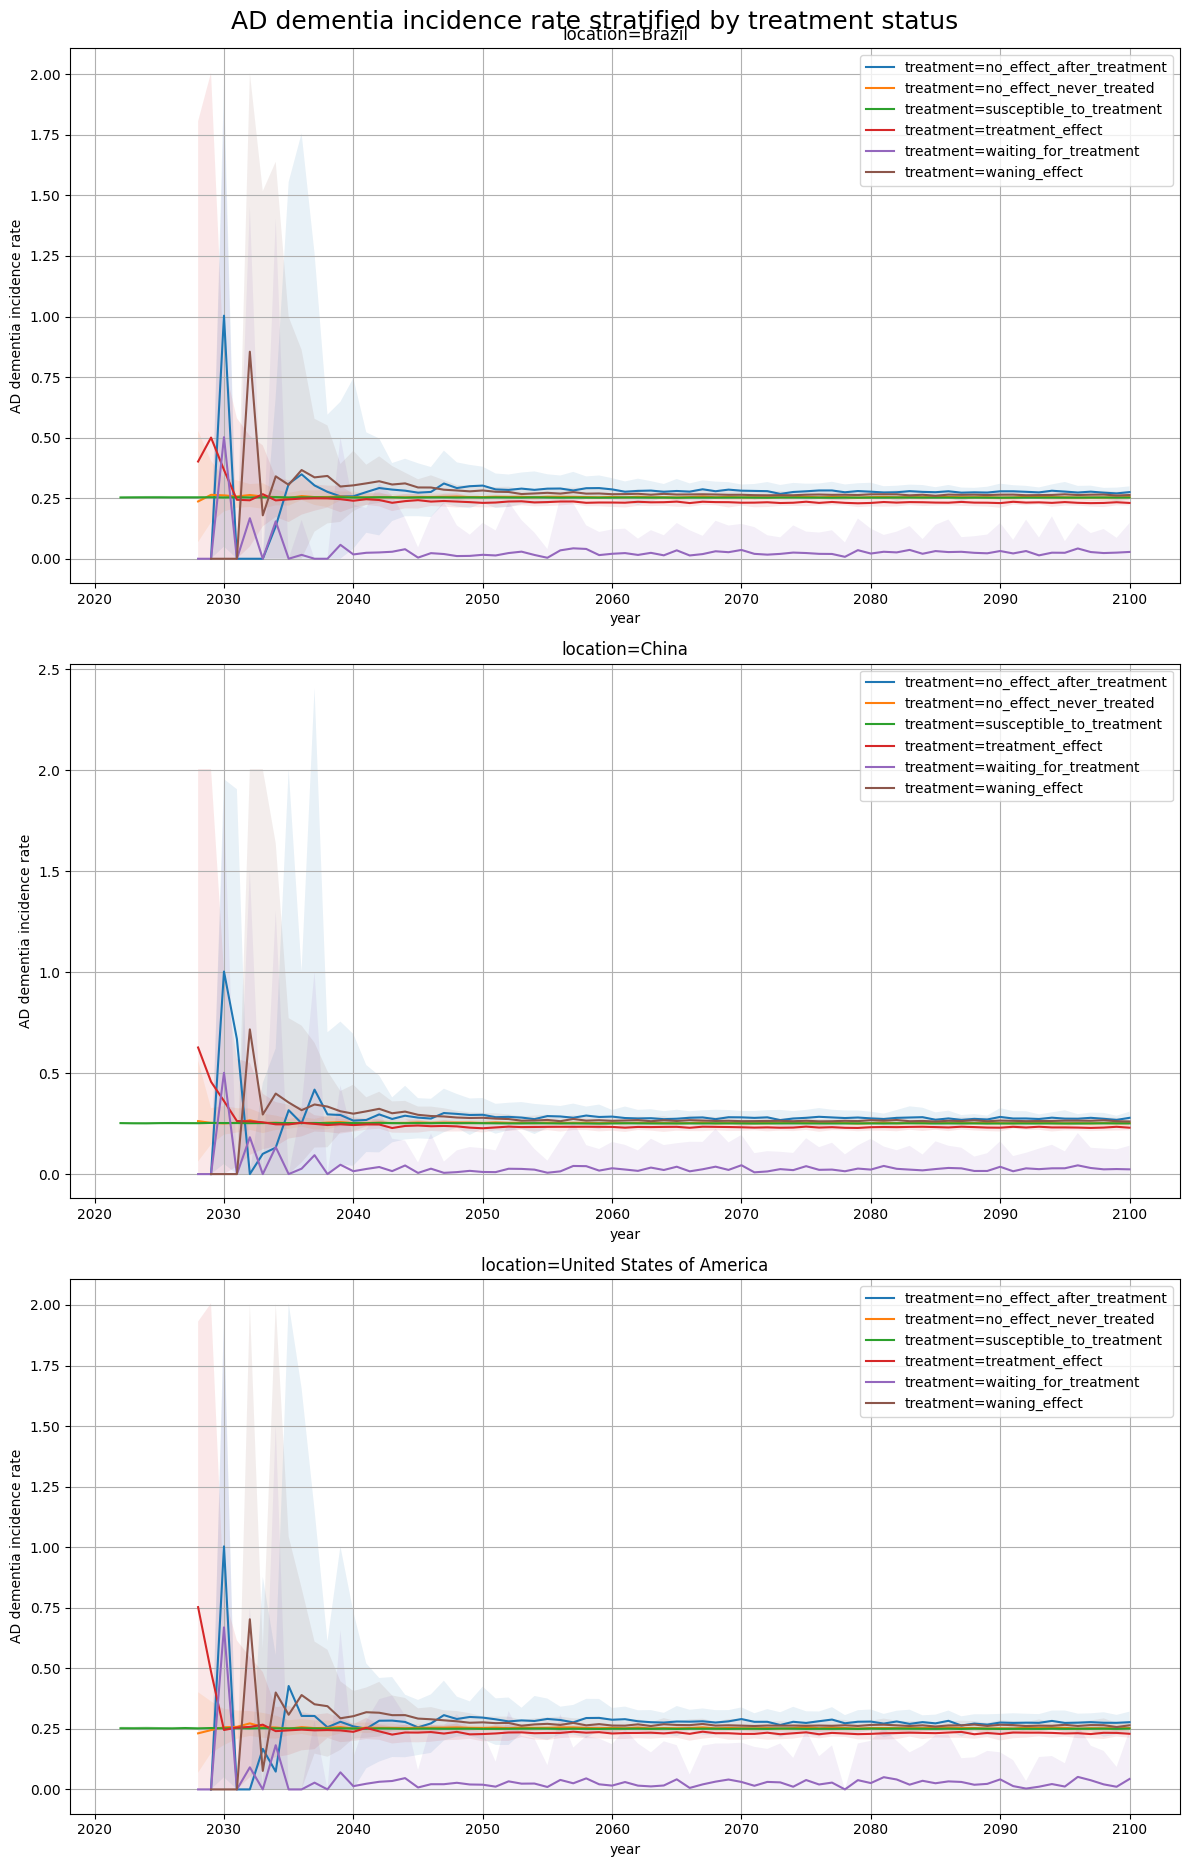

In [125]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

## Compute hazard ratio

In [126]:
hazard_ratio = ops.ratio(
    incidence_rates_by_treatment,
    incidence_rates_by_treatment.query("treatment=='susceptible_to_treatment'"),
    strata=['event_year', 'from_state'],
    numerator_broadcast=['treatment'],
    # prefilter_query="from_state=='alzheimers_blood_based_biomarker_state'",
)
hazard_ratio

event_year                                  from_state  \
0            2022      alzheimers_blood_based_biomarker_state   
1            2022      alzheimers_blood_based_biomarker_state   
2            2022      alzheimers_blood_based_biomarker_state   
3            2022      alzheimers_blood_based_biomarker_state   
4            2022      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
99646        2100  alzheimers_mild_cognitive_impairment_state   
99647        2100  alzheimers_mild_cognitive_impairment_state   
99648        2100  alzheimers_mild_cognitive_impairment_state   
99649        2100  alzheimers_mild_cognitive_impairment_state   
99650        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
0      susceptible_to_treatment           1                    baseline   
1      susceptible_to_treatment           1                    baseline   
2      susceptible_to_treatment           1                    baseline   
3      susceptible_to_treatment           1                bbbm_testing   
4      susceptible_to_treatment           1                bbbm_testing   
...                         ...         ...                         ...   
99646   no_effect_never_treated         249  bbbm_testing_and_treatment   
99647  susceptible_to_treatment         249  bbbm_testing_and_treatment   
99648          treatment_effect         249  bbbm_testing_and_treatment   
99649     waiting_for_treatment         249  bbbm_testing_and_treatment   
99650             waning_effect         249  bbbm_testing_and_treatment   

                       location     value numerator_measure  \
0                        Brazil  1.000000   transition_rate   
1                         China  1.000000   transition_rate   
2      United States of America  1.000000   transition_rate   
3                        Brazil  1.000000   transition_rate   
4                         China  1.000000   transition_rate   
...                         ...       ...               ...   
99646  United States of America  1.006908   transition_rate   
99647  United States of America  1.000000   transition_rate   
99648  United States of America  0.950687   transition_rate   
99649  United States of America  0.396834   transition_rate   
99650  United States of America  1.021851   transition_rate   

      denominator_measure  multiplier  
0         transition_rate           1  
1         transition_rate           1  
2         transition_rate           1  
3         transition_rate           1  
4         transition_rate           1  
...                   ...         ...  
99646     transition_rate           1  
99647     transition_rate           1  
99648     transition_rate           1  
99649     transition_rate           1  
99650     transition_rate           1  

[99651 rows x 10 columns]

In [127]:
with np.errstate(invalid='ignore'):
    print(hazard_ratio.value.describe())

count    9.965100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      9.642213e-01
50%      1.000000e+00
75%      1.047422e+00
max               inf
Name: value, dtype: float64


In [128]:
inf_ratio = np.isinf(hazard_ratio.value)
print(inf_ratio.sum(), "rows with infinite values")

33 rows with infinite values


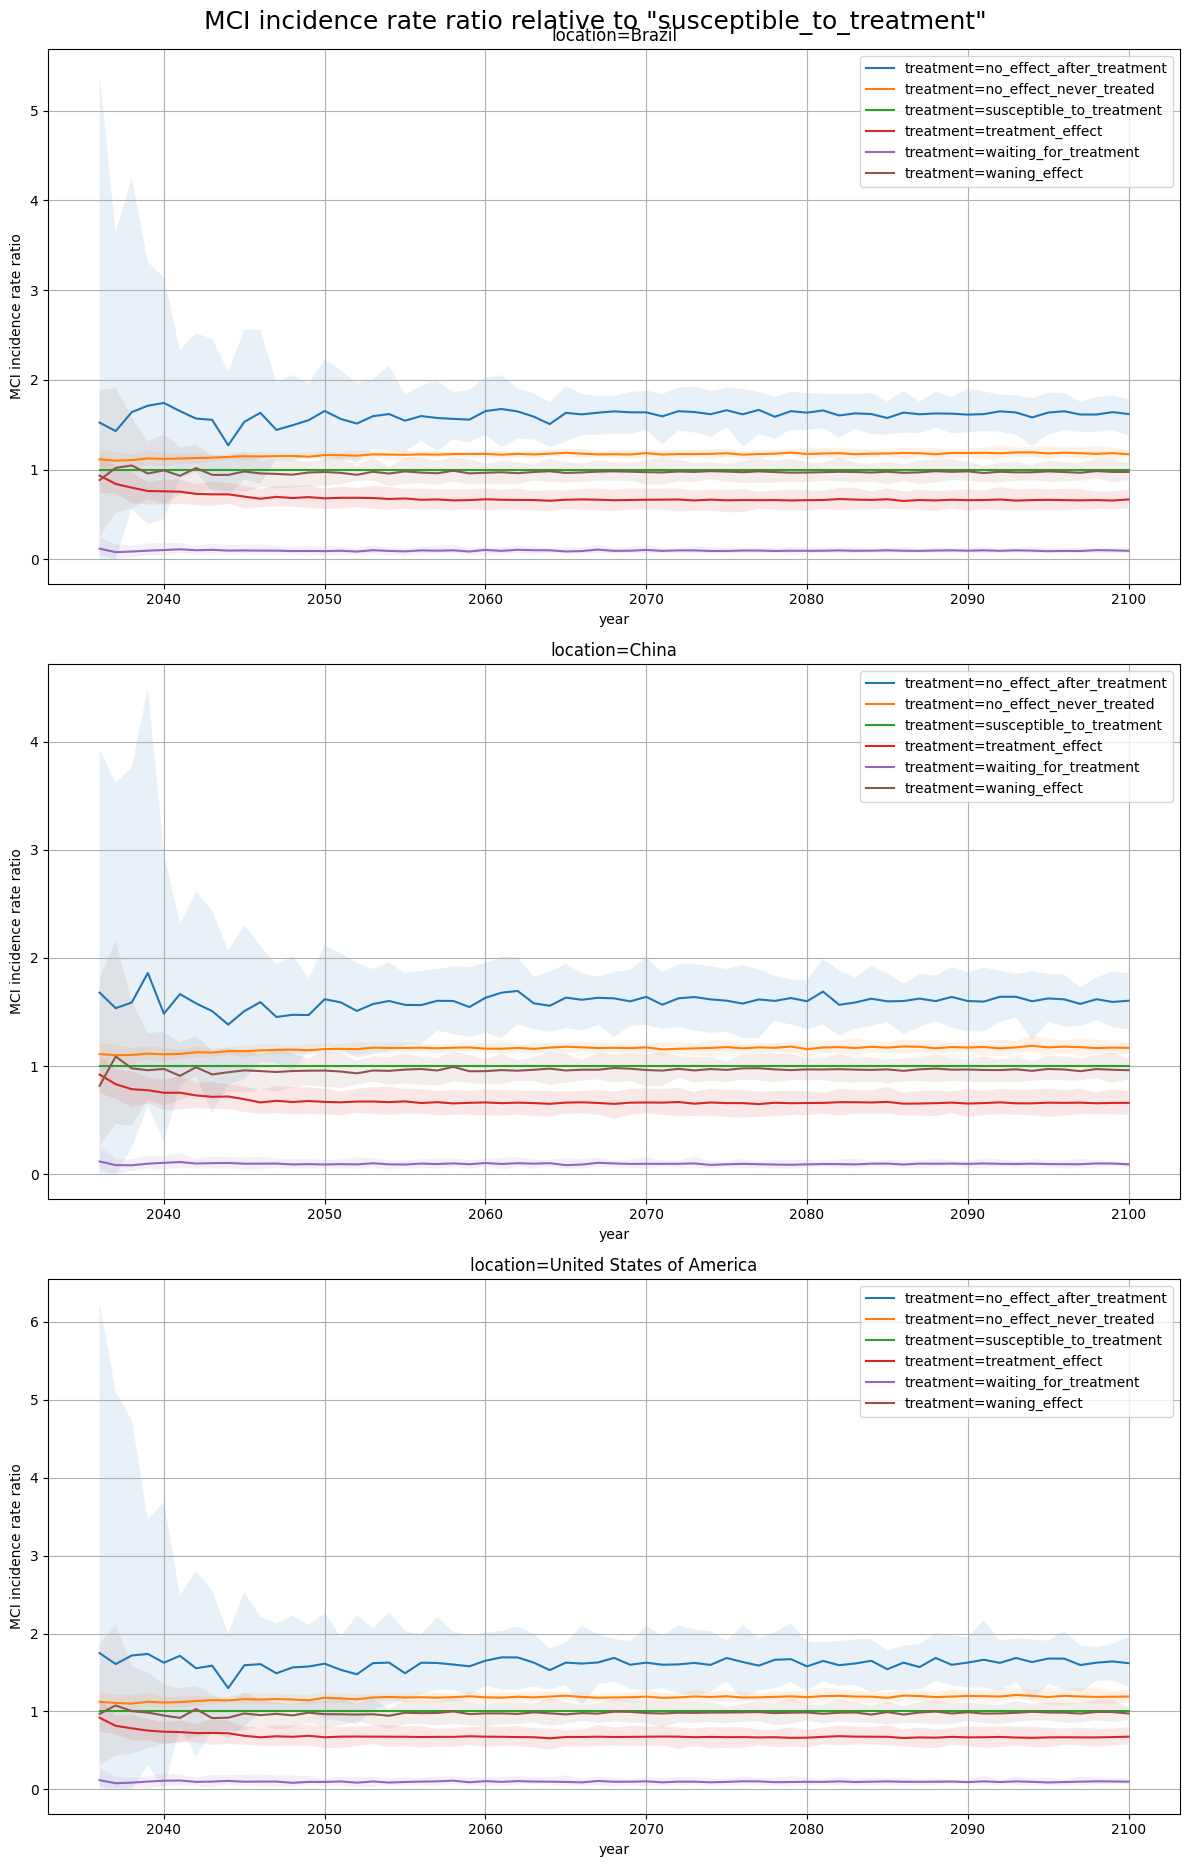

In [ ]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment'"
        " and from_state=='alzheimers_blood_based_biomarker_state'"
        " and event_year > 2035" # Avoid wild spikes in early years
        ),
    'treatment',
    'location',
    ylabel='MCI incidence rate ratio',
    suptitle='MCI incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

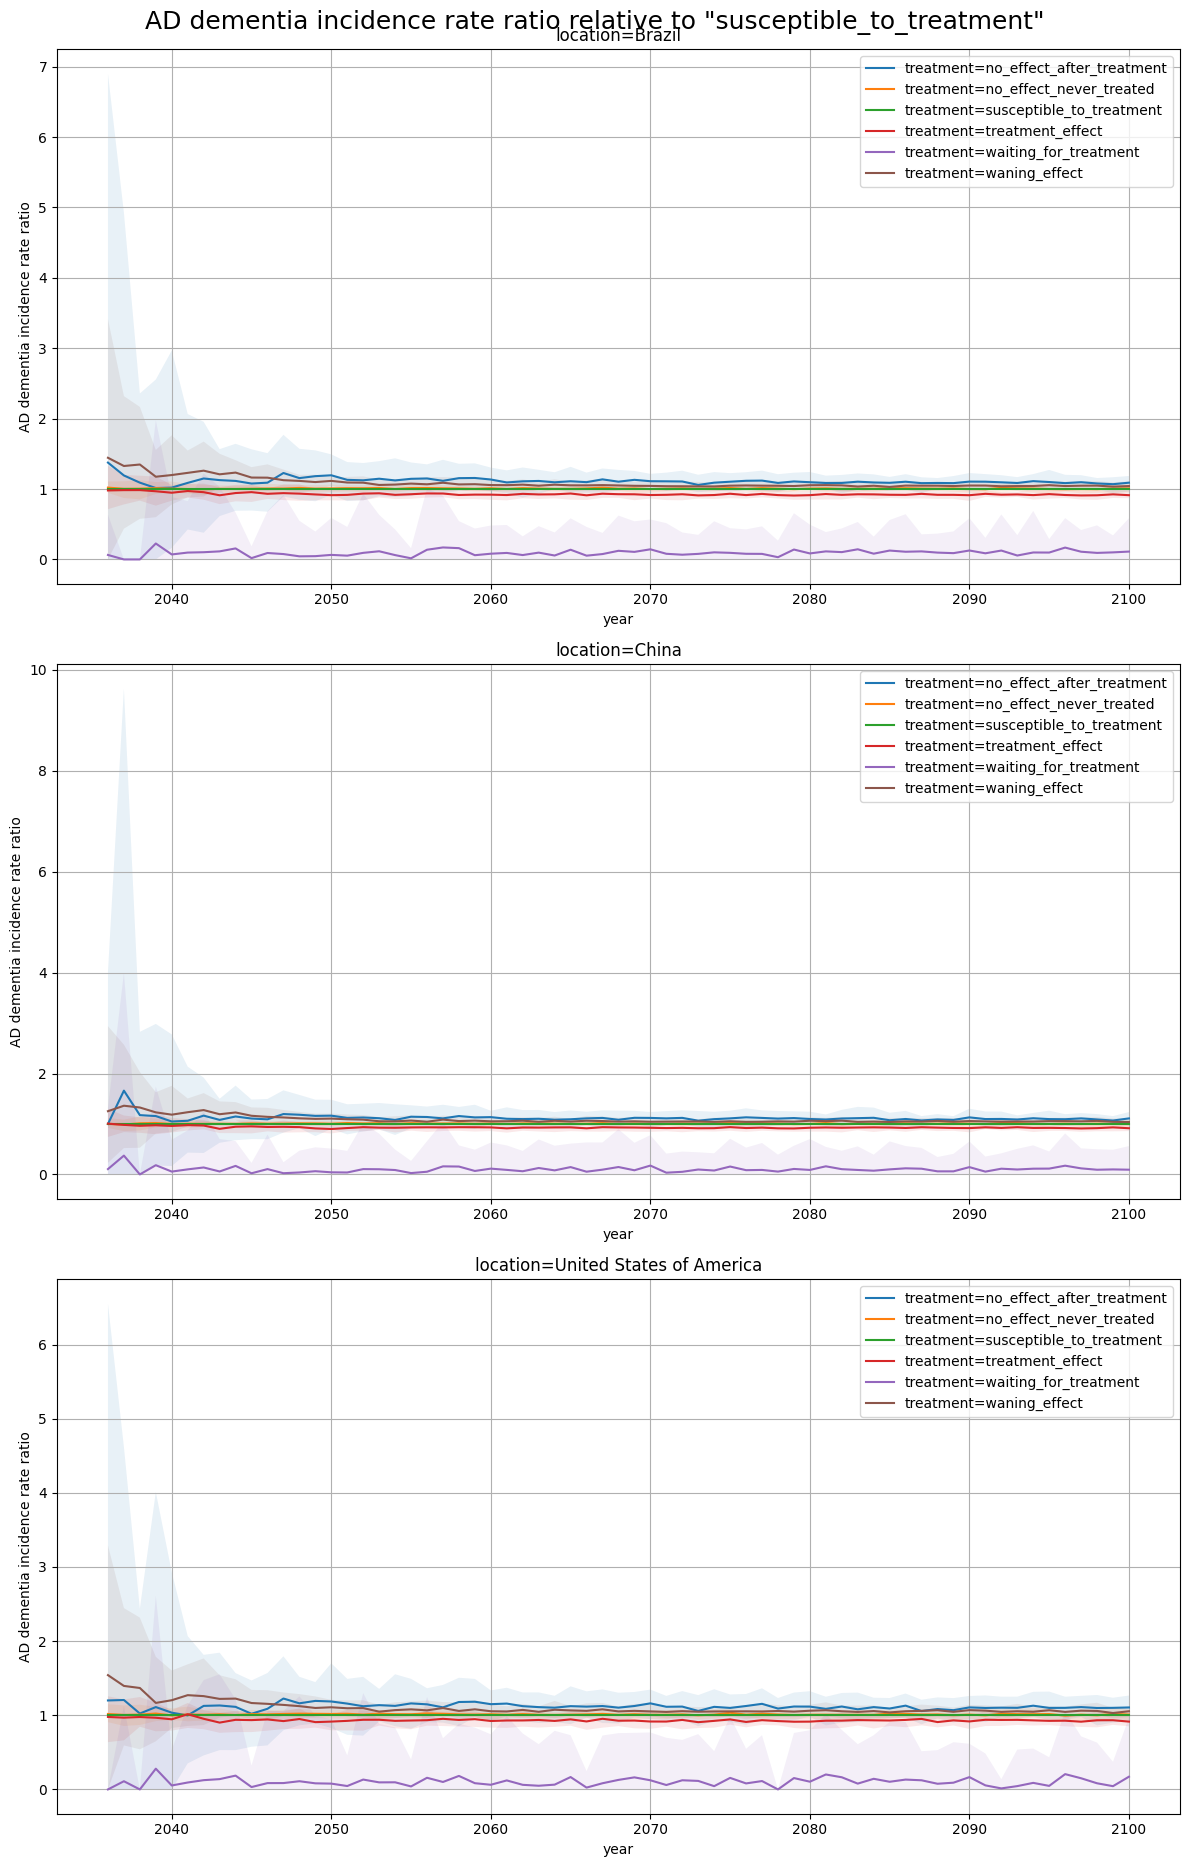

In [130]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment' and event_year > 2035"
        " and from_state=='alzheimers_mild_cognitive_impairment_state'"
        ),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate ratio',
    suptitle='AD dementia incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

In [ ]:
# Why are the hazard ratios above 0.5?
# Maybe it's selection bias due to age?
hazard_ratio.loc[~inf_ratio].query(
    "scenario=='bbbm_testing_and_treatment'"# and event_year > 2035"
    " and from_state=='alzheimers_blood_based_biomarker_state'"
    " and treatment == 'treatment_effect'"
    " and event_year >= 2040"
    ).pipe(ops.describe)

count  \
denominator_measure event_year from_state                             location                 multiplier numerator_measure scenario                   treatment                 
transition_rate     2040       alzheimers_blood_based_biomarker_state Brazil                   1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                                                                      China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                                                                      United States of America 1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                    2041       alzheimers_blood_based_biomarker_state Brazil                   1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                                                                      China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
...                                                                                                                                                                        ...   
                    2099       alzheimers_blood_based_biomarker_state China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                                                                      United States of America 1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                    2100       alzheimers_blood_based_biomarker_state Brazil                   1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                                                                      China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   
                                                                      United States of America 1          transition_rate   bbbm_testing_and_treatment treatment_effect   25.0   

                                                                                                                                                                             mean  \
denominator_measure event_year from_state                             location                 multiplier numerator_measure scenario                   treatment                    
transition_rate     2040       alzheimers_blood_based_biomarker_state Brazil                   1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.758885   
                                                                      China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.754750   
                                                                      United States of America 1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.740506   
                    2041       alzheimers_blood_based_biomarker_state Brazil                   1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.754937   
                                                                      China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.755071   
...                                                                                                                                                                           ...   
                    2099       alzheimers_blood_based_biomarker_state China                    1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.660980   
                                                                      United States of America 1          transition_rate   bbbm_testing_and_treatment treatment_effect  0.671499   
                    2100       alzheimers_bl

# Results!

# Load deaths and plot averted deaths by scenario

In [131]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
27.73271 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1066495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                           entity entity_type  event_year  input_draw measure  \
0        alzheimers_disease_state       cause        2022           1  deaths   
1        alzheimers_disease_state       cause        2022           1  deaths   
2        alzheimers_disease_state       cause        2022           1  deaths   
3        alzheimers_disease_state       cause        2022           1  deaths   
4        alzheimers_disease_state       cause        2022           1  deaths   
...                           ...         ...         ...         ...     ...   
1066495              other_causes       cause        2100         249  deaths   
1066496              other_causes       cause        2100         249  deaths   
1066497              other_causes       cause        2100         249  deaths   
1066498              other_causes       cause        2100         249  deaths   
1066499              other_causes       cause        2100         249  deaths   

                           scenario     sex   value                  location  
0                          baseline  Female     0.0  United States of America  
1                          baseline    Male     0.0  United States of America  
2                      bbbm_testing  Female     0.0  United States of America  
3                      bbbm_testing    Male     0.0  United States of America  
4        bbbm_testing_and_treatment  Female     0.0  United States of America  
...                             ...     ...     ...                       ...  
1066495                    baseline    Male  1313.0                    Brazil  
1066496                bbbm_testing  Female  4284.0                    Brazil  
1066497                bbbm_testing    Male  1313.0                    Brazil  
1066498  bbbm_testing_and_treatment  Female  4368.0                    Brazil  
1066499  bbbm_testing_and_treatment    Male  1330.0                    Brazil  

[1066500 rows x 11 columns]

In [132]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

27.73271 MB measure
12.090578 MB minuend
24.177578 MB subtrahend
6.405373 MB minuend re-indexed
12.804373 MB subtrahend re-indexed
12.804433 MB difference
18.48971 MB difference with reset index
19.201035 MB final difference
19.201035 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
710995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year  input_draw measure  \
0       alzheimers_disease_state       cause        2022           1  deaths   
1       alzheimers_disease_state       cause        2022           1  deaths   
2       alzheimers_disease_state       cause        2022           1  deaths   
3       alzheimers_disease_state       cause        2022           1  deaths   
4       alzheimers_disease_state       cause        2022           6  deaths   
...                          ...         ...         ...         ...     ...   
710995              other_causes       cause        2100         248  deaths   
710996              other_causes       cause        2100         249  deaths   
710997              other_causes       cause        2100         249  deaths   
710998              other_causes       cause        2100         249  deaths   
710999              other_causes       cause        2100         249  deaths   

           sex                  location                    scenario  \
0       Female  United States of America                bbbm_testing   
1         Male  United States of America                bbbm_testing   
2       Female  United States of America  bbbm_testing_and_treatment   
3         Male  United States of America  bbbm_testing_and_treatment   
4       Female  United States of America                bbbm_testing   
...        ...                       ...                         ...   
710995    Male                    Brazil  bbbm_testing_and_treatment   
710996  Female                    Brazil                bbbm_testing   
710997    Male                    Brazil                bbbm_testing   
710998  Female                    Brazil  bbbm_testing_and_treatment   
710999    Male                    Brazil  bbbm_testing_and_treatment   

       subtracted_from  value  
0             baseline    0.0  
1             baseline    0.0  
2             baseline    0.0  
3             baseline    0.0  
4             baseline    0.0  
...                ...    ...  
710995        baseline   -5.0  
710996        baseline    0.0  
710997        baseline    0.0  
710998        baseline  -84.0  
710999        baseline  -17.0  

[711000 rows x 12 columns]

In [133]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711000 entries, 0 to 710999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        711000 non-null  category
 1   artifact_path    711000 non-null  category
 2   entity           711000 non-null  category
 3   entity_type      711000 non-null  category
 4   event_year       711000 non-null  int16   
 5   input_draw       711000 non-null  int64   
 6   measure          711000 non-null  category
 7   sex              711000 non-null  category
 8   location         711000 non-null  category
 9   scenario         711000 non-null  category
 10  subtracted_from  711000 non-null  category
 11  value            711000 non-null  float64 
dtypes: category(9), float64(1), int16(1), int64(1)
memory usage: 18.3 MB


In [134]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [135]:
averted_deaths.index.memory_usage(deep=True)

132

In [136]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [137]:
averted_deaths.value.describe()

count    711000.000000
mean          0.195100
std           6.286377
min         -84.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         116.000000
Name: value, dtype: float64

In [138]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

19.201035 MB


In [139]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

19.201035 MB
8.432853 MB


entity age_group  event_year  input_draw  \
0       alzheimers_disease_state  40_to_44        2025          69   
1       alzheimers_disease_state  40_to_44        2025          69   
2       alzheimers_disease_state  40_to_44        2026          50   
3       alzheimers_disease_state  40_to_44        2026          50   
4       alzheimers_disease_state  40_to_44        2026          50   
...                          ...       ...         ...         ...   
263431              other_causes   95_plus        2100         249   
263432              other_causes   95_plus        2100         249   
263433              other_causes   95_plus        2100         249   
263434              other_causes   95_plus        2100         249   
263435              other_causes   95_plus        2100         249   

                          scenario                  location     value  \
0                     bbbm_testing                    Brazil  0.000000   
1       bbbm_testing_and_treatment                    Brazil  0.000000   
2                     bbbm_testing                    Brazil  0.000000   
3                     bbbm_testing                     China  0.000000   
4                     bbbm_testing  United States of America  0.000000   
...                            ...                       ...       ...   
263431                bbbm_testing                     China  0.000000   
263432                bbbm_testing  United States of America  0.000000   
263433  bbbm_testing_and_treatment                    Brazil -1.772552   
263434  bbbm_testing_and_treatment                     China -1.712234   
263435  bbbm_testing_and_treatment  United States of America -1.342038   

       numerator_measure denominator_measure  multiplier  
0                 deaths              deaths         100  
1                 deaths              deaths         100  
2                 deaths              deaths         100  
3                 deaths              deaths         100  
4                 deaths              deaths         100  
...                  ...                 ...         ...  
263431            deaths              deaths         100  
263432            deaths              deaths         100  
263433            deaths              deaths         100  
263434            deaths              deaths         100  
263435            deaths              deaths         100  

[263436 rows x 10 columns]

In [140]:
averted_deaths_pct.memory_usage(deep=True)

Index                      132
entity                  263694
age_group               264966
event_year              526872
input_draw             2107488
scenario                263761
location                263750
value                  2107488
numerator_measure       263607
denominator_measure     263607
multiplier             2107488
dtype: int64

In [141]:
ops.stratify(averted_deaths, 'event_year')

event_year  input_draw                    scenario  \
0            2022           1                bbbm_testing   
1            2022           1                bbbm_testing   
2            2022           1                bbbm_testing   
3            2022           1  bbbm_testing_and_treatment   
4            2022           1  bbbm_testing_and_treatment   
...           ...         ...                         ...   
11845        2100         249                bbbm_testing   
11846        2100         249                bbbm_testing   
11847        2100         249  bbbm_testing_and_treatment   
11848        2100         249  bbbm_testing_and_treatment   
11849        2100         249  bbbm_testing_and_treatment   

                       location  value  
0                        Brazil    0.0  
1                         China    0.0  
2      United States of America    0.0  
3                        Brazil    0.0  
4                         China    0.0  
...                         ...    ...  
11845                     China    0.0  
11846  United States of America    0.0  
11847                    Brazil   50.0  
11848                     China   53.0  
11849  United States of America   12.0  

[11850 rows x 5 columns]

In [142]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [143]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f(a=5, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
5 () {'b': 7}
None () {}


In [144]:
f(2)

2 () {}


# Draw results plots

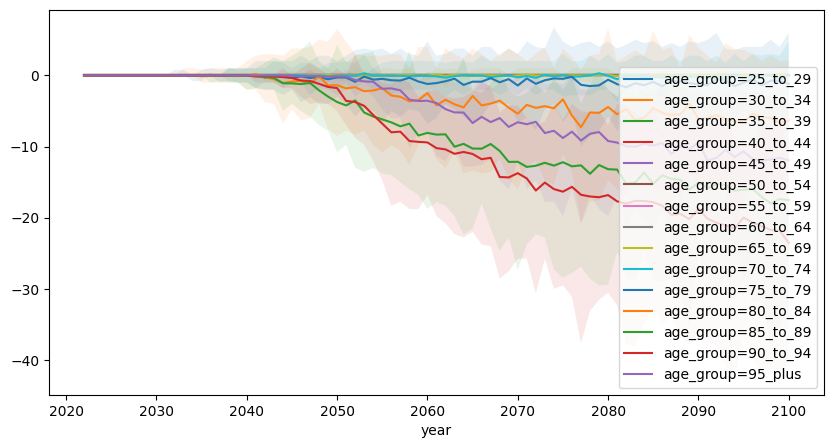

In [145]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


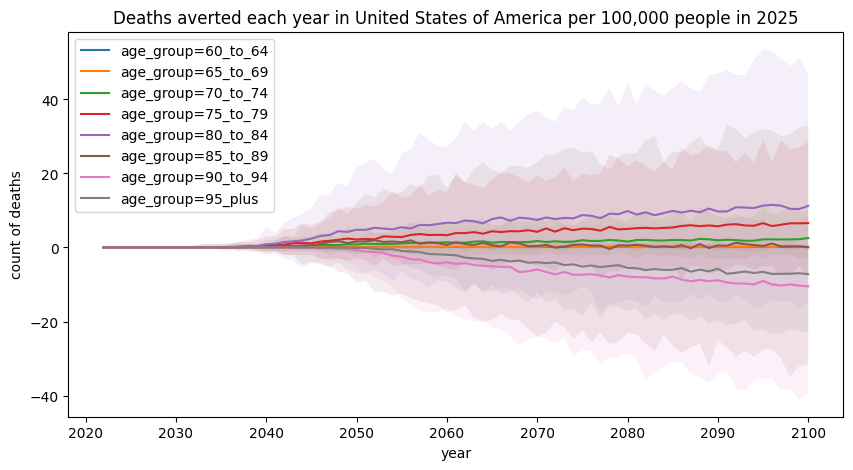

In [146]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

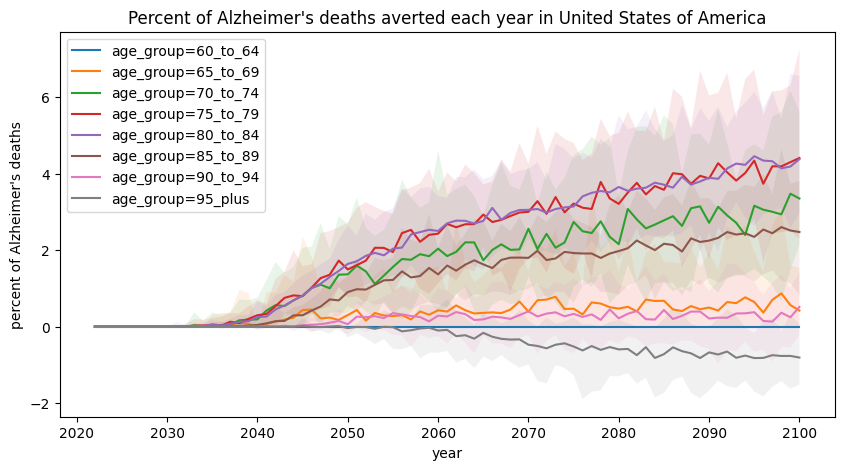

In [147]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [148]:
deaths.scenario.unique()

['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

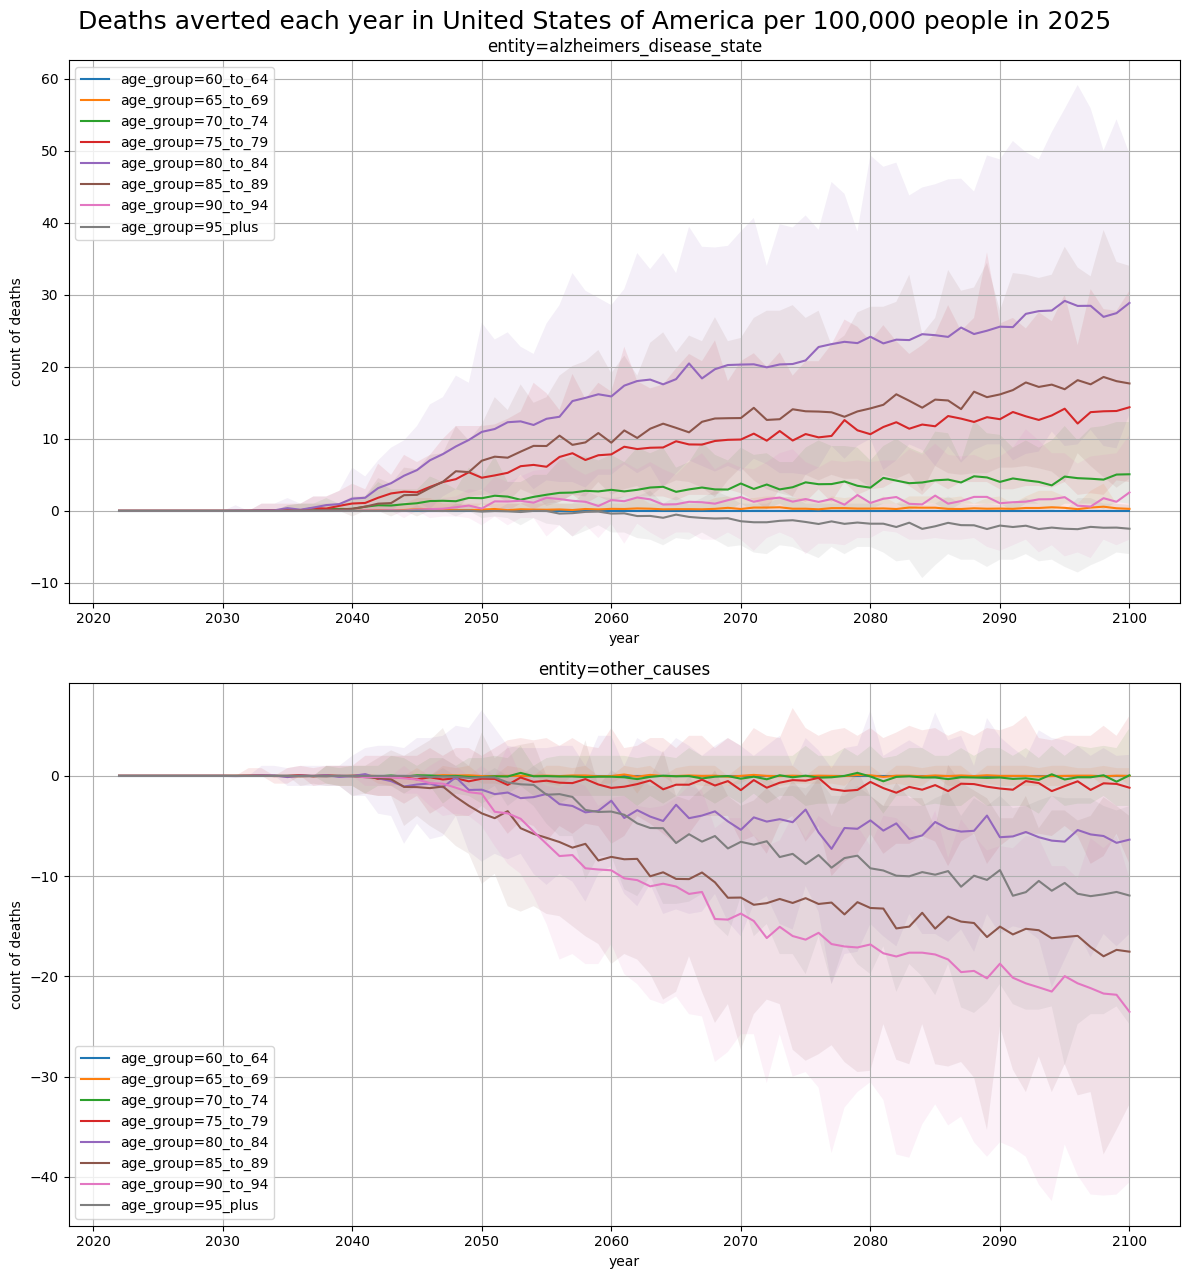

In [149]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

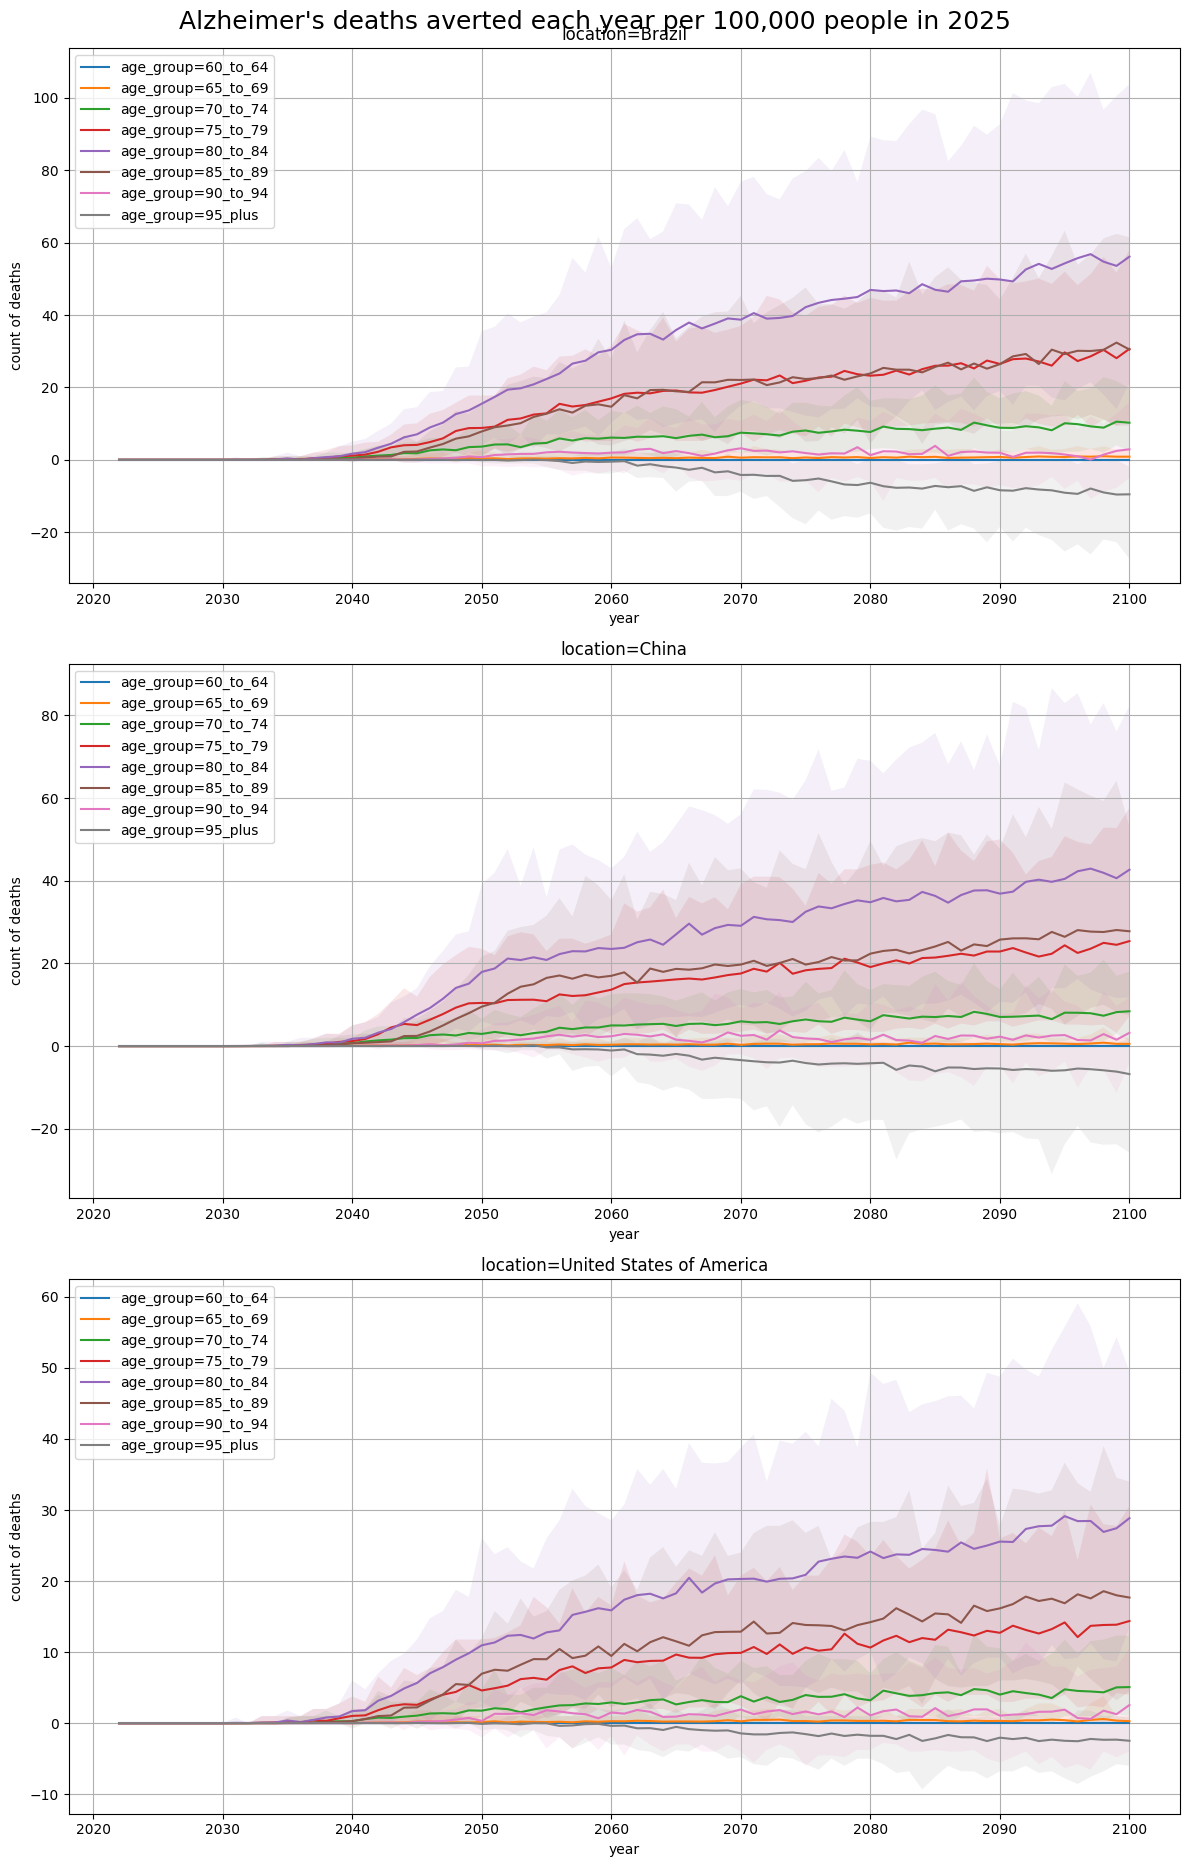

In [150]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

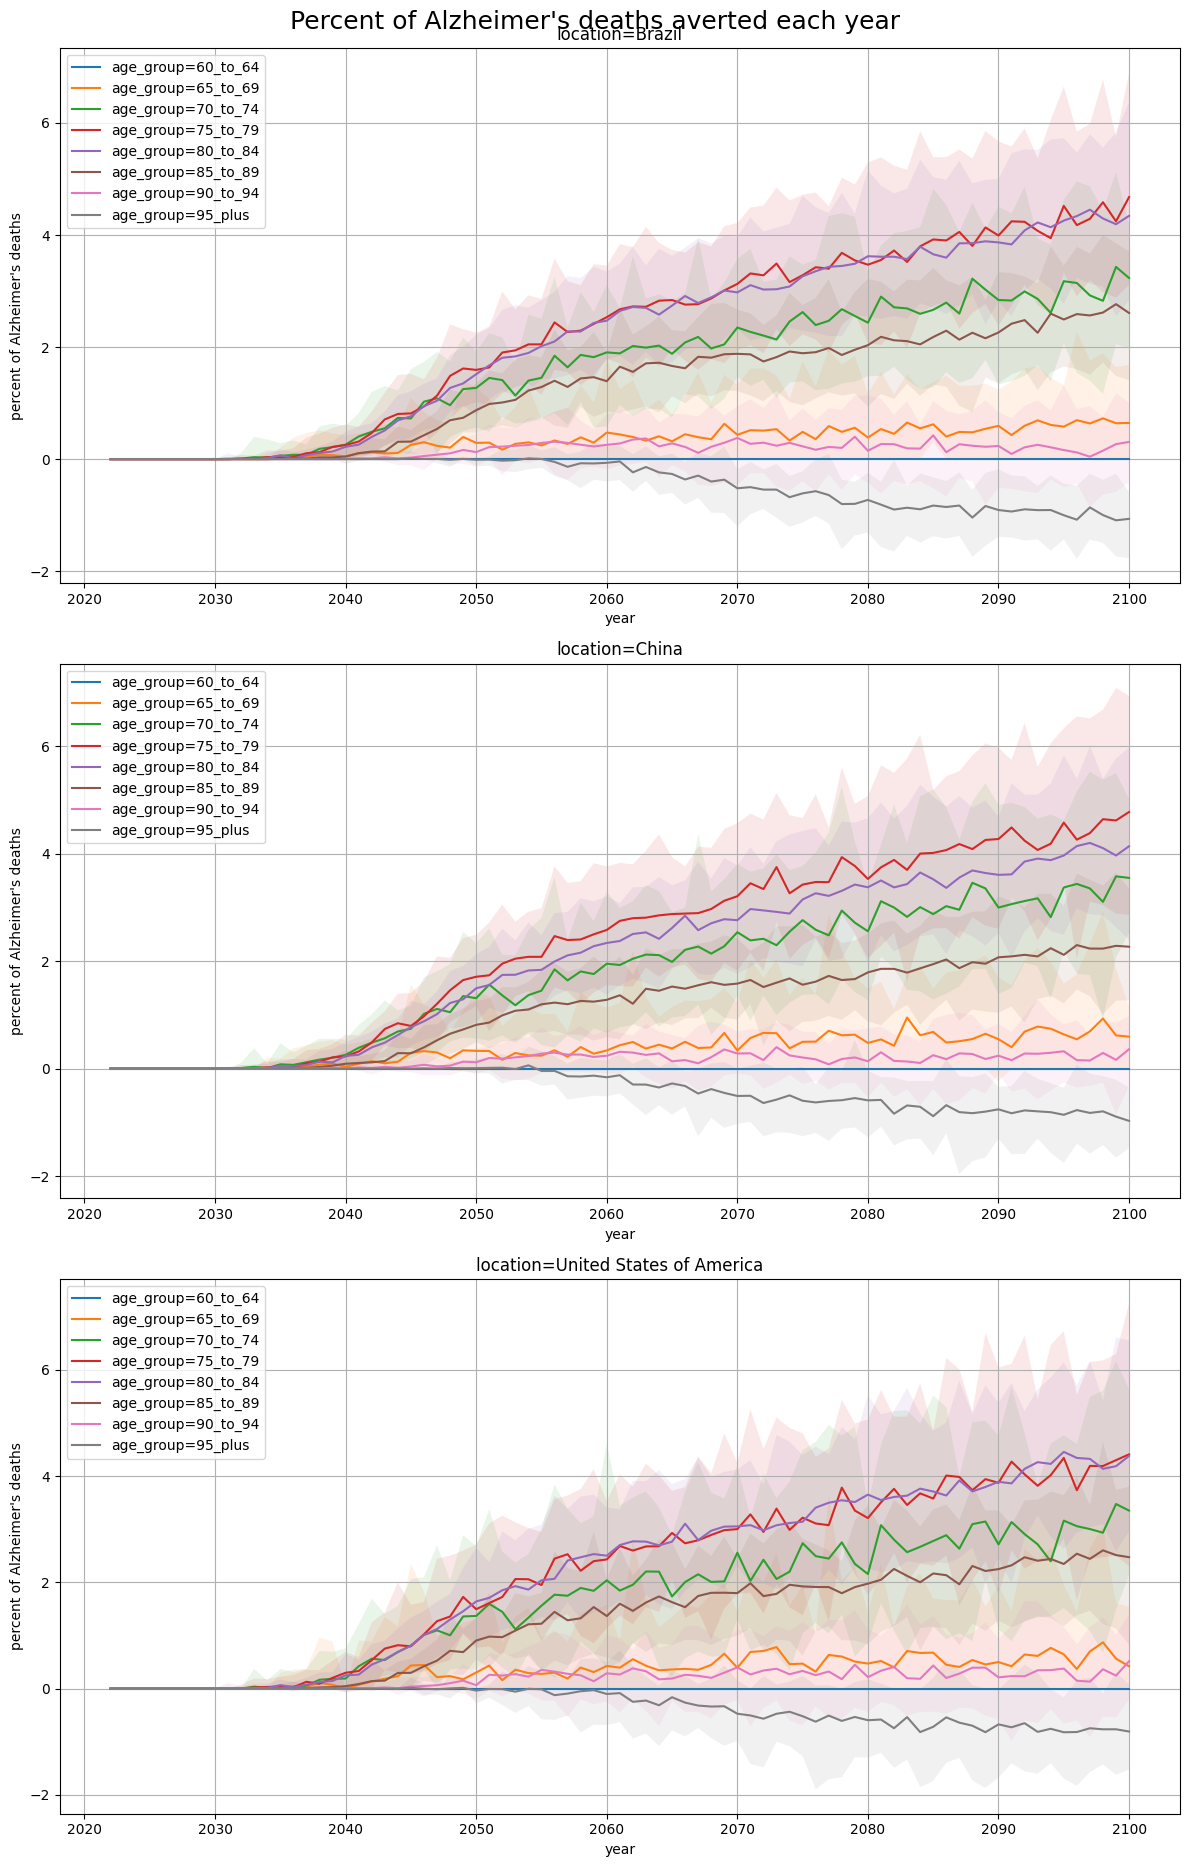

In [151]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [152]:
ylls = load_sim_output('ylls')
print_memory_usage(ylls)
ylls

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
27.732708 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1066495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                           entity entity_type  event_year  input_draw measure  \
0        alzheimers_disease_state       cause        2022           1    ylls   
1        alzheimers_disease_state       cause        2022           1    ylls   
2        alzheimers_disease_state       cause        2022           1    ylls   
3        alzheimers_disease_state       cause        2022           1    ylls   
4        alzheimers_disease_state       cause        2022           1    ylls   
...                           ...         ...         ...         ...     ...   
1066495              other_causes       cause        2100         249    ylls   
1066496              other_causes       cause        2100         249    ylls   
1066497              other_causes       cause        2100         249    ylls   
1066498              other_causes       cause        2100         249    ylls   
1066499              other_causes       cause        2100         249    ylls   

                           scenario     sex         value  \
0                          baseline  Female      0.000000   
1                          baseline    Male      0.000000   
2                      bbbm_testing  Female      0.000000   
3                      bbbm_testing    Male      0.000000   
4        bbbm_testing_and_treatment  Female      0.000000   
...                             ...     ...           ...   
1066495                    baseline    Male  10088.027970   
1066496                bbbm_testing  Female  33354.885569   
1066497                bbbm_testing    Male  10088.027970   
1066498  bbbm_testing_and_treatment  Female  34017.344973   
1066499  bbbm_testing_and_treatment    Male  10219.516635   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
1066495                    Brazil  
1066496                    Brazil  
1066497                    Brazil  
1066498                    Brazil  
1066499                    Brazil  

[1066500 rows x 11 columns]

In [153]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

27.732708 MB measure
12.090576 MB minuend
24.177576 MB subtrahend
6.405371 MB minuend re-indexed
12.804371 MB subtrahend re-indexed
12.804431 MB difference
18.489708 MB difference with reset index
19.201033 MB final difference
19.201033 MB


In [154]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

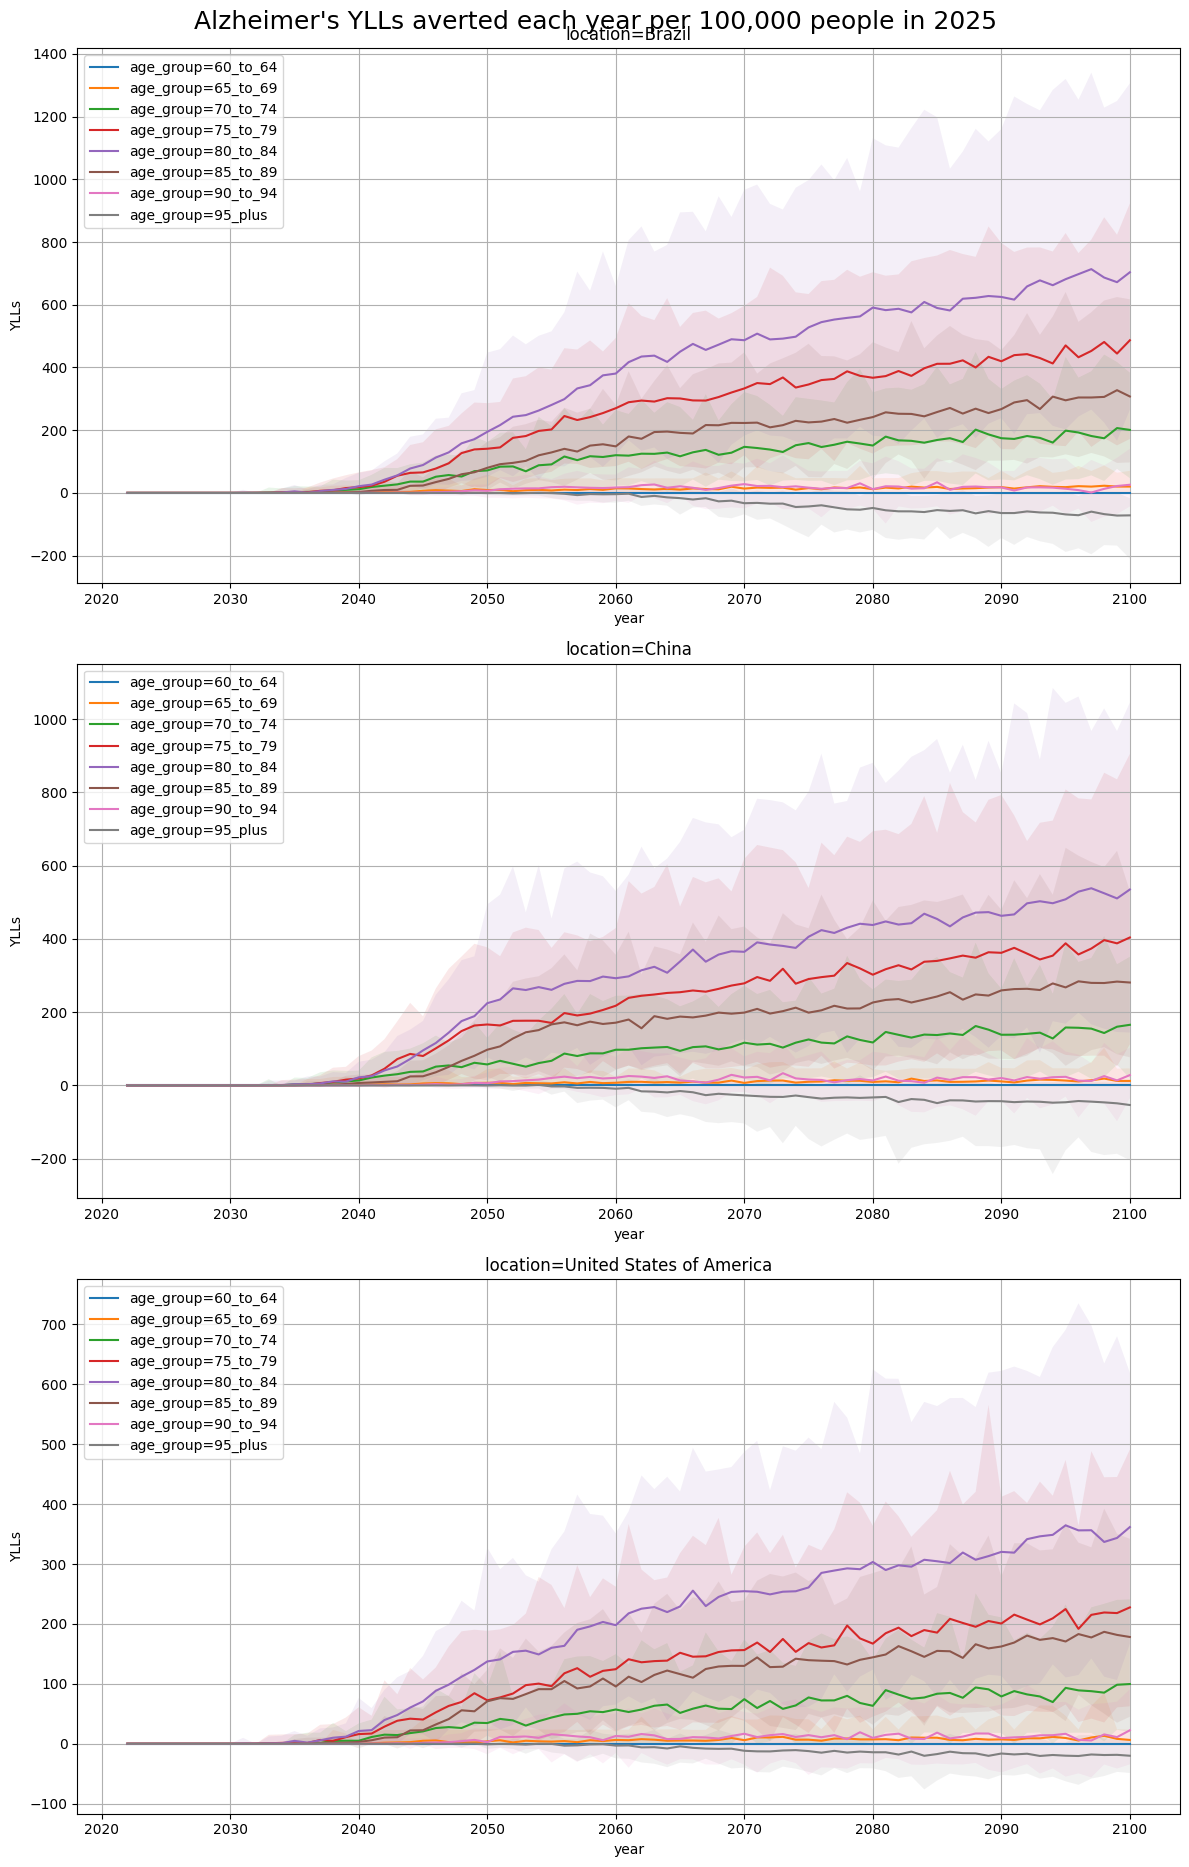

In [155]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

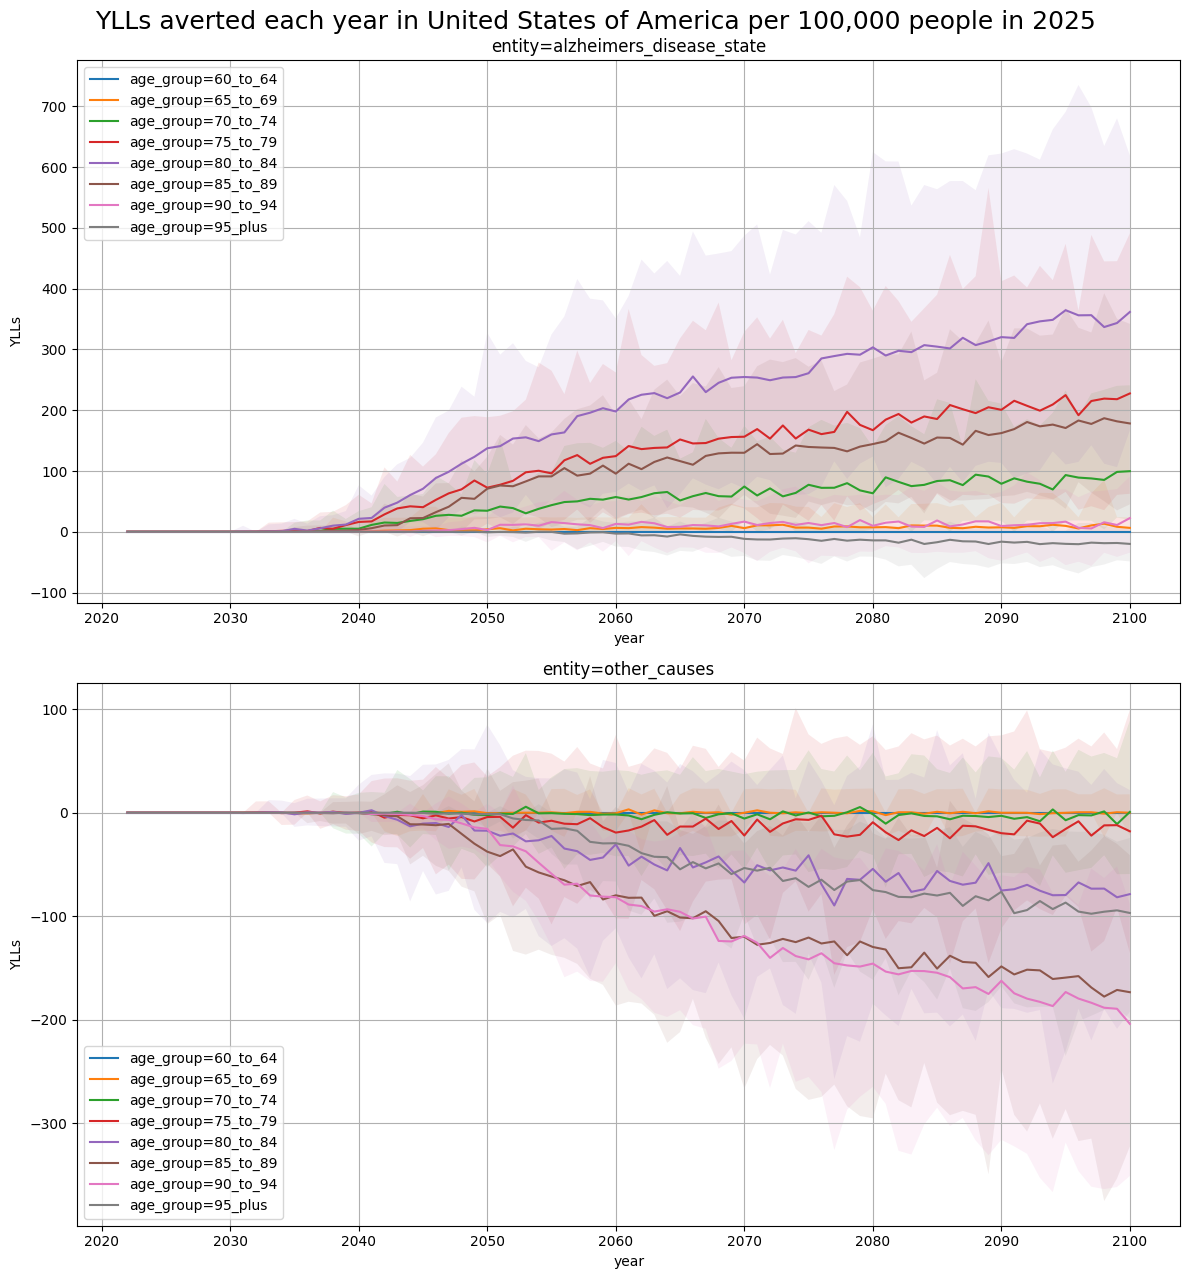

In [156]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

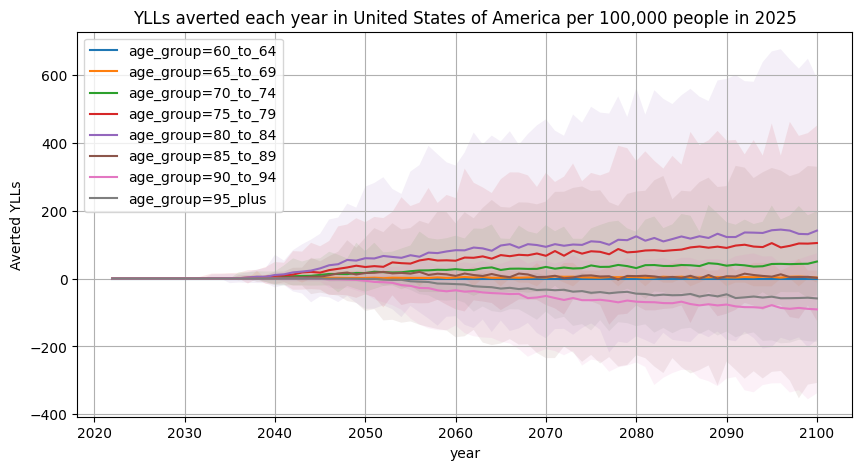

In [157]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [158]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
129.584561 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
4799245   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4799246   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4799247   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4799248   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4799249   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

             entity entity_type  event_year  input_draw measure  \
0        all_causes       cause        2022           1    ylds   
1        all_causes       cause        2022           1    ylds   
2        all_causes       cause        2022           1    ylds   
3        all_causes       cause        2022           1    ylds   
4        all_causes       cause        2022           1    ylds   
...             ...         ...         ...         ...     ...   
4799245   treatment       cause        2100         249    ylds   
4799246   treatment       cause        2100         249    ylds   
4799247   treatment       cause        2100         249    ylds   
4799248   treatment       cause        2100         249    ylds   
4799249   treatment       cause        2100         249    ylds   

                           scenario     sex                 sub_entity  value  \
0                          baseline  Female                 all_causes    0.0   
1                          baseline    Male                 all_causes    0.0   
2                      bbbm_testing  Female                 all_causes    0.0   
3                      bbbm_testing    Male                 all_causes    0.0   
4        bbbm_testing_and_treatment  Female                 all_causes    0.0   
...                             ...     ...                        ...    ...   
4799245  bbbm_testing_and_treatment    Male  no_effect_after_treatment    0.0   
4799246  bbbm_testing_and_treatment    Male    no_effect_never_treated    0.0   
4799247  bbbm_testing_and_treatment    Male           treatment_effect    0.0   
4799248  bbbm_testing_and_treatment    Male      waiting_for_treatment    0.0   
4799249  bbbm_testing_and_treatment    Male              waning_effect    0.0   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
4799245                    Brazil  
4799246                    Brazil  
4799247                    Brazil  
4799248                    Brazil  
4799249                    Brazil  

[4799250 rows x 12 columns]

In [159]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
# convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
averted_ylds = averted_ylds.astype(colname_to_dtype, copy=False)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

129.584561 MB measure
55.995929 MB minuend
111.987179 MB subtrahend
30.402793 MB minuend re-indexed
60.798043 MB subtrahend re-indexed
60.798103 MB difference
86.391311 MB difference with reset index
89.591136 MB final difference
89.591136 MB
89.591136 MB


In [160]:
1086.443257 / 27.372526

39.69101196579373

In [161]:
averted_ylds.memory_usage(deep=True)

Index                   132
age_group           3201030
artifact_path       3200078
entity              3199836
entity_type         3199670
event_year          6399000
input_draw         25596000
measure             3199669
sex                 3199732
sub_entity          3200525
location            3199814
scenario            3199825
subtracted_from     3199825
value              25596000
dtype: int64

In [162]:
averted_ylds.dtypes

age_group          category
artifact_path      category
entity             category
entity_type        category
event_year            int16
input_draw            int64
measure            category
sex                category
sub_entity         category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [163]:
averted_ylds

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

             entity entity_type  event_year  input_draw measure     sex  \
0        all_causes       cause        2022           1    ylds  Female   
1        all_causes       cause        2022           1    ylds    Male   
2        all_causes       cause        2022           1    ylds  Female   
3        all_causes       cause        2022           1    ylds    Male   
4        all_causes       cause        2022           6    ylds  Female   
...             ...         ...         ...         ...     ...     ...   
3199495   treatment       cause        2100         249    ylds    Male   
3199496   treatment       cause        2100         249    ylds    Male   
3199497   treatment       cause        2100         249    ylds    Male   
3199498   treatment       cause        2100         249    ylds    Male   
3199499   treatment       cause        2100         249    ylds    Male   

                        sub_entity                  location  \
0                       all_causes  United States of America   
1                       all_causes  United States of America   
2                       all_causes  United States of America   
3                       all_causes  United States of America   
4                       all_causes  United States of America   
...                            ...                       ...   
3199495  no_effect_after_treatment                    Brazil   
3199496    no_effect_never_treated                    Brazil   
3199497           treatment_effect                    Brazil   
3199498      waiting_for_treatment                    Brazil   
3199499              waning_effect                    Brazil   

                           scenario subtracted_from  value  
0                      bbbm_testing        baseline    0.0  
1                      bbbm_testing        baseline    0.0  
2        bbbm_testing_and_treatment        baseline    0.0  
3        bbbm_testing_and_treatment        baseline    0.0  
4                      bbbm_testing        baseline    0.0  
...                             ...             ...    ...  
3199495  bbbm_testing_and_treatment        baseline    0.0  
3199496  bbbm_testing_and_treatment        baseline    0.0  
3199497  bbbm_testing_and_treatment        baseline    0.0  
3199498  bbbm_testing_and_treatment        baseline    0.0  
3199499  bbbm_testing_and_treatment        baseline    0.0  

[3199500 rows x 13 columns]

In [164]:
averted_ylds.entity.unique()

['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [165]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

age_group                                      artifact_path  \
31600    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
31601    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
31602    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
31603    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
31604    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year  input_draw measure     sex  \
31600    treatment       cause        2022           1    ylds  Female   
31601    treatment       cause        2022           1    ylds  Female   
31602    treatment       cause        2022           1    ylds  Female   
31603    treatment       cause        2022           1    ylds  Female   
31604    treatment       cause        2022           1    ylds  Female   
...            ...         ...         ...         ...     ...     ...   
3199495  treatment       cause        2100         249    ylds    Male   
3199496  treatment       cause        2100         249    ylds    Male   
3199497  treatment       cause        2100         249    ylds    Male   
3199498  treatment       cause        2100         249    ylds    Male   
3199499  treatment       cause        2100         249    ylds    Male   

                        sub_entity                  location  \
31600    no_effect_after_treatment  United States of America   
31601      no_effect_never_treated  United States of America   
31602             treatment_effect  United States of America   
31603        waiting_for_treatment  United States of America   
31604                waning_effect  United States of America   
...                            ...                       ...   
3199495  no_effect_after_treatment                    Brazil   
3199496    no_effect_never_treated                    Brazil   
3199497           treatment_effect                    Brazil   
3199498      waiting_for_treatment                    Brazil   
3199499              waning_effect                    Brazil   

                           scenario subtracted_from  value  
31600                  bbbm_testing        baseline    0.0  
31601                  bbbm_testing        baseline    0.0  
31602                  bbbm_testing        baseline    0.0  
31603                  bbbm_testing        baseline    0.0  
31604                  bbbm_testing        baseline    0.0  
...                             ...             ...    ...  
3199495  bbbm_testing_and_treatment        baseline    0.0  
3199496  bbbm_testing_and_treatment        baseline    0.0  
3199497  bbbm_testing_and_treatment        baseline    0.0  
3199498  bbbm_testing_and_treatment        baseline    0.0  
3199499  bbbm_testing_and_treatment        baseline    0.0  

[1777500 rows x 13 columns]

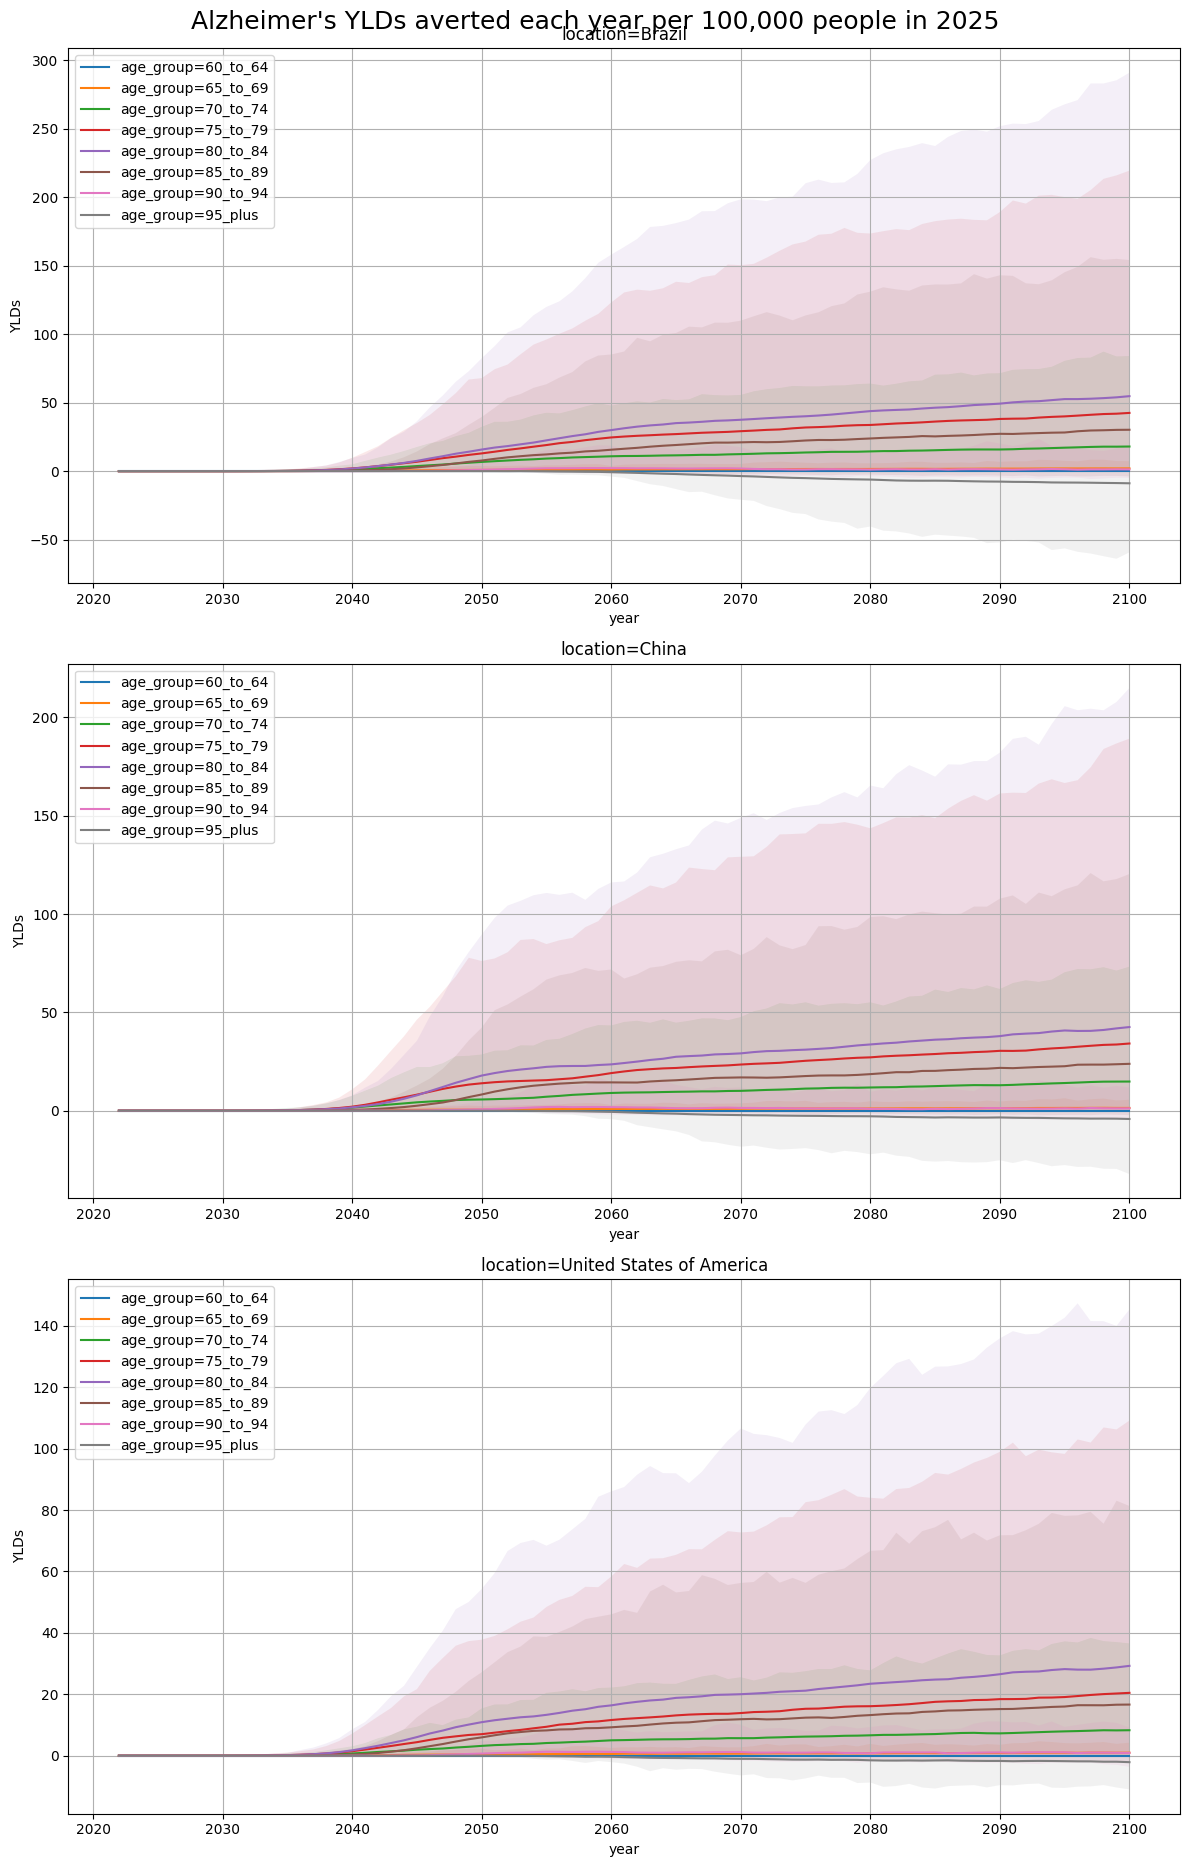

In [166]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

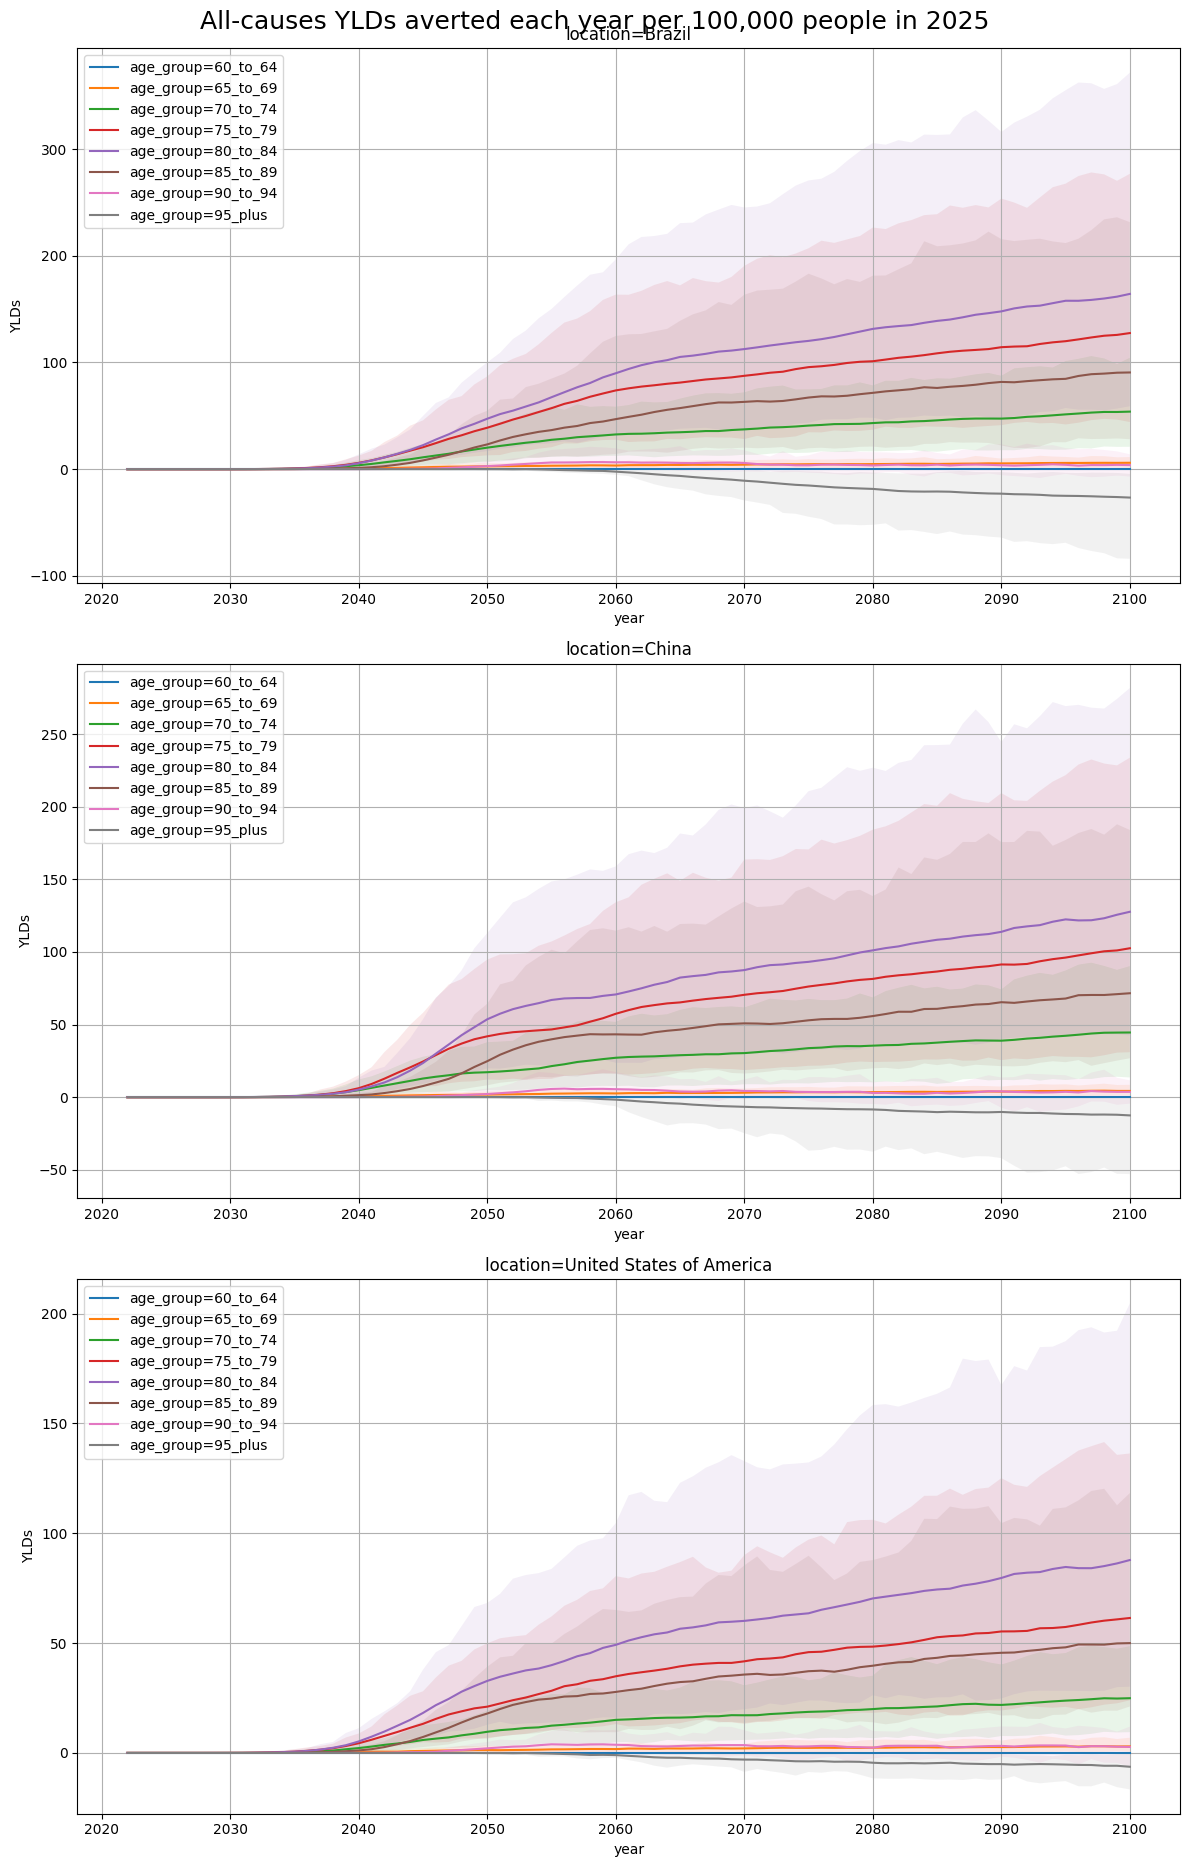

In [167]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

In [168]:
# Print current time to easily check if notebook ran all the way through
# vs. hitting an error somewhere above
import datetime
print(datetime.datetime.now())

2026-02-05 17:42:53.318147
